# Modules and useful functions

In [1]:
import numpy as np
from time import time
import math
import scipy.integrate as integrate
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
r = 0.02
chi = 1

un_sur_sqrt_pi = 1/(np.sqrt(2*np.pi))

def gaussian_density(x):
    return un_sur_sqrt_pi*np.exp(-0.5*x**2)

In [2]:
def G(t,T,chi):
    return (1-np.exp(chi*(t-T)))/chi

def A(t,x,y,maturities,bonds,ZC_t,chi,order=0):
    nb_maturities = len(maturities)
    resu = 0
    for n in range(nb_maturities-1):
        g = G(t,maturities[n+1],chi)
        resu += (-1)**order * (maturities[n+1]-maturities[n])*(bonds[n+1]/ZC_t)*np.exp(-1*g*x-0.5*y*g**2)*g**order
    return resu

# Swap rate in the model
def S(t,x,y,maturities,bonds,ZC_t,chi):
    if (t==0):
        return (bonds[0]-bonds[-1])/A(t,x,y,maturities,bonds,ZC_t,chi)
    else:
        g0 = G(t,maturities[0],chi)
        gN = G(t,maturities[-1],chi)
        PT0 = bonds[0]*np.exp(-1*g0*x-0.5*y*g0**2)
        PTN = bonds[-1]*np.exp(-1*gN*x-0.5*y*gN**2)
        return (PT0-PTN)/A(t,x,y,maturities,bonds,ZC_t,chi)
    
# dS/dx
def q(t,x,y,maturities,bonds,ZC_t,chi):
    At = A(t,x,y,maturities,bonds,ZC_t,chi)
    B = A(t,x,y,maturities,bonds,ZC_t,chi,1) # A prime
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    PT0 = (np.exp(-r*(maturities[0]-t))*np.exp(-1*g0*x-0.5*y*g0**2))
    PTN = (np.exp(-r*(maturities[-1]-t))*np.exp(-1*gN*x-0.5*y*gN**2))
    qt = (PTN*gN - PT0*g0)/At - (PT0-PTN)*B/(At**2)
    return qt



In [3]:
def simul(lmbda,a,b,chi,T0,N,M,scheme = "log-Euler"):
    delta = T0/N
    resu = []
    C = b*lmbda
    if(scheme == "log-Euler"):
        for m in range(M):
            (u,x,y,I) =(np.log(a/b),0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                u = u + (b*(y-chi*x)/(a+b*x) -0.5*C**2) * delta + C * math.sqrt(delta) * Z[i]
                y = y + (sigma_i**2 -2*chi*y)*delta
                if(np.exp(u) - a/b > 1e10):
                    x = 1e10
                else:
                    x = np.exp(u) - a/b
            resu.append((x,y,I))
            
    elif (scheme == "Euler"):
        for m in range(M):
            (x,y,I) =(0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                if(x + (y-chi*x)*delta + sigma_i*math.sqrt(delta)*Z[i] > 1e10):
                    x = 1e10
                else:
                    x = x +(y-chi*x)*delta + sigma_i*math.sqrt(delta)*Z[i]
                y = y + (sigma_i**2 -2*chi*y)*delta
            resu.append((x,y,I))
            
    elif (scheme == "Impli Euler"):
        for m in range(M):
            (x,y,I) =(0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                y = y + (sigma_i**2 -2*chi*y)*delta
                x = (x + y*delta + sigma_i*math.sqrt(delta)*Z[i])/(1 + chi * delta)
            resu.append((x,y,I))
            
    elif (scheme == "Impli log-Euler"):
        for m in range(M):
            (u,x,y,I) =(np.log(a/b),0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                y = y + (sigma_i**2 -2*chi*y)*delta
                arg = u - (chi + 0.5*C**2) * delta + C * math.sqrt(delta) * Z[i]
                u = opt.newton(lambda t: f(t,y,chi,a,b,delta) - arg,0,fprime = lambda t: 1 + delta*(y+ chi*a/b)*np.exp(-t))
                x = np.exp(u) - a/b
            resu.append((x,y,I))
    else:
        print("Unknown scheme")
    return resu

def payoff_swaption(maturities,bonds,x,y,chi,K):
    T0 = maturities[0]                             #maturities = [T0,...,TN]
    nb_maturities = maturities.size
    A = 0
    #calculate the annuity A
    for n in range(nb_maturities-1):
        g = G(T0,maturities[n+1],chi)
        A += (maturities[n+1]-maturities[n])*bonds[n+1]*np.exp(-1*g*x-0.5*y*g**2)
    g = G(T0,maturities[-1],chi)
    swap = bonds[0] - bonds[-1]*np.exp(-1*g*x-0.5*y*g**2) - K*A
    if swap>0:
        return swap
    else:
        return 0

def swaption_MC(M,sim,K,chi,bonds,maturities,IC=False,variance = False):
    Monte_Carlo = 0
    moment_2 = 0
    for m in range(M):
        (x,y,I) = sim[m]
        s_m = np.exp(I)*payoff_swaption(maturities,bonds,x,y,chi,K)
        Monte_Carlo += s_m
        moment_2 += s_m**2
    price = Monte_Carlo/M
    if(variance):
        var = moment_2/M - price**2
        print("Variance:",var)
    if(IC):
        print("IC (95%) radius:", 1.96 * np.sqrt(var / M))
    return price

In [4]:
sim = simul(1,1,1,1,1,20,10000,"Euler")
maturities = np.arange(1,6.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
print(swaption_MC(10000,sim,0.05,1,bonds,maturities,True,True))

Variance: 0.044616310686570904
IC (95%) radius: 0.004140024385598843
0.17377370497283082


# Calibration algorithm

One assume to have a swaption strip of $N-1$ swaptions with a maturity grid $0=T_0,T_1,...,T_N$. The n-th swaption expires at $T_n$ for $n \in [|1,N-1|]$ and the underlying swap pays every 6 months between $T_n$ and $T_N$.
In other words, the n-th underlying swap tenor structure is $(T_n, T_n+6M, ..., T_N)$.

One considers the local volatility under the form $$\sigma_r(t,x,y) = \sum_{n=1}^{N-1} \lambda_n ( S_n(0) + b_n D_n x) \mathbb{1}_{t \in ]T_{n-1},T_n]}, \quad D_n = \frac{\partial S}{\partial x} (t,0,0)$$

So $\bar{y(t)}$ becomes $$\bar{y}(t) = \int_{0}^{t} e^{-2\chi (t-s)} \sigma_r(s,0,0)^2 \ \mathrm{d}s = \frac{1}{2\chi} \sum_{n=1}^{N-1} \lambda_n^2 S_n(0)^2 \big( e^{-2\chi(t-t \land T_n)} - e^{-2\chi(t-t \land T_{n-1})}\big)$$

**Algorithm:**

Let $(\hat{\lambda}_n,\hat{b}_n)_{n=1,N-1}$ a set of observed parameters.

For $n = 1,N-1$:

- Guess a value for $(\lambda_n,b_n)$
- Compute $\bar{x}(t), \bar{y}(t)$ for $t \in [0,T_n]$
- Compute $\bar{\lambda}_{Sn}$ and $\bar{b}_{S_n}$ with the known parameters $(\lambda_i,b_i)_{i=1,n-1}$ and $(\lambda_n,b_n)$
- Find $(\lambda_n,b_n)$ such that $\lVert (\bar{\lambda}_{S_n},\bar{b}_{S_n}) - (\hat{\lambda}_n,\hat{b}_n) \rVert \le \epsilon$ or $(\bar{\lambda}_{S_n} - \hat{\lambda}_n)^2 \le \frac{\epsilon^2}{2} \quad \& \quad (\bar{b}_{S_n} - \hat{b}_n)^2 \le \frac{\epsilon^2}{2}$

In practice, one can directly use a root finding algorithm. Indeed, one notes $$\begin{array}{ll} \psi : \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big) \rightarrow \bar{\lambda}_{S_n}\\
\phi : \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big) \rightarrow \bar{b}_{S_n} \end{array}$$

One can find the zero of the function $$(\lambda,b) \rightarrow \Big(\psi \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big), \phi \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big) \Big)- \Big(\hat{\lambda}_n,\hat{b}_n \Big)$$

## 1. Data set

**Set of observed parameters**

In order to construct the set of observed parameters, assume that one has a data set of Black Scholes implied volatility from the market. For a swaption which expires at $T_n$ and strikes values $K_1,...,K_M$, one has the volatility smile $$\hat{\sigma}(T_n,K_m),\quad n=1,N-1 \quad m=1,M$$

One are looking for the parameters $(\hat{\lambda_n},\hat{b}_n)_{n=1,N-1}$ such that the n-th observed swaption price matches a Displaced log-normal swaption price with parameters $(\hat{\lambda}_n,\hat{b}_n)$.

$$\mathrm{d}S_n(t) = \hat{\lambda}_n \big( \hat{b}_n S_n(t) + (1-\hat{b}_n)S_n(0)\big) \ \mathrm{d}W_t$$

One wants $$\forall n, \ (\hat{\lambda_n},\hat{b}_n) = argmin_{(\lambda,b) \in \mathbb{R}\times \mathbb{R}^*} \sum_{m=1}^{M} \Big( Swaption^{LD}(\lambda,b,T_n,K_m) - Swaption^{BS}(T_n,K_m,\hat{\sigma}(T_n,K_m)) \Big)^2$$

A simpler solution is to take for each swaption, $(\hat{\lambda}_n,\hat{b}_n) =$ (IV ATM, IV slope ATM).

In [4]:
#Swaption price under BS model

def Price_BS(S0,A0,T0,K,sigma):
    if(T0==0):
        return A0 * max(0,S0-K)
    elif(S0*K >0 and S0>0 and sigma>0):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        return S0*A0* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))
    elif (S0*K >0 and S0<0 and sigma>0):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        return S0*A0* stats.norm.cdf(-d) -K*A0*stats.norm.cdf(-d+sigma*np.sqrt(T0))
    else:
        return A0* max(0,S0-K)

#Swaption price under normal model
    
def swaption_normal(sigma,K,maturities,bonds):
    T = maturities[0]
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    if (sigma==0):
        return -K * A0 * int( K < 0)
    else:
        d = (S0-K)/(sigma*np.sqrt(T))
        return A0*((S0-K)*stats.norm.cdf(d) + sigma*np.sqrt(T)*gaussian_density(d))
    
#Swaption price under displaced log-normal model

def log_displaced(S0,A0,T0,K,lmbda,b):
    if(T0==0):
        return A0 * max(0,S0-K)
    
    elif (S0 == 0 or lmbda==0):
        return - A0 * min(0,K)
        
    elif (b==0):
        d = (S0-K)/(lmbda*S0*np.sqrt(T0))
        if (S0 * lmbda > 0):
            return A0 * (S0-K) * stats.norm.cdf(d) + A0 * lmbda * S0 * np.sqrt(T0) * gaussian_density(d)
        else:
            return A0 * (S0-K) * stats.norm.cdf(-d) - A0 * lmbda * S0 * np.sqrt(T0) * gaussian_density(d)
        
    elif(S0 -K < S0/b and S0/b < 0):
        return 0
    
    elif (0 < S0/b and S0/b < S0-K):
        return A0 * (S0 - K)
    
    elif (S0/b < 0 and K - S0 + S0/b < 0):
        d = (np.log(S0/(b*K+(1-b)*S0)) + 0.5*lmbda**2 * b**2 * T0)/(lmbda*b*np.sqrt(T0))
        return A0*S0/b * stats.norm.cdf(-d) - A0*(K+(1-b)/b *S0) * stats.norm.cdf(-d + lmbda*b*np.sqrt(T0))
    
    d = (np.log(S0/(b*K+(1-b)*S0)) + 0.5*lmbda**2 * b**2 * T0)/(lmbda*b*np.sqrt(T0))
    return A0*S0/b * stats.norm.cdf(d) - A0*(K+(1-b)/b *S0) * stats.norm.cdf(d - lmbda*b*np.sqrt(T0))

In [5]:
#test with artificial data
maturities = np.arange(1,5,1)
bonds = [np.exp(-r*m) for m in maturities]
T0 = 1
strikes = [0.05,0.1,0.15,0.2]
IV = [0.25,0.2,0.18,0.15]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
fun = lambda x: np.array([(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]) - Price_BS(S0,A0,T0,strikes[m],IV[m])) for m in range(len(strikes))])
x_0 = np.array([1,1])
res = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,1]))
res

 active_mask: array([0, 0])
        cost: 1.3928831777165984e-11
         fun: array([5.27803596e-06, 7.18771457e-11, 6.37996916e-15, 2.45930228e-18])
        grad: array([1.35050869e-09, 1.38536994e-10])
         jac: array([[2.55873339e-04, 2.62478306e-05],
       [8.29351572e-09, 1.26717228e-09],
       [1.13124882e-12, 1.97198003e-13],
       [5.65487165e-16, 1.05739063e-16]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 7
        njev: 7
  optimality: 1.3505086864831042e-09
      status: 1
     success: True
           x: array([0.29474354, 0.94389479])

In [5]:
#Maturity_grid: set of expiration dates of the swaptions
# Strikes: set of strikes
# IV: Matrix of the observed IV for each T0,K
# delta: time interval between payments in each underlying swap
# returns a numpy array [[lmbda_1,b_1],...,[lmbda_N-1,b_N-1]]

def data_set(maturity_grid,strikes,IV,chi,delta,iv_atm):
    term_date = maturity_grid[-1]
    res = np.zeros((len(maturity_grid)-2,2))
    for i in range(1,len(maturity_grid)-1):
        T0 = maturity_grid[i]
        maturities = np.arange(T0,term_date + delta,delta)
        bonds = [np.exp(-r*m) for m in maturities]
        A0 = A(0,0,0,maturities,bonds,1,chi)
        S0 = S(0,0,0,maturities,bonds,1,chi)
        fun = lambda x: np.array([(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]) - Price_BS(S0,A0,T0,strikes[m],IV[i-1][m])) for m in range(len(strikes))])
        x_0 = np.array([iv_atm,1])
        opt_param = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,10])).x
        res[i-1] = opt_param
    return res

**Remark:** During the optimization step, we have to ensure that $\ln(\frac{S(0)}{bK+(1-b)S(0)})$ is well defined, so for $0 < K < S(0)$, $b$ has to be bounded by $\frac{S(0)}{S(0)-K}$, so one takes 1 as upper bound to avoid any issue.

In [8]:
#test with a simple data set
maturity_grid = [0,1,2,3]
IV = [[0.25,0.2,0.18,0.15],[0.2,0.18,0.16,0.15],[0.19,0.16,0.12,0.1]]
data_set(maturity_grid,strikes,IV,chi,0.5,1)

array([[0.30597063, 1.09375421],
       [0.22804669, 1.176251  ]])

Observed data set from FinPricing:

| Maturity (M) | Strike    | IV            |  
|--------------|-----------|---------------|
| 1            | 0.01      | 0.528341118   |   
| 1            | 0.02      | 0.208871904   |   
| 1            | 0.03      | 0.315791907   |
| 1            | 0.04      | 0.392419764   |
| 1            | 0.05      | 0.447727552   |
| 1            | 0.07      | 0.524478308   |
| 1            | 0.1       | 0.59765607    |
| 1            | 0.12      | 0.631982811   |


In [7]:
#test with an observed data set
maturity_grid = [0,1/12,1+1/12]
strikes = [0.01,0.02,0.03,0.04,0.05,0.07,0.1,0.12]
IV = [[0.528341118,0.208871904,0.315791907,0.392419764,0.447727552,0.524478308,0.59765607,0.631982811,]]
data = data_set(maturity_grid,strikes,IV,chi,1/12,IV[0][1])
print("Observed parameters with least squares method:",data)
print("Observed parameters with basic method:",IV[0][1],(IV[0][0]-IV[0][2])/0.02)


Observed parameters with least squares method: [[0.2088719 1.       ]]
Observed parameters with basic method: 0.208871904 10.627460550000004


In [6]:
#Compute Implied vol

def biss_python(Mtm, bonds, K, maturities,model = "log-normal",b = 0.5):
    T0 = maturities[0] 
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    #Inversion in the log normal model
    if(model == "log-normal"):
        if(Mtm >= S0*A0):
            print("!! Le prix d'entrée est au-dessus des limites BS!!",Mtm, ">", S0*A0)
            return 0
        
        lim_inf =  A0*max(0,S0-K)
        Ecart_lim = Mtm - A0*max(0,S0-K)
        
        if(Ecart_lim < 0):
            #print("!! Le prix d'entrée est en-dessous des limites BS!!", Mtm, "<", lim_inf)
            return 0
        else:
            return opt.bisect(lambda x: 1e40 * (Price_BS(S0,A0,T0,K,x) - Mtm), 0, 10)
    
    #Inversion in the normal model
    if(model == "normal"):
        return opt.bisect(lambda x: swaption_normal(x,K,maturities,bonds) - Mtm, 0, 50) 
    
    #Inversion in the log-displaced model
    if(model == "log-displaced"):
        return opt.bisect(lambda x: log_displaced(x,b,K,maturities,bonds) - Mtm, 0.001,50)

Data set construction with  $$\forall n, \ (\hat{\lambda_n},\hat{b}_n) = argmin_{(\lambda,b) \in \mathbb{R}\times \mathbb{R}^*} \sum_{m=1}^{M} \Big( C_{BS}^{-1}\big(Swaption^{LD}(\lambda,b,T_n,K_m),T_n,K_m\big) - \hat{\sigma}(T_n,K_m) \Big)^2$$

In [7]:
# Observed parameters computed from implied volatility instead of prices

def data_set_bis(maturity_grid,strikes,IV,chi,delta,iv_atm,slope_atm,iv_model = "log-normal"):
    term_date = maturity_grid[-1]
    res = np.zeros((len(maturity_grid)-2,2))
    for i in range(1,len(maturity_grid)-1):
        T0 = maturity_grid[i]
        maturities = np.arange(T0,term_date + delta,delta)
        bonds = [np.exp(-r*m) for m in maturities]
        A0 = A(0,0,0,maturities,bonds,1,chi)
        S0 = S(0,0,0,maturities,bonds,1,chi)
        fun = lambda x: np.array([(biss_python(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]), bonds, strikes[m], maturities,iv_model) - IV[i-1][m]) for m in range(len(strikes))])
        x_0 = np.array([iv_atm[i-1],slope_atm[i-1]])
        opt_param = opt.least_squares(fun,x_0, bounds=([0,0], [np.inf,10])).x
        res[i-1] = opt_param
    return res

In [12]:
data2 = data_set_bis(maturity_grid,strikes,IV,chi,1/12,[0.208871904],[1])
data2

array([[0.18347203, 6.60060624]])

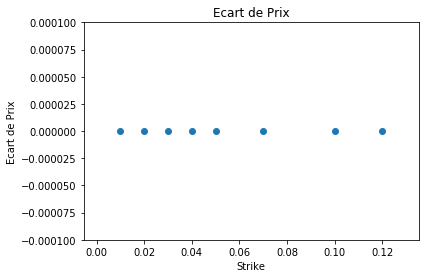

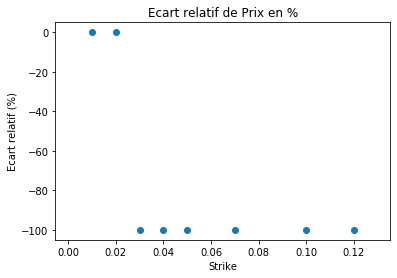

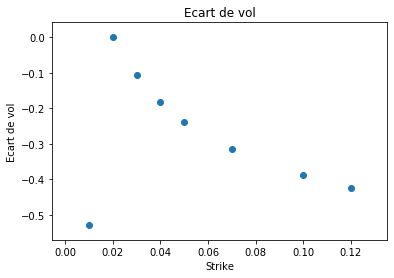

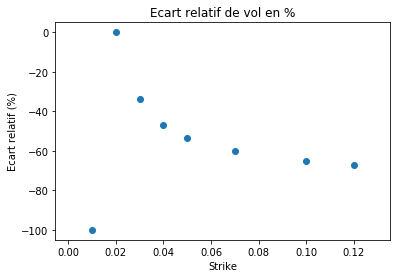

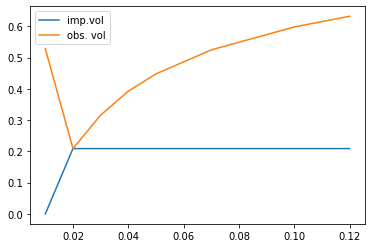

In [13]:
# comparaison des parametres calculés sur les prix et ceux calculés sur la vol. implicite
T0 = 1/12
maturities = np.arange(T0,maturity_grid[-1]+1/12,1/12)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
lmbdas = [0]
b_vals = [0]
diff_price1 = [log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
diff_vol1 = [(biss_python(log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]), bonds, strikes[m], maturities) - IV[0][m]) for m in range(len(strikes))]

plt.scatter(strikes,diff_price1)
plt.ylim([-0.0001, 0.0001])
plt.xlabel("Strike")
plt.ylabel("Ecart de Prix")
plt.title("Ecart de Prix")
plt.show()

ecart_relatif = [100*(log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]))/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de Prix en %")
plt.show()

plt.scatter(strikes,diff_vol1)
plt.xlabel("Strike")
plt.ylabel("Ecart de vol")
plt.title("Ecart de vol")
plt.show()

ecart_relatif1 = [100*(biss_python(log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]), bonds, strikes[m], maturities) - IV[0][m])/ IV[0][m] for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif1)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de vol en %")
plt.show()

v= [biss_python(log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]), bonds, strikes[m], maturities) for m in range(len(strikes))]
u = IV[0]
plt.plot(strikes,v,label= 'imp.vol')
plt.plot(strikes,u,label='obs. vol')
plt.legend()
plt.show()

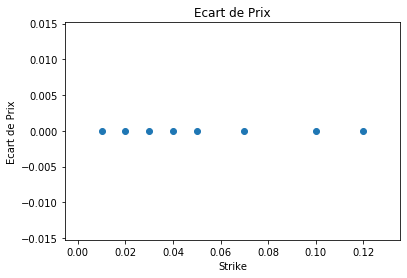

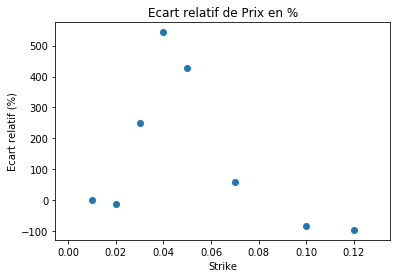

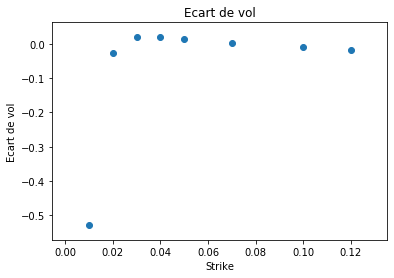

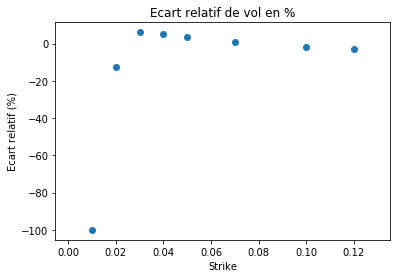

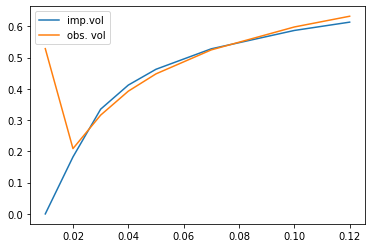

In [14]:
diff_price2 = [log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
diff_vol2 = [(biss_python(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]), bonds, strikes[m], maturities) - IV[0][m]) for m in range(len(strikes))]

plt.scatter(strikes,diff_price2)
#plt.ylim([-0.001, 0.001])
plt.xlabel("Strike")
plt.ylabel("Ecart de Prix")
plt.title("Ecart de Prix")
plt.show()

ecart_relatif2 = [100*(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]))/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif2)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de Prix en %")
plt.show()

plt.scatter(strikes,diff_vol2)
plt.xlabel("Strike")
plt.ylabel("Ecart de vol")
plt.title("Ecart de vol")
plt.show()

ecart_relatif3 = [100*(biss_python(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]), bonds, strikes[m], maturities) - IV[0][m])/ IV[0][m] for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif3)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de vol en %")
plt.show()

v= [biss_python(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]), bonds, strikes[m], maturities) for m in range(len(strikes))]
u = IV[0]
plt.plot(strikes,v,label= 'imp.vol')
plt.plot(strikes,u,label='obs. vol')
plt.legend()
plt.show()

## Implied volatility curve fitting

### Fitting on prices

(lambda,b)= [0.20000695 1.        ]
Diff array [1.58038896e-008 4.18196049e-019 1.33942436e-039 6.37998379e-063
 2.35581443e-110 9.69530216e-177 4.47407019e-217]


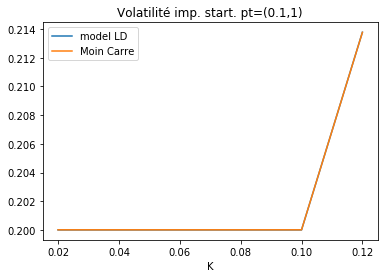

(lambda,b)= [0.19987177 1.00701703]
Diff array [-2.93882334e-007  7.34901013e-018  5.53650346e-038  4.08899324e-061
  2.92112344e-108  2.95067806e-174  2.46087749e-214]


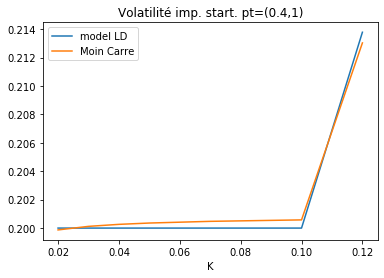

(lambda,b)= [0.2001424  1.35476262]
Diff array [2.03651335e-007 4.32900690e-015 6.56696878e-032 1.12640533e-049
 1.06615023e-083 7.97718828e-129 2.14789125e-155]


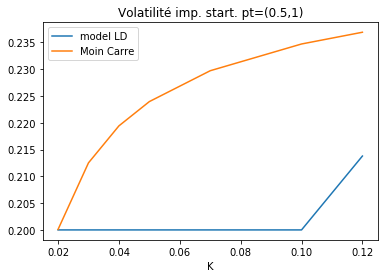

In [14]:
T0 = 1/12
maturities = np.arange(T0,T0+1+1/12,1/12)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
Prices = [log_displaced(S0,A0,T0,k,0.2,1) for k in strikes]
fun = lambda x: np.array([(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]) - Prices[m]) for m in range(1,len(strikes))])
for l0 in [0.1,0.4,0.5]:
    x_0 = np.array([l0,1])
    opti = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,11]))
    opt_param = opti.x
    d = opti.fun
    print("(lambda,b)=",opt_param)
    print("Diff array",d)

    plt.plot(strikes[1:],[biss_python(Prices[m], bonds, strikes[m], maturities) for m in range(1,len(strikes))],label='model LD')
    plt.plot(strikes[1:],[biss_python(log_displaced(S0,A0,T0,k,opt_param[0],opt_param[1]), bonds, k, maturities) for k in strikes[1:]],label='Moin Carre')
    plt.legend()
    plt.title("Volatilité imp. start. pt=(" + str(l0)+",1)")
    plt.xlabel("K")
    plt.show()

(lambda,b)= [0.20000695 1.        ]
Diff array [1.58038896e-008 4.18196049e-019 1.33942436e-039 6.37998379e-063
 2.35581443e-110 9.69530216e-177 4.47407019e-217]


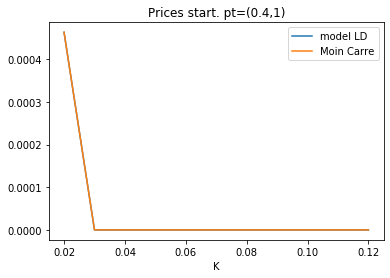

In [70]:
x_0 = np.array([0.1,1])
opti = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,11]))
opt_param = opti.x
d = opti.fun
print("(lambda,b)=",opt_param)
print("Diff array",d)

plt.plot(strikes[1:],Prices[1:],label='model LD')
plt.plot(strikes[1:],[log_displaced(S0,A0,T0,k,opt_param[0],opt_param[1]) for k in strikes[1:]],label='Moin Carre')
plt.legend()
plt.title("Prices start. pt=(0.4,1)")
plt.xlabel("K")
plt.show()

### Fitting on IV

(lambda,b)= [0.20000001 0.99999979]
Diff array [ 0.00000000e+00  1.39357326e-08  6.60065780e-09  2.44654075e-09
 -2.97859515e-10 -3.78804543e-09 -6.80074663e-09  9.91121851e-09]


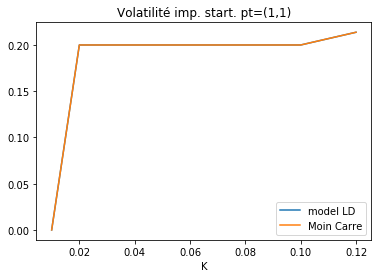

In [71]:
fun2 = lambda x: np.array([(biss_python(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]),bonds,strikes[m],maturities) - biss_python(Prices[m], bonds, strikes[m], maturities)) for m in range(len(strikes))])
x_0 = np.array([0.5,1.5])
opti = opt.least_squares(fun2,x_0, bounds=([-np.inf,0], [np.inf,11]))
opt_param = opti.x
d = opti.fun
print("(lambda,b)=",opt_param)
print("Diff array",d)

plt.plot(strikes,[biss_python(Prices[m], bonds, strikes[m], maturities) for m in range(len(strikes))],label='model LD')
plt.plot(strikes,[biss_python(log_displaced(S0,A0,T0,k,opt_param[0],opt_param[1]), bonds, k, maturities) for k in strikes],label='Moin Carre')
plt.legend()
plt.title("Volatilité imp. start. pt=(1,1)")
plt.xlabel("K")
plt.show()

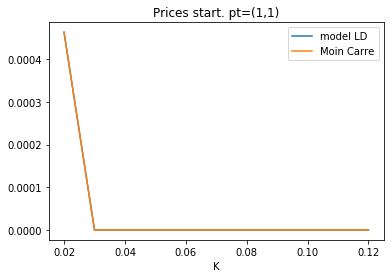

In [72]:
plt.plot(strikes[1:],Prices[1:],label='model LD')
plt.plot(strikes[1:],[log_displaced(S0,A0,T0,k,opt_param[0],opt_param[1]) for k in strikes[1:]],label='Moin Carre')
plt.legend()
plt.title("Prices start. pt=(1,1)")
plt.xlabel("K")
plt.show()

**Conclusion**: Better construct the data set with least squares method on Implied volatility because it seems to be less dependant on the starting point.

---

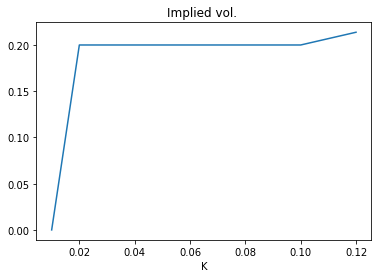

Strike: 0.01
Difference with the limit: -1.734723475976807e-18
0.009892410509646498
Strike: 0.02
Difference with the limit: 0.0004468833365562168
0.00046335238718965555
Strike: 0.03
Difference with the limit: 2.312457509341635e-16
2.312457509341635e-16
Strike: 0.04
Difference with the limit: 2.6206379779662484e-37
2.6206379779662484e-37
Strike: 0.05
Difference with the limit: 7.187244860381949e-61
7.187244860381949e-61
Strike: 0.07
Difference with the limit: 1.4213697129474589e-108
1.4213697129474589e-108
Strike: 0.1
Difference with the limit: 3.5330566627241844e-175
3.5330566627241844e-175
Strike: 0.12
Difference with the limit: 1.3120402316820564e-215
1.3120402316820564e-215


In [73]:
T0 = 1/12
maturities = np.arange(T0,1+1/12+1/12,1/12)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
strikes = [0.01,0.02,0.03,0.04,0.05,0.07,0.1,0.12]
curve = [biss_python(log_displaced(S0,A0,T0,k,0.2,1), bonds, k, maturities) for k in strikes]
plt.plot(strikes,curve,label='IV')
plt.xlabel("K")
plt.title("Implied vol. ")
plt.show()
for k in strikes:
    print("Strike:",k)
    p = log_displaced(S0,A0,T0,k,0.2,1)
    print("Difference with the limit:",p - A0 * max(0,S0-k))
    print(p)

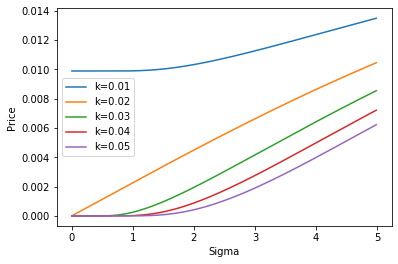

In [26]:
sigma_val = np.arange(0,5,0.01)
for k in strikes[0:5]:
    pric = [Price_BS(S0,A0,T0,k,s) for s in sigma_val]
    plt.plot(sigma_val,pric,label="k=" + str(k))
plt.legend()
plt.ylabel("Price")
plt.xlabel("Sigma")
plt.show()

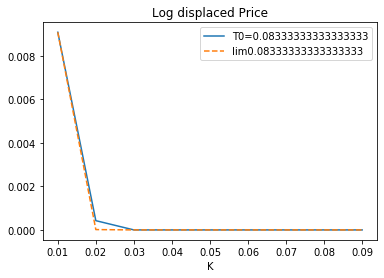

In [19]:
strikes = np.arange(0.01,0.1,0.01)
T0s = [0,0.5,1,2]
colors=['r','black','pink','purple','cyan']
i=0
for t in [1/12]:
    maturities = np.arange(t,t+1,1/12)
    T0 = maturities[0]
    bonds = [np.exp(-r*m) for m in maturities]
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    limit_l = [A(0,0,0,maturities,bonds,1,chi)*max(0,S(0,0,0,maturities,bonds,1,chi)-k) for k in strikes]
    log_disp_prices_K = [log_displaced(S0,A0,T0,k,0.2,1) for k in strikes]
    plt.plot(strikes,log_disp_prices_K,label="T0="+str(t))
    plt.plot(strikes,limit_l,linestyle='--',label="lim" + str(t))
    
    i +=1
    
plt.xlabel("K")
plt.title("Log displaced Price")
plt.legend()

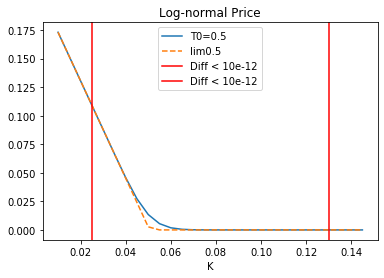

In [21]:
r=0.05
strikes = np.arange(0.01,0.15,0.005)
colors=['r','black','pink','purple','cyan']
i=0
for t in [0.5]:
    maturities = np.arange(t,t+5.5,0.5)
    T0 = maturities[0]
    bonds = [np.exp(-r*m) for m in maturities]
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    limit_l = [A(0,0,0,maturities,bonds,1,chi)*max(0,S(0,0,0,maturities,bonds,1,chi)-k) for k in strikes]
    log_disp_prices_K = []
    gauche = 0
    droite = 0
    for k in strikes:
        p = log_displaced(S0,A0,T0,k,0.2,1)
        log_disp_prices_K.append(p)
            
    plt.plot(strikes,log_disp_prices_K,label="T0="+str(t))
    plt.plot(strikes,limit_l,linestyle='--',label="lim" + str(t))
    plt.axvline(strikes[3], 0, 1, label='Diff < 10e-12',color='r')
    plt.axvline(strikes[24], 0, 1, label='Diff < 10e-12',color='r')
    
    i +=1
    
plt.xlabel("K")
plt.title("Log-normal Price")
plt.legend()
plt.show()

----

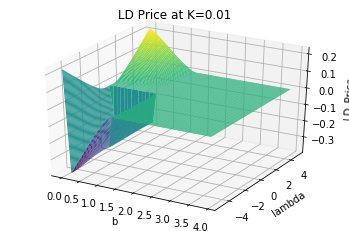

In [22]:
x_vals = np.arange(-5,5,0.1)
y_vals = np.arange(0,4,0.1)
X,Y = np.meshgrid(y_vals,x_vals)
Z = np.zeros((len(x_vals),len(y_vals)))
for i in range(len(x_vals)):
    for j in range(len(y_vals)):
        Z[i][j] = log_displaced(S0,A0,T0,strikes[0],x_vals[i],y_vals[j]) - log_displaced(S0,A0,T0,strikes[0],0.2,1)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('b')
ax.set_ylabel('lambda')
ax.set_zlabel('LD_Price')
plt.title("LD Price at K=0.01")
plt.show()

## 2.  $\bar{x}, \ \bar{y}$

In [8]:
#maturity_grid : (T0=0,...,TN) n-th swaption of the strip expires at Tn
#lmbdas : [lambda_1,...,lambda_n-1] known values of lambda 
# l : parameter for lambda_n
def y0(t,lmbdas,l,chi,maturity_grid):
    term_date = maturity_grid[-1]
    strip_size = np.size(maturity_grid)
    resu = 0
    i = 0
    while (t > maturity_grid[i]):
        Tn_m1 = maturity_grid[i]
        Tn = maturity_grid[i+1]
        mat = np.arange(Tn,term_date+0.5,0.5)
        S0 = S(0,0,0,mat,[np.exp(-r*m) for m in mat],1,chi)
        if (Tn >= t):
            resu += l**2 * S0**2 * (np.exp(-2*chi*(t-min(t,Tn))) - np.exp(-2*chi*(t-Tn_m1)))
        else:
            resu+= lmbdas[i]**2 * S0**2 * (np.exp(-2*chi*(t-Tn)) - np.exp(-2*chi*(t-Tn_m1)))
        i += 1 
    
    return resu/(2*chi)

In [9]:
y0(1.4,[0.5],1,chi,np.array([0,1,2,3]))

0.00013086334395114333

In [24]:
#First order approximation x0(t) 

def x0(t,maturities,bonds,lmbdas,l,chi,maturity_grid):
    S0 = S(0,0,0,maturities,bonds,1,chi)                
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    y = y0(t,lmbdas,l,chi,maturity_grid)
    Swap_rate = lambda x: S(t,x,y,maturities,bonds,np.exp(-r*t),chi) - S0
    dS = lambda x: q(t,x,y,maturities,bonds,np.exp(-r*t),chi)
    try:
        #return opt.newton(Swap_rate,0) # secant method 
        return opt.newton(Swap_rate,0,dS,maxiter=100,tol=1e-3)  #Newton method
    except RuntimeError:
        print("Recherche racine non convergente")
        print(maturities,bonds,lmbdas,l,chi,maturity_grid)
    break 

SyntaxError: 'break' outside loop (<ipython-input-24-6d0cfc70b785>, line 19)

In order to compute the second order approximation of $\mathbb{E}^A\big[x(t)\big]$, one needs to compute the value of $$\int_{0}^{t} \frac{\partial S}{\partial x}(s,0,0)^2 \sigma_r(s,0,0)^2 \ \mathrm{d}s = \sum_{n=1}^{N-1} \lambda_n^2 S_n(0)^2 \int_{T_{n-1}\land t}^{T_n \land t} \frac{\partial S}{\partial x}(s,0,0)^2 \ \mathrm{d}s$$

In [11]:
 #second derivative d2S/dx2
def dS2(t,x,y,maturities,bonds,ZC_t,chi):
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    PT0 = (np.exp(-r*(maturities[0]-t))*np.exp(-1*g0*x-0.5*y*g0**2))
    PTN = (np.exp(-r*(maturities[-1]-t))*np.exp(-1*gN*x-0.5*y*gN**2))
    At = A(t,x,y,maturities,bonds,ZC_t,chi)
    Aprime = A(t,x,y,maturities,bonds,ZC_t,chi,1)
    Apprime = A(t,x,y,maturities,bonds,ZC_t,chi,2)
    S_rate = S(t,x,y,maturities,bonds,ZC_t,chi)
    return (g0**2 * PT0 - gN**2 * PTN - S_rate * Apprime)/At + 2*Aprime * (Aprime*S_rate + g0*PT0 - gN*PTN)/(At**2)

#second order approximation
def x_bar(t,maturities,bonds,ZC_t,lmbdas,l,chi,maturity_grid):
    y = y0(t,lmbdas,l,chi,maturity_grid)
    x = x0(t,maturities,bonds,lmbdas,l,chi,maturity_grid)
    #second derivative d2S/dx2
    d2S = dS2(t,x,y,maturities,bonds,ZC_t,chi)
    #second derivative d2X/ds2
    dX2 = -1*d2S/(q(t,x,y,maturities,bonds,ZC_t,chi)**3)
    #Compute Var
    term_date = maturity_grid[-1]
    strip_size = np.size(maturity_grid)
    i = 0
    Var = 0
    while (t > maturity_grid[i]) & (i < strip_size-2):
        Tn_m1 = maturity_grid[i]
        Tn = maturity_grid[i+1]
        mat = np.arange(Tn,term_date+0.5,0.5)
        S0 = S(0,0,0,mat,[np.exp(-r*m) for m in mat],1,chi)
        if (i == strip_size-3):
            Var += l**2 * S0**2 * integrate.quad(lambda s:  q(s,0,0,maturities,bonds,np.exp(-r*s),chi)**2,Tn_m1,min(t,Tn))[0]
        else:
            Var += lmbdas[i]**2 * S0**2 * integrate.quad(lambda s:  q(s,0,0,maturities,bonds,np.exp(-r*s),chi)**2,Tn_m1,min(t,Tn))[0]
        i += 1 
    return x + 0.5 * dX2 * Var

In [13]:
#test
t = 1.5
lmbdas = [0.5]
l = 1
maturity_grid = [0,1,2,3]
y = y0(t,lmbdas,l,chi,maturity_grid)
maturities = np.arange(t,t+5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
x = x0(t,maturities,bonds,lmbdas,l,chi,maturity_grid)
print("x0= ",x,"S0= ",S0,"S(t,x0,y_bar)= ",S(t,x,y,maturities,bonds,np.exp(-r*t),chi))

x0=  0.0028868327579051646 S0=  0.020100334168336113 S(t,x0,y_bar)=  0.020100334155695003


In [14]:
x_bar(t,maturities,bonds,np.exp(-r*t),lmbdas,l,chi,maturity_grid)

0.0028368566576827473

## 3. $\bar{\lambda_{S_n}}, \bar{b_{S_n}}$

In [12]:
#function t -> lambda_S  in the pricing formula
def lS(t,x,y,lmbda,b,chi,maturities,bonds,ZC_t):
    S0 = S(0,0,0,maturities,bonds,1,chi)
    dS = q(t,x,y,maturities,bonds,ZC_t,chi)
    return (lmbda/S0) * dS * (S0 + b * x)

#function t -> b_S  in the pricing formula
def bS(t,x,y,b,chi,maturities,bonds,ZC_t):
    S0 = S(0,0,0,maturities,bonds,1,chi)
    dS = q(t,x,y,maturities,bonds,ZC_t,chi)
    d2S = dS2(t,x,y,maturities,bonds,ZC_t,chi)
    return (S0 * b) / ((S0 + b * x) * dS) + S0 * d2S/(dS**2)

In [13]:
# f: t -> int_0^t lambda_Sn (s)^2 ds

def f(t,maturities, bonds, maturity_grid,lmbdas, b_vals, l, b, chi):
    i = 0
    resu = 0
    while (maturity_grid[i] < t):
        #last integral with unknown parameters l,b
        if(maturity_grid[i+1] >= t):
            resu += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),l,b,chi,maturities,bonds,np.exp(-r*u))**2 ,maturity_grid[i],t)[0]
        #integrals with known parameters lambda_i, b_i
        else:
            resu += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),lmbdas[i],b_vals[i],chi,maturities,bonds,np.exp(-r*u))**2 ,maturity_grid[i],maturity_grid[i+1])[0]
        i += 1
    return resu


#maturities: payments dates of the underlying swap [Tn,...,TN]
def lambda_bar(maturities, bonds, maturity_grid,lmbdas, b_vals, l, b, chi):
    Tn = maturities[0]
    I = f(Tn,maturities, bonds, maturity_grid,lmbdas, b_vals, l, b, chi)
    return np.sqrt(I/Tn)

In [14]:
#
#index : index to use the value of lambda, b on the right interval
def phi(u,index,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi):
    y = y0(u,lmbdas,l,chi,maturity_grid)
    x = x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid)
    if (index == -1):
        return bS(u,x,y,b,chi,maturities,bonds,np.exp(-r*u)) * lS(u,x,y,l,b,chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi)
    else:
        return bS(u,x,y,b_vals[index],chi,maturities,bonds,np.exp(-r*u)) * lS(u,x,y,lmbdas[index],b_vals[index],chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi)

def b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, l, b, chi):
    Tn = maturities[0]
    i = 0
    I = 0
    Denom = 0
    while(maturity_grid[i] < Tn):
        #Last integral with unknown parameters l,b
        if(maturity_grid[i+1] == Tn):
            I += integrate.quad(lambda u: phi(u,-1,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi),maturity_grid[i],Tn)[0]
            Denom += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),l,b,chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi),maturity_grid[i],Tn)[0]
        
        #integrals with known parameters lambda_i,b_i
        else:
            I += integrate.quad(lambda u: phi(u,i,maturities,bonds,maturity_grid,lmbdas,b_vals,lmbdas[i],b_vals[i],chi),maturity_grid[i],maturity_grid[i+1])[0]
            Denom += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),lmbdas[i],b_vals[i],chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi),maturity_grid[i],maturity_grid[i+1])[0]
        i += 1
    
    return I / Denom

## Tests

In [18]:
T0 = 1/12
maturity_grid = [0,1/12,1+1/12]
maturities = np.arange(T0,1 + 1/6, 1/12)
bonds = [np.exp(-r*m) for m in maturities]
lmbdas = [0]
b_vals = [0]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
f(T0,maturities, bonds, maturity_grid,lmbdas, b_vals, 0.5, 1, chi)

0.007226524920582431

In [19]:
lambda_bar(maturities, bonds, maturity_grid,lmbdas, b_vals, 1, 1, chi)

0.5888042700104704

In [20]:
phi(T0,-1,maturities,bonds,maturity_grid,lmbdas,b_vals,0.5,0.1,chi)

0.00011417977490144632

In [21]:
b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, 1, 0.1, chi)

0.17305460953879312

In [22]:
#test calcul d'integrales
T0 = 1
maturity_grid = [0,1,6]
maturities = np.arange(T0,7,1)
bonds = [np.exp(-r*m) for m in maturities]
lmbdas = [0]
b_vals = [0]
quad_meth = f(T0,maturities, bonds, maturity_grid,lmbdas, b_vals, 0.5, 1, chi)
quad_250 = sum([lS(i/250,x_bar(i/250,maturities,bonds,np.exp(-r*i/250),lmbdas,0.5,chi,maturity_grid),y0(i/250,lmbdas,0.5,chi,maturity_grid),0.5,1,chi,maturities,bonds,np.exp(-r*i/250))**2 for i in range(1,251)])/250
quad_500 = sum([lS(i/500,x_bar(i/500,maturities,bonds,np.exp(-r*i/500),lmbdas,0.5,chi,maturity_grid),y0(i/500,lmbdas,0.5,chi,maturity_grid),0.5,1,chi,maturities,bonds,np.exp(-r*i/500))**2 for i in range(1,501)])/500
quad_1000 = sum([lS(i/1000,x_bar(i/1000,maturities,bonds,np.exp(-r*i/1000),lmbdas,0.5,chi,maturity_grid),y0(i/1000,lmbdas,0.5,chi,maturity_grid),0.5,1,chi,maturities,bonds,np.exp(-r*i/1000))**2 for i in range(1,1001)])/1000
print("Quad method Python:",quad_meth,"Quad. 250 steps:",quad_250,"Quad. 500 steps:",quad_500, "Quad. 1000 steps:",quad_1000)

Quad method Python: 0.005503784308185581 Quad. 250 steps: 0.005527026166269763 Quad. 500 steps: 0.005515397734835716 Quad. 1000 steps: 0.005509589145800115


In [70]:
quad_10000 = sum([lS(i/10000,x_bar(i/10000,maturities,bonds,np.exp(-r*i/10000),lmbdas,0.5,chi,maturity_grid),y0(i/10000,lmbdas,0.5,chi,maturity_grid),0.5,1,chi,maturities,bonds,np.exp(-r*i/10000))**2 for i in range(1,10001)])/10000
print(quad_10000)

0.005504364622897158


## 4. Calibration

### a) Simple method

The main difficulty in the calibration code is the method with which one computes the values of
$(\lambda_n,b_n)$ by making $\bar{\lambda_{S_n}},\bar{b_{S_n}}$ match with $\hat{\lambda_n},\hat{b_n}$. 
Indeed, on $]T_{n-1},T_n]$, $\bar{\lambda_{S_n}}$ and $\bar{b_{S_n}}$ depend on $\lambda_n$ and $b_n$, that's why one can't use a simple root finding. There exists a Newton algorithm in dimension 2, but it requires a Jacobian matrix and we haven't explicit formula for the derivatives with respect to $\lambda,b$ here.

One solution is to divide the problem in two parts. 
- On the one hand, one computes the value of $\lambda_n$ by approximating $\bar{x}(t) \approx 0$ on $]T_{n-1},T_n]$ in order to get an expression of $\bar{\lambda_{S_n}}$ independent of $b_n$.
$$\begin{array}{ll} 
\bar{\lambda_{S_n}} &= \Big( \frac{1}{T_n} \int_{0}^{T_n} \lambda_{S_n}(t)^2 \ \mathrm{d}t \Big)^{\frac{1}{2}} \\
&= \Big( \frac{1}{T_n} \big( \int_{0}^{T_{n-1}} \lambda_{S_n}(t)^2 \ \mathrm{d}t + \int_{T_{n-1}}^{T_n} \lambda_{S_n}(t, \lambda_n,b_n,\bar{x}(t))^2 \ \mathrm{d}t\big) \Big)^{\frac{1}{2}} \\
&\approx \Big( \frac{1}{T_n} \big( \int_{0}^{T_{n-1}} \lambda_{S_n}(t)^2 \ \mathrm{d}t + \int_{T_{n-1}}^{T_n} \lambda_{S_n}(t, \lambda_n,b_n,0)^2 \ \mathrm{d}t\big) \Big)^{\frac{1}{2}} \\
&= \big( Z_1 ((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1}) + \zeta_1(\lambda_n) \big)^{\frac{1}{2}}
\end{array}$$

- On the other hand 
$$\begin{array}{ll} 
\bar{b_{S_n}} &= \int_{0}^{T_n} b_{S_n}(t) \ w_{S_n}(t) \ \mathrm{d}t \\
&= \int_{0}^{T_{n-1}} b_{S_n}(t) w_{S_n}(t) \ \mathrm{d}t + \int_{T_{n-1}}^{T_n} b_{S_n}(t) \ w_{S_n}(t,\lambda_n,b_n) \ \mathrm{d}t \\
&= Z_2 ((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1}) + \zeta_2(\lambda_n,b_n)
\end{array}$$
And one solves this equation for $b_n$, using the computed value of $\lambda_n$ from last step.

In [15]:
# Calibration algorithm with naiv approach

def calib(data, maturity_grid, delta):
    N = len(maturity_grid) - 1
    term_date = maturity_grid[-1]
    lmbdas = np.zeros(N-1)
    b_vals = np.zeros(N-1)
    for n in range(0,N-1):
        maturities = np.arange(maturity_grid[n+1],term_date + delta, delta)
        bonds = [np.exp(-r*m) for m in maturities]
        
        #Root finding for lambda_n
        lambda_obs = data[n][0]
        lambda_n = opt.bisect(lambda l: lambda_bar(maturities, bonds, maturity_grid,lmbdas, b_vals, l, 0, chi) - lambda_obs,0,10)
        lmbdas[n] = lambda_n
        
        #Root finding for b_n
        b_obs = data[n][1]
        b_n = opt.bisect(lambda b: b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, lambda_n, b, chi) - b_obs, 0 , 10)
        b_vals[n] = b_n
    return lmbdas,b_vals

### Calibration with data fitted on Prices

In [31]:
#test calibration
maturity_grid = [0,1/12,1+1/12]
strikes = [0.01,0.02,0.03,0.04,0.05,0.07,0.1,0.12]
IV = [[0.528341118,0.248871904,0.315791907,0.392419764,0.447727552,0.524478308,0.59765607,0.631982811]]
delta = 1/12
data = data_set(maturity_grid,strikes,IV,chi,delta,0.208871904)
calib_param = calib(data, maturity_grid, delta)
print("(lambda_1,b_1) =",calib_param)

(lambda_1,b_1) = (array([0.40886754]), array([0.61506426]))


[-1.2481475679393395e-09, -2.016785058386178e-05, -2.2314572573491027e-09, -2.632649917050416e-13, -4.187083086441031e-16, -4.8079361321683474e-20, -4.8454030684463324e-24, -4.5375142126633257e-26]


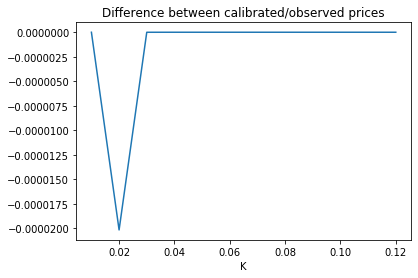

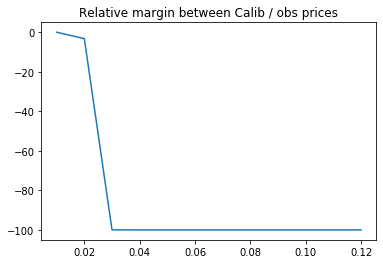

In [42]:
# Plot of the price difference between observed prices and thus with calibrated parameters

calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print(d)
plt.show()
d2 = [100*d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relative margin between Calib / obs prices")
plt.show()

### Calibration with data fitted on implied volatility

In [43]:
data2 = data_set_bis(maturity_grid,strikes,IV,chi,delta,[0.208871904])
calib_param = calib(data2, maturity_grid, delta)
print("(lambda_1,b_1) =",calib_param)

(lambda_1,b_1) = (array([0.34448076]), array([3.34053436]))


[-1.2481475714087864e-09, -0.00011466226363950646, 1.0903655526055525e-08, 2.1126167734490094e-12, 1.888083148712934e-15, -5.274603086103055e-21, -4.632123735812821e-24, -4.5066321209403197e-26]


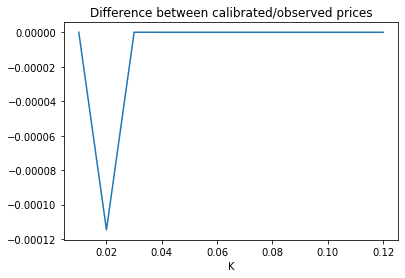

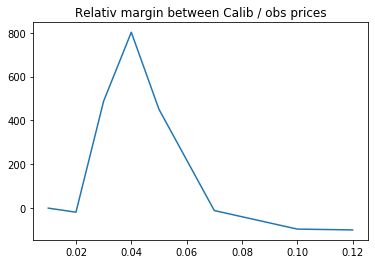

In [44]:
# Plot of the price difference between observed prices and thus with calibrated parameters

calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print(d)
plt.show()
d2 = [100*d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
plt.show()

### Calibration with data fitted on prices' relative margin

In [17]:
def data_set_tiers(maturity_grid,strikes,IV,chi,delta,iv_atm):
    term_date = maturity_grid[-1]
    res = np.zeros((len(maturity_grid)-2,2))
    for i in range(1,len(maturity_grid)-1):
        T0 = maturity_grid[i]
        maturities = np.arange(T0,term_date + delta,delta)
        bonds = [np.exp(-r*m) for m in maturities]
        A0 = A(0,0,0,maturities,bonds,1,chi)
        S0 = S(0,0,0,maturities,bonds,1,chi)
        fun = lambda x: np.array([(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]) - Price_BS(S0,A0,T0,strikes[m],IV[i-1][m]))/(Price_BS(S0,A0,T0,strikes[m],IV[i-1][m])) for m in range(len(strikes))])
        x_0 = np.array([iv_atm,1])
        opt_param = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,10])).x
        res[i-1] = opt_param
    return res

In [66]:
data3 = data_set_tiers(maturity_grid,strikes,IV,chi,delta,0.208871904)
calib_param = calib(data3, maturity_grid, delta)
print("(lambda_1,b_1) =",calib_param)

(lambda_1,b_1) = (array([0.22543661]), array([6.24178456]))


[-1.2481475714087864e-09, -0.0002868124542029297, -1.1442945149157934e-09, 1.94929181169631e-16, 9.405797332737365e-17, -3.425231575575314e-21, -2.9639535359504324e-24, -3.5769360766805963e-26]


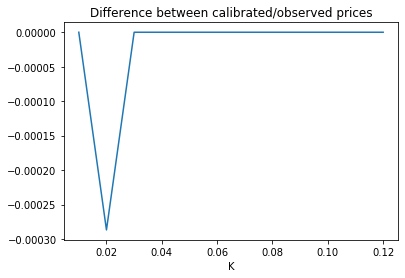

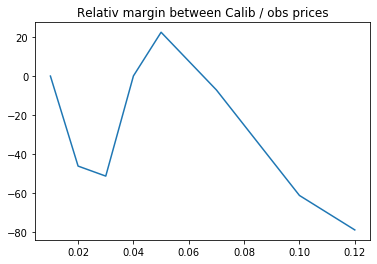

In [67]:
# Plot of the price difference between observed prices and thus with calibrated parameters

calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print(d)
plt.show()
d2 = [100*d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
plt.show()

### b) Calibration par minimisation sur $\bar{\lambda},\bar{b}$

Ici l'objectif de la fonction de calibration est de trouver une valeur pour $(\lambda_n,b_n)$ à chaque étape $n$ en minimisant la fonction $$(\lambda_n,b_n) \rightarrow \lVert \big(\bar{\lambda}(\lambda_n,b_n), \bar{b}(\lambda_n,b_n) \big) - \big(\hat{\lambda},\hat{b} \big) \rVert ^2 = \big(\bar{\lambda}(\lambda_n,b_n) - \hat{\lambda} \big)^2 + \big(\bar{b}(\lambda_n,b_n) - \hat{b} \big)^2$$

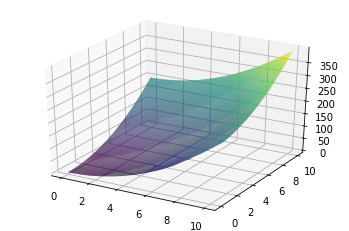

array([2.05649609e-05, 2.46854500e-05])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 81


In [68]:
# test function minimization with 2 variables

fun = lambda x: (x[0] - x[1])**2 + (x[0] + x[1])**2

x_vals = np.arange(0,10,0.01)
X,Y = np.meshgrid(x_vals,x_vals)
Z = np.zeros((len(x_vals),len(x_vals)))
for i in range(len(x_vals)):
    for j in range(len(x_vals)):
        Z[i][j] = fun([x_vals[i],x_vals[j]])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
plt.show()

opt.fmin(fun,[1,0])

In [16]:
def calib2(data, maturity_grid, delta, exec_time=False):
    t1 = time()
    N = len(maturity_grid) - 1
    term_date = maturity_grid[-1]
    lmbdas = np.zeros(N-1)
    b_vals = np.zeros(N-1)
    for n in range(0,N-1):
        print("Step " + str(n))
        t3 = time()
        maturities = np.arange(maturity_grid[n+1],term_date + delta, delta)
        bonds = [np.exp(-r*m) for m in maturities]
        lambda_obs = data[n][0]            
        b_obs = data[n][1]
        
        # optimization step
        
        fun = lambda x: (lambda_bar(maturities, bonds, maturity_grid,lmbdas, b_vals, x[0], x[1], chi) - lambda_obs)**2 + (b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, x[0], x[1], chi) - b_obs)**2
        opt_param = opt.fmin(fun,[1,1])
        lmbdas[n] = opt_param[0]
        b_vals[n] = opt_param[1]
        t4 = time()
        if(exec_time):
            print(t4-t3, "sec")
    
    t2 = time()
    if(exec_time):
        print("Exec. time:",t2-t1, "sec")
    return lmbdas,b_vals

In [ ]:
## Calibration with Data fitted on prices

calib_param2 = calib2(data,maturity_grid,delta)
print(calib_param2)

[-1.248147569674063e-09, -2.066267821090352e-05, -2.231489430913526e-09, -2.632649917050421e-13, -4.187083086441031e-16, -4.8079361321683474e-20, -4.8454030684463324e-24, -4.5375142126633257e-26]


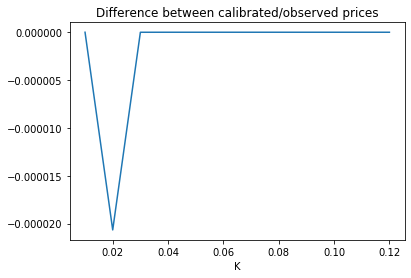

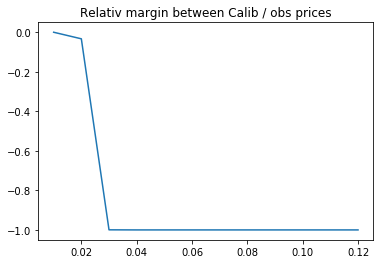

In [71]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param2[0][0], calib_param2[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param2[0][0], calib_param2[1][0], chi)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print(d)
plt.show()
d2 = [d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
plt.show()

In [72]:
calib_param2 = calib2(data2,maturity_grid,delta)
print(calib_param2)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 100
(array([-0.34294043]), array([3.34052631]))


[-1.2481475714087864e-09, -0.000116869546125307, 9.816128594677746e-09, 1.7585192901595885e-12, 1.4274818579357835e-15, -1.6992123576779254e-20, -4.706561232264098e-24, -4.518557101483728e-26]


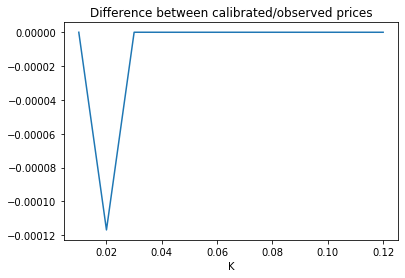

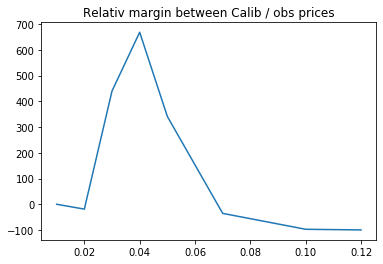

In [73]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param2[0][0], calib_param2[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param2[0][0], calib_param2[1][0], chi)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print(d)
plt.show()
d2 = [100*d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
plt.show()

### c) Calibration sur $\bar{b}$ uniquement

**1.Relation entre $\lambda$ et $b$ pour tous les strikes**

On veut $$V_0^{LD} \big(\bar{\lambda}, \bar{b}, S_0, K \big) = V_0^{BS} \big(S_0,K,\hat{\sigma} \big)$$

Si on pose $\psi_{b,S,K} : \lambda \rightarrow V_0^{LD} \big(\lambda, b, S, K \big)$, supposée continue et inversible.

Alors on a: $$\begin{array}{ll} 
\bar{\lambda} &= \psi_{\bar{b},S_0,K}^{-1} \Big(V_0^{BS} \big(S_0,K,\hat{\sigma} \big) \Big) \\
&= f \Big(\bar{b},S_0,K, \hat{\sigma} \Big) \end{array}$$


La nième étape de calibration consistera donc à minimiser la fonction $$(\lambda_n,b_n) \rightarrow \Big( \bar{b}(\lambda_n,b_n) - \hat{b}_n \Big)^2$$

La base de donnée à partir de laquelle on va calibrer le modèle deviendra donc $(\hat{b}_i)_{i=1,N}$.

Lorsque l'on construit cette base de donnée, on veut dans le cas idéal un couple $(\lambda,b)$ tel que: $$V_0^{LD}(S_0,K,\lambda,b) = V_0^{BS}(S_0,K,\hat{\sigma})$$

On va noter $\phi_{S,K,b} : \lambda \rightarrow V_0^{LD}(S,K,\lambda,b)$

Donc $$\begin{array}{ll}
\phi_{S_0,K,b} (\lambda) &= V_0^{BS}(S_0,K,\hat{\sigma}) \\
\implies \lambda &= \phi_{S_0,K,b}^{-1} \Big(V_0^{BS}(S_0,K,\hat{\sigma}) \Big) \\
&= \tilde{f} (b, S_0, K, \hat{\sigma})
\end{array}$$

On se propose donc d'appliquer la méthode des moindres carrées sur les quantités suivantes:
$$\forall K_i, \quad V_0^{LD}\big(S_0,K_i,\tilde{f}(b,S_0, K_i,\hat{\sigma}),b\big) - V_0^{BS}(S_0,K_i,\hat{\sigma})$$

Dans le code, on calcule $\tilde{f}(b,S_0, K_i,\hat{\sigma})$ de la manière suivante:
$$\tilde{f}(b,S_0, K_i,\hat{\sigma}) = bisect \Big( x \rightarrow \sigma_{Imp} \big(V_0^{LD}(S_0,K_i,x,b) \big) - \hat{\sigma} \Big)$$

Cela conduit à des calculs numériques et des erreurs supplémentaires.

**2. Relation entre $\lambda$ et $b$ à la monnaie** 

Il est possible de trouver une relation explicite entre $\lambda$ et $b$ qui est exacte à la monnaie mais pas pour tous les strikes. 

Soit $T_0$ fixée. On suppose $S_0 = K$ et on note $\hat{\sigma}$ la volatilité implicite à la monnaie.

D'une part, $$\begin{array}{ll}
V_0^{BS}(S_0,S_0,T_0,\hat{\sigma}) &= A(0) S_0 \Big(\Phi \big( \frac{\hat{\sigma}\sqrt{T_0}}{2}\big) - \Phi \big( \frac{- \hat{\sigma}\sqrt{T_0}}{2}\big) \Big) \\
&= A(0) S_0 \Big( 2 \Phi \big( \frac{\hat{\sigma}\sqrt{T_0}}{2}\big) - 1 \Big)
\end{array}$$

D'autre part, $$\begin{array}{ll}
V_0^{LD}(S_0,S_0,T_0,\lambda,b) &= A(0) \frac{S_0}{b} \Big(\Phi \big( \frac{\lambda b \sqrt{T_0}}{2}\big) - \Phi \big( \frac{- \lambda b \sqrt{T_0}}{2}\big) \Big) \\
&= A(0) \frac{S_0}{b} \Big( 2 \Phi \big( \frac{\lambda b \sqrt{T_0}}{2}\big) - 1 \Big)
\end{array}$$

Donc $$\begin{array}{ll}
V_0^{LD}(S_0,S_0,\lambda,b) &= V_0^{BS}(S_0,K,\hat{\sigma}) \\
\iff \frac{1}{b} \Big( 2 \Phi \big( \frac{\lambda b \sqrt{T_0}}{2}\big) - 1 \Big) &= \Big( 2 \Phi \big( \frac{\hat{\sigma}\sqrt{T_0}}{2}\big) - 1 \Big) \\
\iff \Phi \big( \frac{\lambda b \sqrt{T_0}}{2}\big) &= b \Phi \big( \frac{\hat{\sigma}\sqrt{T_0}}{2}\big) + \frac{1}{2} (1-b)
\end{array}$$

Et on a finalement $$\boxed{\lambda = \frac{2}{b \sqrt{T_0}} \Phi^{-1} \Big(b \Phi \big( \frac{\hat{\sigma}\sqrt{T_0}}{2}\big) + \frac{1}{2} (1-b) \Big) = \psi(T_0,b,\hat{\sigma})}$$

On se propose alors de construire un data set $(\hat{b}_i)_i$ en appliquant la méthode des moindres carrés aux quantités suivantes $$\forall K_i, \quad \sigma_{imp} \Big( V_0^{LD} \Big(S_0,K_i,T_0, \psi \big(T_0,b,\hat{\sigma} \big),b \Big) \Big) - \hat{\sigma}(K_i)$$

Maintenant que les paramètres d'entrée sont disponibles, il reste à calibrer les paramètres de volatilité du modèle de Cheyette $(\lambda_n,b_n)_{n=1,N-1}$ de telle sorte que 
$$\forall n \in [|1,N-1|], \quad (\lambda_n,b_n) = argmin_{\lambda,b} \big(\bar{b}(\lambda,b) - \hat{b}_n \big)^2$$

Une fois la calibration achevée, il est possible d'évaluer les prix de swaption dans notre modèle à l'aide des paramètres obtenus. Pour un swaption qui expire à $T_n$, on doit calculer le premier paramètre $\bar{b}\big((\lambda_i,b_i)_{i=1,n}\big)$. Quant au second paramètre $\bar{\lambda}$, on le calcule grâce à la relation $$\bar{\lambda} = \psi \big(T_n, \hat{\sigma}_{ATM}, \bar{b}\big((\lambda_i,b_i)_{i=1,n}\big) \big)$$

In [18]:
#function b, sigma_imp_ATM -> lambda

def psi(T0,sigma_imp,b):
    return 2 / (b * np.sqrt(T0)) * stats.norm.ppf(b * stats.norm.cdf(0.5 * sigma_imp * np.sqrt(T0)) + 0.5 * (1-b))

# Construction of the data set on b only

def data_b(maturity_grid,strikes,IV,chi,delta,iv_atm,iv_model):
    term_date = maturity_grid[-1]
    res = np.zeros((len(maturity_grid)-2,1))
    for i in range(1,len(maturity_grid)-1):
        T0 = maturity_grid[i]
        maturities = np.arange(T0,term_date + delta,delta)
        bonds = [np.exp(-r*m) for m in maturities]
        A0 = A(0,0,0,maturities,bonds,1,chi)
        S0 = S(0,0,0,maturities,bonds,1,chi)
        fun = lambda x: np.array([(biss_python(log_displaced(S0,A0,T0,strikes[m],psi(T0,iv_atm,x),x), bonds, strikes[m], maturities,iv_model) - IV[i-1][m]) for m in range(len(strikes))])
        x_0 = np.array([iv_atm])
        opt_param = opt.least_squares(fun,x_0, bounds=([0], [25]),gtol=5e-16).x
        res[i-1] = opt_param
    return res

def calib3(data, maturity_grid, delta):
    N = len(maturity_grid) - 1
    term_date = maturity_grid[-1]
    lmbdas = np.zeros(N-1)
    b_vals = np.zeros(N-1)
    for n in range(0,N-1):
        maturities = np.arange(maturity_grid[n+1],term_date + delta, delta)
        bonds = [np.exp(-r*m) for m in maturities]
        b_obs = data[n][0]
        
        # optimization step
        
        fun = lambda x: (b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, x[0], x[1], chi) - b_obs)**2 
        opt_param = opt.fmin(fun,[1,1])
        lmbdas[n] = opt_param[0]
        b_vals[n] = opt_param[1]
        
    return lmbdas,b_vals

In [32]:
data_b_only = data_b(maturity_grid,strikes,IV,chi,delta,IV[0][1])
print("b_obs=",data_b_only)

b_obs= [[0.4144405]]


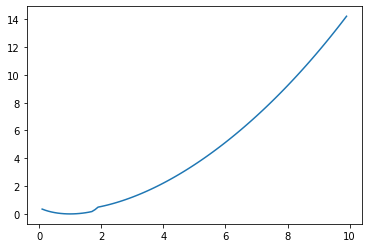

In [34]:
x_vals = np.arange(0.1,10,0.1)
y = [sum([(biss_python(log_displaced(S0,A0,T0,strikes[m],psi(T0,IV[0][m],x),x), bonds, strikes[m], maturities) - IV[0][m])**2 for m in range(len(strikes))]) for x in x_vals]
plt.plot(x_vals,y)

In [35]:
calib_param3 = calib3(data_b_only, maturity_grid, delta)
print("(lambda1,b1)=",calib_param3)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 69
         Function evaluations: 127
(lambda1,b1)= (array([1.12725317]), array([0.25293573]))


Absolute diff. [-1.2481475714087864e-09, 1.457894324135428e-07, -2.232486507094902e-09, -2.6326499170504765e-13, -4.187083086441031e-16, -4.8079361321683474e-20, -4.8454030684463324e-24, -4.5375142126633257e-26]


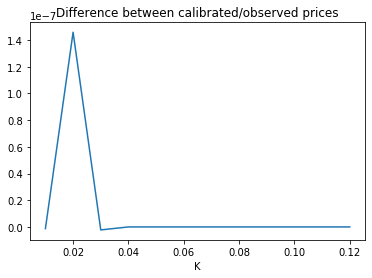

Relative diff. [-1.1656342621711716e-05, 0.023444123431274243, -99.99819222085962, -100.0, -100.0, -100.0, -100.0, -100.0]


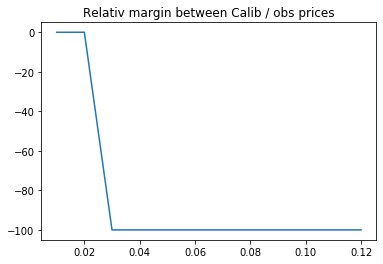

In [36]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param3[0][0], calib_param3[1][0], chi)
calib_lambda_bar = psi(T0,IV[0][1],calib_b_bar) # lambda bar = psi (b_bar) with ATM Implied vol.
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print("Absolute diff.",d)
plt.show()
d2 = [100*d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
print("Relative diff.",d2)
plt.show()

## Test sanitaire sur des prix log-normaux décalés

### Calibration sur $\bar{b}$

In [59]:
# Sanitary test on displaced log normal prices 
l = 0.5
b = 0.9

maturity_grid = [0,1,6]
T0 = 1
term_date = 6
delta = 1
maturities = np.arange(T0,term_date + delta,delta)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
A0 = A(0,0,0,maturities,bonds,1,chi)
strikes = [0.1*k*S0 for k in range(5,16)] # 50% to 150% of the strike ATM

# Data
IV = [[biss_python(log_displaced(S0,A0,T0,strikes[m],l,b), bonds, strikes[m], maturities) for m in range(len(strikes))]]
slope_atm = abs((IV[0][6] - IV[0][4])/0.2*S0)
data = data_b(maturity_grid,strikes,IV,chi,delta,IV[0][5])
print("starting pt. = ",IV[0][5],"b_obs=",data)

starting pt. =  0.5010039084265827 b_obs= [[0.9]]


In [38]:
# Calibration
calib_param = calib3(data, maturity_grid, delta)
print("(lambda_Pit.,b_Pit.)=",calib_param)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 81
(lambda_Pit.,b_Pit.)= (array([1.16962589]), array([0.14103542]))


Lambda_bar, b_bar =  0.49999999786996324 0.8999997750011356
Absolute diff. [5.214754045246295e-10, 5.87477948232884e-10, 5.407396821976995e-10, 4.0218874758357614e-10, 2.0953478535590264e-10, 3.046868313205664e-14, -1.9798233885648386e-10, -3.670172776804037e-10, -4.989945921740624e-10, -5.926329565975053e-10, -6.508836629393056e-10]


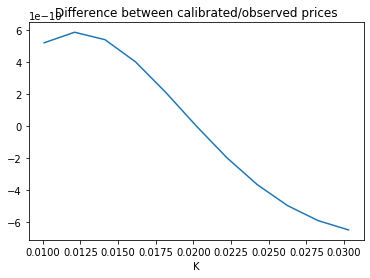

In [40]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = psi(T0,IV[0][5],calib_b_bar) # lambda bar = psi (b_bar) with ATM Implied vol.
print("Lambda_bar, b_bar = ",calib_lambda_bar,calib_b_bar)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - log_displaced(S0,A0,T0,strikes[m],l,b) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print("Absolute diff.",d)
plt.show()

Relative diff. in % [1.084264059051313e-06, 1.4534730539481777e-06, 1.6092304303364746e-06, 1.4524095136763246e-06, 9.245719430756051e-07, 1.651373455113398e-10, -1.3231304496611733e-06, -3.032662312519226e-06, -5.106943889337872e-06, -7.5198880013804285e-06, -1.024358056907724e-05]


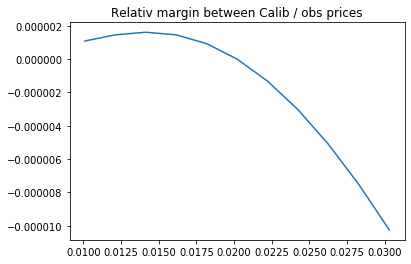

In [41]:
d2 = [100*d[m]/log_displaced(S0,A0,T0,strikes[m],l,b) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
print("Relative diff. in %",d2)
plt.show()

### Calibration sur $\bar{\lambda},\bar{b}$

In [60]:
#Data
data = data_set_bis(maturity_grid,strikes,IV,chi,delta,[IV[0][5]])
print("(lambda_LD,b_LD) Observed:",data)

(lambda_LD,b_LD) Observed: [[0.5 0.9]]


In [61]:
# Calibration
calib_param = calib2(data,maturity_grid,delta,True)
print("(lambda_Pit.,b_Pit.)=",calib_param)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 117
Exec. time: 396.5330698490143 sec
(lambda_Pit.,b_Pit.)= (array([3.6437048]), array([0.1391929]))


lambda_bar, b_bar = 0.4999952467575068 0.9000058993005275
Absolute diff. [-6.721210569354819e-08, -1.0076589281732273e-07, -1.309160102963558e-07, -1.5390739482867843e-07, -1.683269985272573e-07, -1.7448665853153633e-07, -1.7366762349035891e-07, -1.6752034962680407e-07, -1.576824114613018e-07, -1.4557947415963501e-07, -1.3235062998329106e-07]


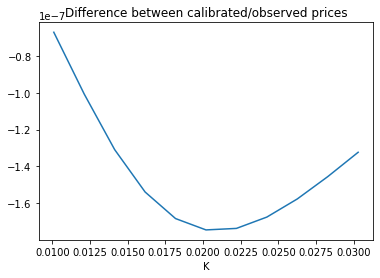

In [52]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
print("lambda_bar, b_bar =",calib_lambda_bar,calib_b_bar)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - log_displaced(S0,A0,T0,strikes[m],l,b)  for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print("Absolute diff.",d)
plt.show()

Relative diff. in % [-0.0001397490081111399, -0.0002493038426507031, -0.0003896034164367367, -0.0005558001456215761, -0.0007427426421636232, -0.0009457009839301354, -0.0011606334286562577, -0.0013842199857840058, -0.001613795500588219, -0.0018472501888277873, -0.0020829288224559327]


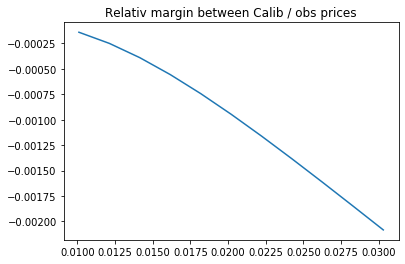

In [53]:
d2 = [100*d[m]/log_displaced(S0,A0,T0,strikes[m],l,b) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
print("Relative diff. in %",d2)
plt.show()

IV diff.  [-6.35571723e-06 -5.89495812e-06 -5.54160124e-06 -5.26050144e-06
 -5.03057890e-06 -4.83835947e-06 -4.67480277e-06 -4.53360826e-06
 -4.41022848e-06 -4.30129376e-06 -4.20425749e-06]


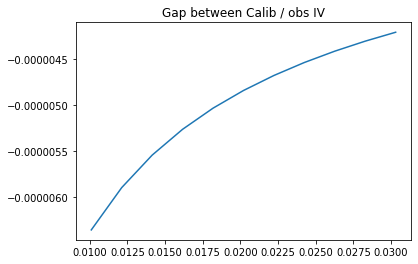

In [54]:
d_vol = np.array([biss_python(log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar), bonds, strikes[m], maturities) for m in range(len(strikes))]) - np.array(IV[0])
plt.plot(strikes,d_vol)
plt.title("Gap between Calib / obs IV")
print("IV diff. ",d_vol)
plt.show()

### Dim. 2

In [17]:
# Sanitary test on displaced log normal prices with 2 maturities 1Y, 2Y 
l = [0.7,0.4]
b = [0.5,0.9]

maturity_grid = [0,1,2,6]
term_date = maturity_grid[-1]
delta = 1
IV = np.zeros((len(maturity_grid)-2,11))

#DATA

for i in range(1,len(maturity_grid)-1):
    T0 = maturity_grid[i]
    maturities = np.arange(T0,term_date + delta,delta)
    bonds = [np.exp(-r*m) for m in maturities]
    S0 = S(0,0,0,maturities,bonds,1,chi)
    A0 = A(0,0,0,maturities,bonds,1,chi)
    strikes = [0.1*k*S0 for k in range(5,16)] # 50% to 150% of the strike ATM
    IV[i-1] = [biss_python(log_displaced(S0,A0,T0,strikes[m],l[i-1],b[i-1]), bonds, strikes[m], maturities) for m in range(len(strikes))]

data = data_set_bis(maturity_grid,strikes,IV,chi,delta,IV[:,5],[1,1])
print("lambda_obs, b_obs=",data)

lambda_obs, b_obs= [[0.7        0.50000001]
 [0.4        0.9       ]]


In [18]:
# Calibration
calib_param = calib2(data,maturity_grid,delta)
print("(lambda_Pit.,b_Pit.)=",calib_param)

Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 111
Step 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 60
         Function evaluations: 114
(lambda_Pit.,b_Pit.)= (array([5.10895538, 2.74993414]), array([0.07163892, 0.14693124]))


In [19]:
maturities1 = np.arange(maturity_grid[1],term_date + delta,delta)
bonds1 = [np.exp(-r*m) for m in maturities1]
maturities2 = np.arange(maturity_grid[2],term_date + delta,delta)
bonds2 = [np.exp(-r*m) for m in maturities2]

calib_b_bar1 = b_bar(maturities1, bonds1, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar1 = lambda_bar(maturities1, bonds1, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_b_bar2 = b_bar(maturities2, bonds2, maturity_grid, [calib_param[0][0]], [calib_param[1][0]], calib_param[0][1], calib_param[1][1], chi)
calib_lambda_bar2 = lambda_bar(maturities2, bonds2, maturity_grid,[calib_param[0][0]], [calib_param[1][0]], calib_param[0][1], calib_param[1][1], chi)
print("lambda_bar1, b_bar1 =",calib_lambda_bar1,calib_b_bar1)
print("lambda_bar2, b_bar2 =",calib_lambda_bar2,calib_b_bar2)

lambda_bar1, b_bar1 = 0.6999977271068762 0.4999932053029683
lambda_bar2, b_bar2 = 0.39999636072737693 0.8999989585309146


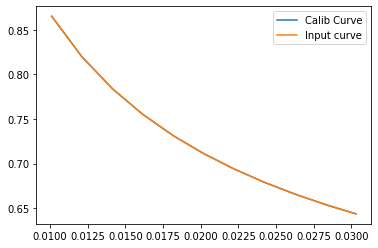

Diff max: 2.9887223718105815e-06


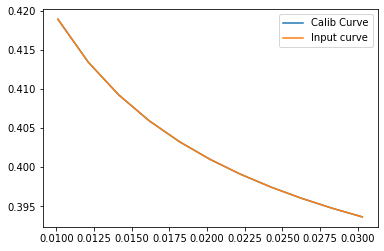

Diff max: 3.6639107747760136e-06


In [24]:
T0 = 1
maturities = np.arange(T0,7,1)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
A0 = A(0,0,0,maturities,bonds,1,chi)
prix = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar1,calib_b_bar1)  for m in range(len(strikes))]
IV_LD = [biss_python(prix[m], bonds1, strikes[m], maturities1) for m in range(len(strikes))]

plt.plot(strikes,IV_LD,label='Calib Curve')
plt.plot(strikes,IV[0],label='Input curve')
plt.legend()
plt.show()
print("Diff max:", np.max(np.array(IV[0])-np.array(IV_LD)))

S0 = S(0,0,0,maturities2,bonds2,1,chi)
A0 = A(0,0,0,maturities2,bonds2,1,chi)
prix = [log_displaced(S0,A0,2,strikes[m],calib_lambda_bar2,calib_b_bar2)  for m in range(len(strikes))]
IV_LD = [biss_python(prix[m], bonds2, strikes[m], maturities2) for m in range(len(strikes))]

plt.plot(strikes,IV_LD,label='Calib Curve')
plt.plot(strikes,IV[1],label='Input curve')
plt.legend()
plt.show()
print("Diff max:", np.max(np.array(IV[1])-np.array(IV_LD)))

## Test sanitaire sur des prix Monte Carlo

### Calibration sur $\bar{b}$

In [42]:
lambda_Cheyette = 0.2
b_Cheyette = 0.5

N,M = 250,100000
maturity_grid = [0,1,6]
T0 = 1
term_date = 6
delta = 1
maturities = np.arange(T0,term_date + delta,delta)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
A0 = A(0,0,0,maturities,bonds,1,chi)
strikes = [0.1*k*S0 for k in range(5,16)] # 50% to 150% of the strike ATM

# Data
sim = simul(lambda_Cheyette,S0,b_Cheyette,chi,T0,N,M,scheme = "Euler")
Prices = [swaption_MC(M,sim,k,chi,bonds,maturities) for k in strikes]
IV = [[biss_python(Prices[m], bonds, strikes[m], maturities) for m in range(len(strikes))]]

In [43]:
data = data_b(maturity_grid,strikes,IV,chi,delta,IV[0][5])
print("b_obs=",data)

b_obs= [[0.02744745]]


In [44]:
# Calibration
calib_param = calib3(data, maturity_grid, delta)
print("(lambda_Pit.,b_Pit.)=",calib_param)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 62
         Function evaluations: 113
(lambda_Pit.,b_Pit.)= (array([1.22806827]), array([-0.00801596]))


lambda_bar, b_bar = 0.027446863014474906 0.027447447571818155
Absolute diff. [-7.84900120481824e-07, -8.336558718416431e-07, -8.82411621615925e-07, -9.311673708697898e-07, -8.994723640267516e-07, 3.421980580842199e-14, -5.039203601514708e-07, 6.272674914727758e-17, 1.5708144212682237e-31, 1.1598839518616042e-51, 2.5551985372957997e-77]


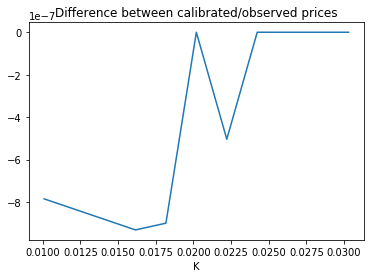

In [47]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = psi(T0,IV[0][5],calib_b_bar)
print("lambda_bar, b_bar =",calib_lambda_bar,calib_b_bar)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Prices[m]  for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print("Absolute diff.",d)
plt.show()

Relative diff. in % [-0.00168289397428964, -0.0022342758508011517, -0.0031532321271304014, -0.004991094007960319, -0.0096418817665615, 3.350382897755141e-09, -85.46435664421, inf, inf, inf, inf]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


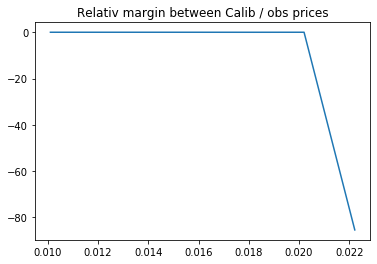

In [48]:
d2 = [100*d[m]/Prices[m] for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
print("Relative diff. in %",d2)
plt.show()

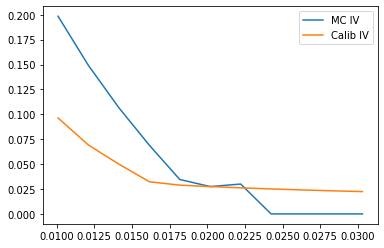

In [50]:
IV_calib = [biss_python(log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar), bonds, strikes[m], maturities) for m in range(len(strikes))]
plt.plot(strikes,IV[0],label='MC IV')
plt.plot(strikes, IV_calib,label='Calib IV')
plt.legend()
plt.show()

Avec des données d'entrée générés par la méthode Monte Carlo, la calibration assure que les courbes de volatilité implicite sont proches autour de la monnaie mais pas nécessairement ITM ou OTM.

### Calibration sur $\bar{\lambda},\bar{b}$

In [44]:
data = data_set_bis(maturity_grid,strikes,IV,chi,delta,[IV[0][5]])
print("lambda_LD_obs, b_LD_obs =",data)

lambda_LD_obs, b_LD_obs = [[0.02692019 1.        ]]


In [34]:
# Calibration
calib_param = calib2(data,maturity_grid,delta)
print("(lambda_Pit.,b_Pit.)=",calib_param)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 104
(lambda_Pit.,b_Pit.)= (array([0.19614808]), array([0.15862879]))


lambda_bar, b_bar = 0.0272781728632771 0.9999950450544318
Absolute diff. [1.2175146464780962e-05, 1.2355079453851836e-05, 1.253501244405375e-05, 1.2714945434040559e-05, 1.292633612394109e-05, -2.8790785549896725e-09, -3.2217851569039173e-07, 4.658172244848645e-15, 9.904075947103164e-26, 7.082588083121533e-39, 5.85602272555823e-54]


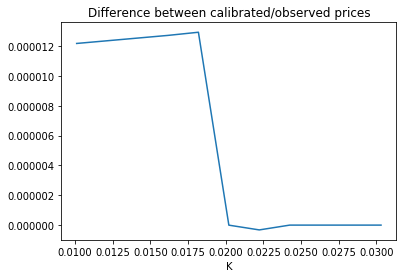

In [36]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
print("lambda_bar, b_bar =",calib_lambda_bar,calib_b_bar)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Prices[m]  for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print("Absolute diff.",d)
plt.show()

Relative diff. in % [0.02611182643058588, 0.03312447914283062, 0.04481441900976024, 0.06820249722520116, 0.13877010150578262, -0.00028363516739905996, -66.843217953877, inf, inf, inf, inf]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


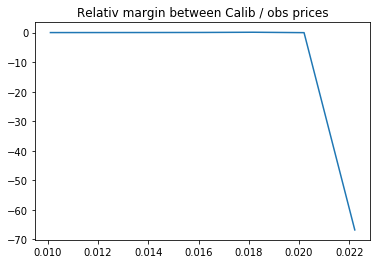

In [38]:
d2 = [100*d[m]/Prices[m] for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
print("Relative diff. in %",d2)
plt.show()

In [ ]:
IV_calib = [biss_python(log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar), bonds, strikes[m], maturities) for m in range(len(strikes))]
plt.plot(strikes,IV[0],label='MC IV')
plt.plot(strikes, IV_calib,label='Calib IV')
plt.legend()
plt.show()

( Erreur pour les strikes car les derniers prix MC sont évalués à 0 )

**Remarque:** L'algorithme de calibration utilisé a pour objectif de reproduire les prix observés grâce à la formule de pricing par approximation displaced log normale. Il n'est donc pas adapté à la reproduction des prix avec la méthode de Monte Carlo.

---
# Tests bilatéraux


In [19]:
# l,b : parameters of the displaced log-normal model in input
# method : 1 for optimization on lambda_bar,b_bar / otherwise optimization on b_bar
# iv_model: model to compute IV curves

def test(l,b, method=1, iv_model= "log-normal"):
    print("Test for (l,b)=",l,b)
    N,M = 250,100000
    maturity_grid = [0,3,6]
    T0 = 3
    term_date = 6
    delta = 1
    maturities = np.arange(T0,term_date + delta,delta)
    bonds = [np.exp(-r*m) for m in maturities]
    S0 = S(0,0,0,maturities,bonds,1,chi)
    A0 = A(0,0,0,maturities,bonds,1,chi)
    strikes = [0.1*k*S0 for k in range(5,16)] # 70% to 130% of the strike ATM
    
    #IV log_displaced (l,b)
    prix_LD = [log_displaced(S0,A0,T0,strikes[m],l,b)  for m in range(len(strikes))]
    IV_LD = [biss_python(prix_LD[m], bonds, strikes[m], maturities,iv_model) for m in range(len(strikes))]
        
    if(method==1):
        #IV Monte Carlo
        calib_param = calib2([[l,b]],maturity_grid,delta)
        lambda_Chey, b_Chey = calib_param[0][0], calib_param[1][0]
        print("lambda_Chey, b_Chey =",lambda_Chey,b_Chey)

        sim = simul(lambda_Chey,S0,b_Chey,chi,T0,N,M,scheme = "Euler")
        Prices = [swaption_MC(M,sim,k,chi,bonds,maturities) for k in strikes]
        IV = [[biss_python(Prices[m], bonds, strikes[m], maturities,iv_model) for m in range(len(strikes))]]
        
        diff = np.array(IV[0]) - np.array(IV_LD)

        
        # Delete points where IC MC = 0
        null_index = np.where(np.array(IV[0]) == 0)
        strikes = np.delete(strikes,null_index)
        IV = [np.delete(IV[0],null_index)]
        IV_LD = np.delete(IV_LD,null_index)
        
        # Fitted log displaced curve
        slope_atm = abs((biss_python(swaption_MC(M,sim,0.95*S0,chi,bonds,maturities), bonds, 0.95*S0, maturities,iv_model) - biss_python(swaption_MC(M,sim,1.05*S0,chi,bonds,maturities), bonds, 1.05*S0, maturities,iv_model))/(0.1*S0))
        print("slope ATM:",slope_atm)
        if(slope_atm > 5):
            slope_atm = 1
        data = data_set_bis(maturity_grid,strikes,IV,chi,delta,[IV[0][4]],[slope_atm], iv_model)
        print("Param_LD = ",data)
        
        prix_approxLD = [log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1])  for m in range(len(strikes))]
        IV_approxLD = [biss_python(prix_approxLD[m], bonds, strikes[m], maturities,iv_model) for m in range(len(strikes))]
        
        # Plot IV curves
        plt.plot(strikes,IV_approxLD,label='approx Log-displaced')
        plt.plot(strikes,IV[0],label='MC')
        plt.plot(strikes,IV_LD,label='LD (' + str(l) + ',' + str(b) + ')')
        plt.xlabel("K")
        plt.legend()
        plt.show()

        #print diff ATM
        print("Diff ATM (MC - approx Log-displaced)",IV[0][4] - IV_approxLD[4])
        print("Diff ATM (MC - LD(l,b)) =",diff[5])

        #print diff max
        print("Diff. max |MC - approx Log-displaced|",max(np.absolute(np.array(IV[0])-np.array(IV_approxLD))))
        print("Diff. max |MC- LD(l,b)| =",max(np.absolute(np.array(IV[0])-np.array(IV_LD))))
        
    else:
        #IV Monte Carlo
        data = data_b(maturity_grid,strikes,[IV_LD],chi,delta,IV_LD[5],iv_model)
        calib_param = calib3(data, maturity_grid, delta)
        lambda_Chey, b_Chey = calib_param[0][0], calib_param[1][0]
        print("lambda_Chey, b_Chey =",lambda_Chey,b_Chey)
        
        sim = simul(lambda_Chey,S0,b_Chey,chi,T0,N,M,scheme = "Euler")
        Prices = [swaption_MC(M,sim,k,chi,bonds,maturities) for k in strikes]
        IV = [[biss_python(Prices[m], bonds, strikes[m], maturities,iv_model) for m in range(len(strikes))]]

        diff = np.array(IV[0]) - np.array(IV_LD)
        
        # Fitted log displaced curve
        data = data_b(maturity_grid,strikes,IV,chi,delta,IV[0][5],iv_model)
        print("Param_LD = ",data)
        calib_param = calib3(data, maturity_grid, delta)
        calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
        calib_lambda_bar = psi(T0,IV[0][5],calib_b_bar)
        
        prix_approxLD = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar)  for m in range(len(strikes))]
        IV_approxLD = [biss_python(prix_approxLD[m], bonds, strikes[m], maturities,iv_model) for m in range(len(strikes))]

        # Plot IV curves
        plt.plot(strikes,IV_approxLD,label='approx Log-displaced')
        plt.plot(strikes,IV[0],label='MC')
        plt.plot(strikes,IV_LD,label='LD (' + str(l) + ',' + str(b) + ')')
        plt.xlabel("K")
        plt.legend()
        plt.show()

        #print diff ATM
        print("Diff ATM (MC - approx Log-displaced)",IV[0][5] - IV_approxLD[5])
        print("Diff ATM (MC - LD(l,b)) =",diff[5])

        #print diff max
        print("Diff. max |MC - approx Log-displaced|",max(np.absolute(np.array(IV[0])-np.array(IV_approxLD))))
        print("Diff. max |MC- LD(l,b)| =",max(np.absolute(np.array(IV[0])-np.array(IV_LD))))
    return IV

### Tests sur $\bar{\lambda},\bar{b}$

Test for (l,b)= 0.1 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 49
         Function evaluations: 96
lambda_Chey, b_Chey = 0.728227242867401 0.004231859564249929
Param_LD =  [[0.10577783 1.0002863 ]]


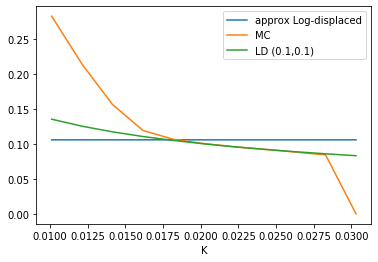

Diff ATM (MC - approx Log-displaced) -0.00533720231260304
Diff ATM (MC - LD(l,b)) = 0.000399315363210917
Diff. max |MC - approx Log-displaced| 0.17647069085910516
Diff. max |MC- LD(l,b)| = 0.14700066276532198
Test for (l,b)= 0.5 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 110
lambda_Chey, b_Chey = 3.6434689211047235 0.004222041872230529
Param_LD =  [[0.50118984 0.0932061 ]]


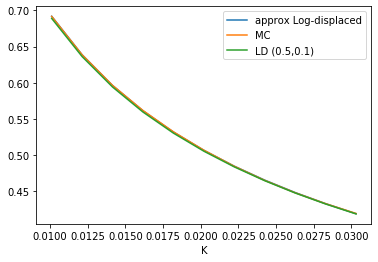

Diff ATM (MC - approx Log-displaced) 0.00013977196658743196
Diff ATM (MC - LD(l,b)) = 0.0013750151697422552
Diff. max |MC - approx Log-displaced| 0.0003623774773586774
Diff. max |MC- LD(l,b)| = 0.0027550577851798153
Test for (l,b)= 0.9 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 60
         Function evaluations: 115
lambda_Chey, b_Chey = 6.569175334550968 0.004198163388763809
Param_LD =  [[0.90261768 0.09590453]]


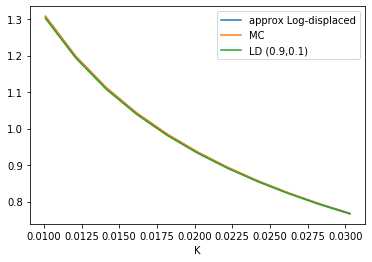

Diff ATM (MC - approx Log-displaced) 0.0003762361984627205
Diff ATM (MC - LD(l,b)) = 0.0033198503228959453
Diff. max |MC - approx Log-displaced| 0.0004998480949325312
Diff. max |MC- LD(l,b)| = 0.005519475787423289
Test for (l,b)= 0.1 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 99
lambda_Chey, b_Chey = 0.7242591635502197 0.07225966242945261
Param_LD =  [[0.07390854 1.30941745]]


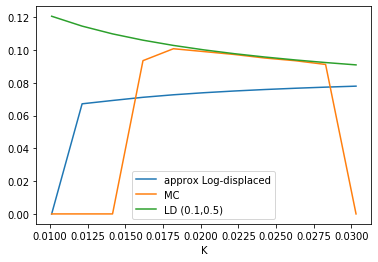

Diff ATM (MC - approx Log-displaced) 0.025092050457260484
Diff ATM (MC - LD(l,b)) = -0.0010427040342619875
Diff. max |MC - approx Log-displaced| 0.07790395984898169
Diff. max |MC- LD(l,b)| = 0.12053115293383598
Test for (l,b)= 0.5 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 108
lambda_Chey, b_Chey = 3.643591522457923 0.07171652184471368
Param_LD =  [[0.50345437 0.46673542]]


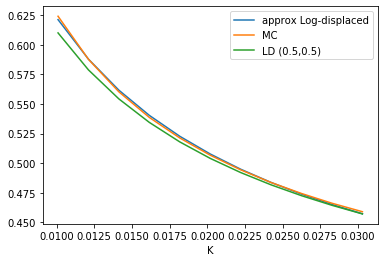

Diff ATM (MC - approx Log-displaced) -0.001015353664115537
Diff ATM (MC - LD(l,b)) = 0.0026991059144165774
Diff. max |MC - approx Log-displaced| 0.002875918803511013
Diff. max |MC- LD(l,b)| = 0.014090644465341029
Test for (l,b)= 0.9 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 59
         Function evaluations: 113
lambda_Chey, b_Chey = 6.654891929082009 0.0704238805913887
Param_LD =  [[0.90417207 0.49184336]]


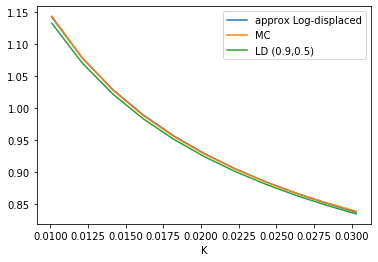

Diff ATM (MC - approx Log-displaced) -0.0006482844173660851
Diff ATM (MC - LD(l,b)) = 0.004153241000039998
Diff. max |MC - approx Log-displaced| 0.0014456234612225671
Diff. max |MC- LD(l,b)| = 0.01083124065416996
Test for (l,b)= 0.1 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 109
lambda_Chey, b_Chey = 0.7204227483264469 0.14116909350743265
Param_LD =  [[0.11329476 1.01544955]]


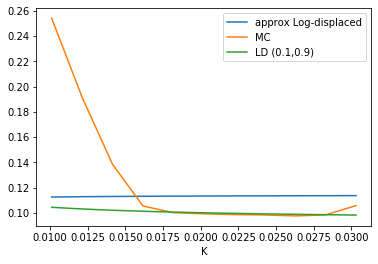

Diff ATM (MC - approx Log-displaced) -0.014093894208144775
Diff ATM (MC - LD(l,b)) = -0.0008089471043604135
Diff. max |MC - approx Log-displaced| 0.1415876663952531
Diff. max |MC- LD(l,b)| = 0.14974091124827282
Test for (l,b)= 0.5 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 117
lambda_Chey, b_Chey = 3.6437048045927316 0.13919290092682696
Param_LD =  [[0.49854995 0.89272862]]


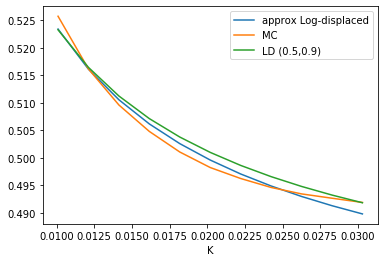

Diff ATM (MC - approx Log-displaced) -0.0013609787697532738
Diff ATM (MC - LD(l,b)) = -0.00275141021120362
Diff. max |MC - approx Log-displaced| 0.002332545793706231
Diff. max |MC- LD(l,b)| = 0.00275141021120362
Test for (l,b)= 0.9 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 62
         Function evaluations: 120
lambda_Chey, b_Chey = 6.746789779723514 0.13444224793926435
Param_LD =  [[0.90311786 0.84431064]]


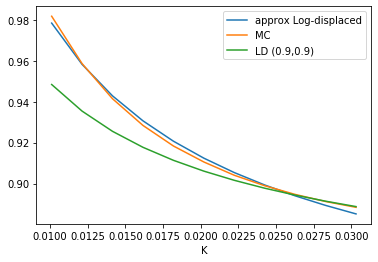

Diff ATM (MC - approx Log-displaced) -0.0018669206474442035
Diff ATM (MC - LD(l,b)) = 0.004473385267829144
Diff. max |MC - approx Log-displaced| 0.0033525137746437395
Diff. max |MC- LD(l,b)| = 0.03337068515975261


In [102]:
# 50% à 150% du strike ATM
b_vals = [0.1,0.5,0.9]
l_vals = [0.1,0.5,0.9]
for b in b_vals:
    for l in l_vals:
        test(l,b)

**$LD(\lambda,b)$ : modèle Log-displaced d'entrée**

**MC : Prix Monte Carlo générés à partir de $(\lambda_{Chey},b_{Chey})$ calibrés sur la courbe de vol. implicite du modèle précèdent**

**$Approx_{LD}$ : modèle log-displaced approximant la volatilité implicite MC par la méthode des moindres carrés**


| $\lambda$    |  $b$   | $max |MC - LD(\lambda,b)    | $  | $max |MC - Approx_{LD}    | $ |  
|-------------|-----------|---------------|----------------------------------------------|
|     0.1        | 0.1      |  0.14700066276532198  | 0.17647069085910516  |
|     0.1        | 0.5      | 0.12053115293383598  | 0.07790395984898169   |
|     0.1        | 0.9      | 0.14974091124827282   | 0.1415876663952531     |
|     0.5        | 0.1      | 0.0027550577851798153  |  0.0003623774773586774    |
|     0.5        | 0.5      | 0.014090644465341029   | 0.002875918803511013 |
|     0.5        | 0.9      |  0.00275141021120362  | 0.002332545793706231 |
|     0.9        | 0.1       |  0.005519475787423289   | 0.0004998480949325312 |
|     0.9        | 0.5      | 0.01083124065416996   | 0.0014456234612225671 |
|     0.9        | 0.9          |    0.03337068515975261  | 0.0033525137746437395 |

Tableau pour : $max |MC - LD(\lambda,b)| $

|$\lambda \backslash b$| 0.1 | 0.5 | 0.9 |
|---|----------|----------|----------|
|0.1| 0.147000 | 0.120531 | 0.149740 |
|0.5| 0.002755 (OK) | 0.014091 (OK)| 0.002751 (OK)|
|0.9| 0.005519 (OK)| 0.010831 (OK)| 0.033371 (OK)|

Tableau pour : $MC - LD(\lambda,b)$ ATM

|$\lambda \backslash b$| 0.1 | 0.5 | 0.9 |
|---|----------|----------|----------|
|0.1| 0.000399 | -0.001043 | -0.000809 |
|0.5| 0.001375 (OK) | 0.002699 (OK)| -0.002751 (OK)|
|0.9| 0.003320 (OK)| 0.004153 (OK)| 0.004473 (OK)|

La forme de la courbe de volatilité implicite générée par Monte Carlo semble poser problème lorsque $\lambda$ prend la plus faible valeur dans les tests. Cela est probablement dû à la courbe du modèle log-displaced en entrée qui est "plate".

Test for (l,b)= 0.2 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 117
lambda_Chey, b_Chey = 1.456525254526927 0.0042290742586326095
slope ATM: 4.240455665754879
Param_LD =  [[0.19884589 0.18794297]]


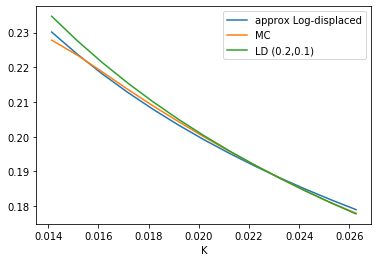

Diff ATM (MC - approx Log-displaced) 0.0009877124398371961
Diff ATM (MC - LD(l,b)) = -0.0006434207466554653
Diff. max |MC - approx Log-displaced| 0.0023280132472791593
Diff. max |MC- LD(l,b)| = 0.006884638087285566
Test for (l,b)= 0.2 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 52
         Function evaluations: 101
lambda_Chey, b_Chey = 1.4496637068502234 0.07219336600799577
slope ATM: 2.7633535083265897
Param_LD =  [[0.20060343 0.395503  ]]


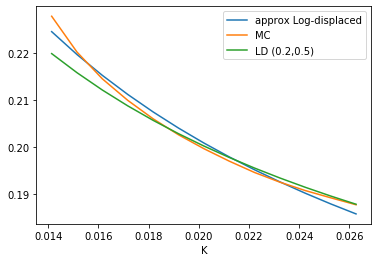

Diff ATM (MC - approx Log-displaced) -0.0014561160037374066
Diff ATM (MC - LD(l,b)) = -0.00023051913785820943
Diff. max |MC - approx Log-displaced| 0.0032642483188283222
Diff. max |MC- LD(l,b)| = 0.007912534590559517
Test for (l,b)= 0.2 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 59
         Function evaluations: 113
lambda_Chey, b_Chey = 1.4427826328754545 0.14092390256448983
slope ATM: 0.4076208899697214
Param_LD =  [[0.1972179  0.93039953]]


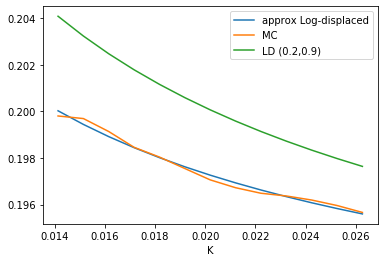

Diff ATM (MC - approx Log-displaced) 2.4953960746643133e-05
Diff ATM (MC - LD(l,b)) = -0.0030412611704377923
Diff. max |MC - approx Log-displaced| 0.00025137127749985666
Diff. max |MC- LD(l,b)| = 0.004279534457509726
Test for (l,b)= 0.3 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 101
lambda_Chey, b_Chey = 2.185070952423759 0.0042269514221606845
slope ATM: 6.656292325638541
Param_LD =  [[0.30136619 0.10913972]]


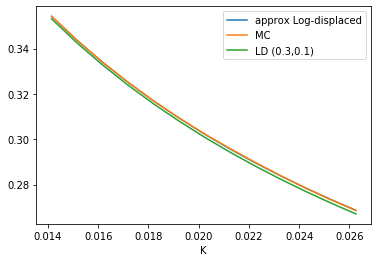

Diff ATM (MC - approx Log-displaced) -5.512056304723956e-05
Diff ATM (MC - LD(l,b)) = 0.0013655016437041922
Diff. max |MC - approx Log-displaced| 0.00017362729977321578
Diff. max |MC- LD(l,b)| = 0.0016219422354879498
Test for (l,b)= 0.3 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 102
lambda_Chey, b_Chey = 2.1772987498971927 0.07207969050756695
slope ATM: 3.713791462058568
Param_LD =  [[0.29804515 0.49980542]]


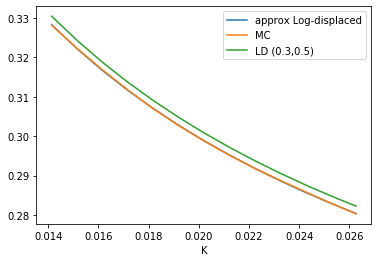

Diff ATM (MC - approx Log-displaced) -6.238240302991471e-05
Diff ATM (MC - LD(l,b)) = -0.0020895667989861977
Diff. max |MC - approx Log-displaced| 0.00015886908840911929
Diff. max |MC- LD(l,b)| = 0.002307651573119074
Test for (l,b)= 0.3 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 109
lambda_Chey, b_Chey = 2.169408478346322 0.14051230145851837
slope ATM: 0.8983131430630636
Param_LD =  [[0.30053703 0.86091682]]


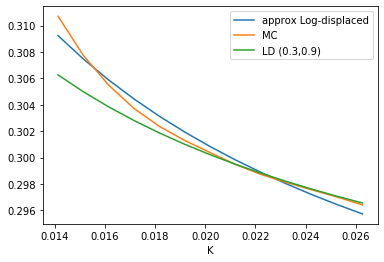

Diff ATM (MC - approx Log-displaced) -0.0007661362747057865
Diff ATM (MC - LD(l,b)) = 0.0002889333836719743
Diff. max |MC - approx Log-displaced| 0.001469249029923958
Diff. max |MC- LD(l,b)| = 0.004445825898073963
Test for (l,b)= 0.4 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 107
lambda_Chey, b_Chey = 2.913984126629874 0.004224440789771948
slope ATM: 9.26095045115619
Param_LD =  [[0.40202267 0.08726872]]


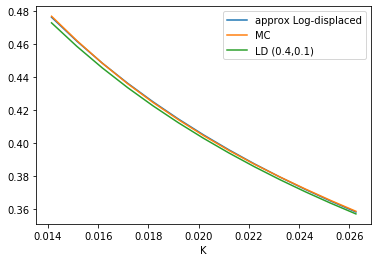

Diff ATM (MC - approx Log-displaced) -0.00038654408854199573
Diff ATM (MC - LD(l,b)) = 0.0018491747937332548
Diff. max |MC - approx Log-displaced| 0.0006235184514480352
Diff. max |MC- LD(l,b)| = 0.004014573632957763
Test for (l,b)= 0.4 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 104
lambda_Chey, b_Chey = 2.908292093585789 0.07192031820553624
slope ATM: 4.716943560192034
Param_LD =  [[0.39569037 0.53375424]]


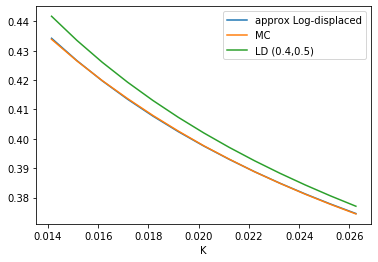

Diff ATM (MC - approx Log-displaced) 0.00021904934328631498
Diff ATM (MC - LD(l,b)) = -0.004684492041633348
Diff. max |MC - approx Log-displaced| 0.00034885456898336997
Diff. max |MC- LD(l,b)| = 0.007847483129808097
Test for (l,b)= 0.4 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 69
         Function evaluations: 130
lambda_Chey, b_Chey = 2.902333073966541 0.1399386333568674
slope ATM: 0.8280222063600448
Param_LD =  [[0.39485507 0.90467253]]


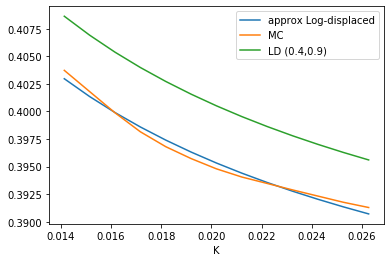

Diff ATM (MC - approx Log-displaced) -0.000597215439483989
Diff ATM (MC - LD(l,b)) = -0.005840728115344973
Diff. max |MC - approx Log-displaced| 0.0007599795685564459
Diff. max |MC- LD(l,b)| = 0.005914768839829776


In [103]:
#Tests pour connaître le seuil pour lambda à partir duquel les tests sont 'valides'
l_values = [0.2,0.3,0.4]
b_vals = [0.1,0.5,0.9]
for l in l_values:
    for b in b_vals:
        test(l,b)

Test for (l,b)= 0.125 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 50
         Function evaluations: 92
lambda_Chey, b_Chey = 0.9102405612362912 0.004232189267130207
slope ATM: 2.867776383665464
Param_LD =  [[1.27188718e-01 3.67121877e-12]]


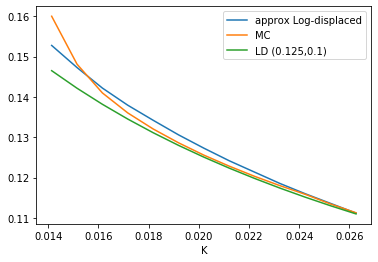

Diff ATM (MC - approx Log-displaced) -0.002157588742193184
Diff ATM (MC - LD(l,b)) = 0.0006374214035531622
Diff. max |MC - approx Log-displaced| 0.007236390547404881
Diff. max |MC- LD(l,b)| = 0.013490105041000788
Test for (l,b)= 0.125 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 49
         Function evaluations: 95
lambda_Chey, b_Chey = 0.9055359808478315 0.07224802724776694
slope ATM: 1.6712836075184863
Param_LD =  [[0.12639856 0.24936939]]


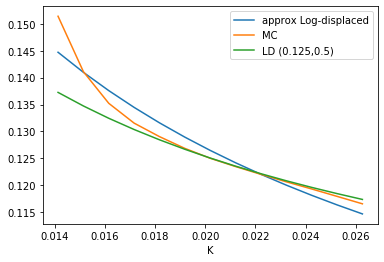

Diff ATM (MC - approx Log-displaced) -0.002560403036113712
Diff ATM (MC - LD(l,b)) = 0.00016635299743938958
Diff. max |MC - approx Log-displaced| 0.006688494204354356
Diff. max |MC- LD(l,b)| = 0.014139918641831173
Test for (l,b)= 0.125 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 54
         Function evaluations: 101
lambda_Chey, b_Chey = 0.9007589904831369 0.14112423065937144
slope ATM: 0.31547425873961976
Param_LD =  [[0.11804142 3.0160113 ]]


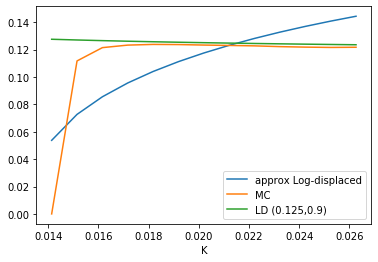

Diff ATM (MC - approx Log-displaced) 0.01976123259510132
Diff ATM (MC - LD(l,b)) = -0.0017006052075885236
Diff. max |MC - approx Log-displaced| 0.05372502982140759
Diff. max |MC- LD(l,b)| = 0.12752009754080973
Test for (l,b)= 0.15 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 48
         Function evaluations: 91
lambda_Chey, b_Chey = 1.0922802331165085 0.004230493835132731
slope ATM: 3.330237593433589
Param_LD =  [[0.14959459 0.18598723]]


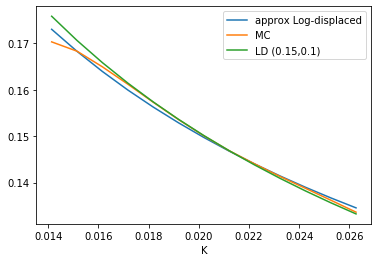

Diff ATM (MC - approx Log-displaced) 0.0010476955799276766
Diff ATM (MC - LD(l,b)) = -5.321174967320985e-05
Diff. max |MC - approx Log-displaced| 0.002712618691020907
Diff. max |MC- LD(l,b)| = 0.005529892116555857
Test for (l,b)= 0.15 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 48
         Function evaluations: 93
lambda_Chey, b_Chey = 1.0867904583412362 0.07223392278219314
slope ATM: 1.947509067163985
Param_LD =  [[0.14920362 0.53176305]]


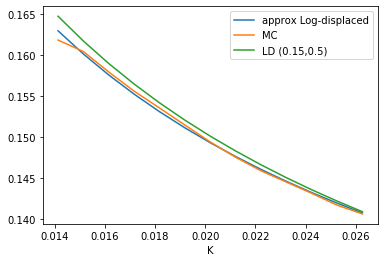

Diff ATM (MC - approx Log-displaced) 0.0004523120105659473
Diff ATM (MC - LD(l,b)) = -0.0005955914798505546
Diff. max |MC - approx Log-displaced| 0.00113071003852383
Diff. max |MC- LD(l,b)| = 0.002909286754402274
Test for (l,b)= 0.15 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 54
         Function evaluations: 104
lambda_Chey, b_Chey = 1.0812295257117333 0.1410676603768905
slope ATM: 0.3745429587578264
Param_LD =  [[0.14795686 0.97886273]]


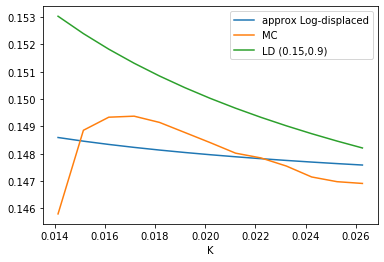

Diff ATM (MC - approx Log-displaced) 0.0010124463256033778
Diff ATM (MC - LD(l,b)) = -0.0016424592308794672
Diff. max |MC - approx Log-displaced| 0.002798502550831472
Diff. max |MC- LD(l,b)| = 0.007239644621677144
Test for (l,b)= 0.175 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 47
         Function evaluations: 88
lambda_Chey, b_Chey = 1.274399641635338 0.004231446705461784
slope ATM: 3.8537022055388417
Param_LD =  [[0.17448685 0.10679095]]


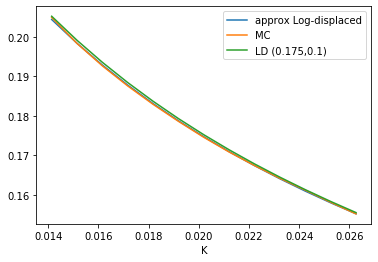

Diff ATM (MC - approx Log-displaced) -0.00017451998246542644
Diff ATM (MC - LD(l,b)) = -0.0006932378983037779
Diff. max |MC - approx Log-displaced| 0.0005060223679720366
Diff. max |MC- LD(l,b)| = 0.0008934745324040705
Test for (l,b)= 0.175 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 99
lambda_Chey, b_Chey = 1.26819966563819 0.07221537065316691
slope ATM: 2.1159503809070705
Param_LD =  [[0.17460643 0.50615331]]


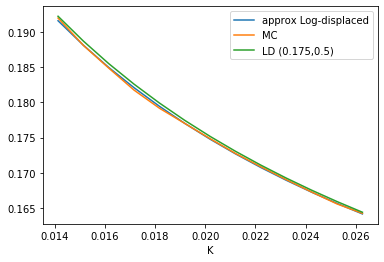

Diff ATM (MC - approx Log-displaced) -0.00027221294431001297
Diff ATM (MC - LD(l,b)) = -0.0004305825677874964
Diff. max |MC - approx Log-displaced| 0.00038009691934348666
Diff. max |MC- LD(l,b)| = 0.0008449901019957906
Test for (l,b)= 0.175 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 51
         Function evaluations: 94
lambda_Chey, b_Chey = 1.2619647387099417 0.1409983752079001
slope ATM: 0.5130025117331898
Param_LD =  [[0.1727455  0.92198902]]


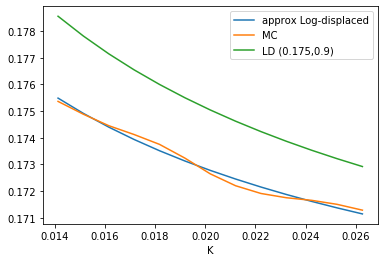

Diff ATM (MC - approx Log-displaced) 0.00023803382191545097
Diff ATM (MC - LD(l,b)) = -0.002261718395857315
Diff. max |MC - approx Log-displaced| 0.00025130761287073256
Diff. max |MC- LD(l,b)| = 0.003191321022768534


In [28]:
l_values = [0.125,0.15,0.175]
b_vals = [0.1,0.5,0.9]
for l in l_values:
    for b in b_vals:
        test(l,b)

Tableau pour : $max |MC - LD(\lambda,b)| $ (pourcentage = $Erreur_{max} / IV_{ATM} *100$)

|$\lambda \backslash b$| 0.1 | 0.5 | 0.9 |
|---|----------|----------|----------|
|0.125| 0.01349 (OK: 10.8%) | 0.01414 (OK: 11.3%) | 0.0537 (102%) |
|0.15| 0.00552 (OK: 3.68%) | 0.00290 (OK: 1.94%)| 0.00724 (4.94%)|
|0.175| 0.00089 (OK: 0.51%)| 0.00084 (OK: 0.48%)| 0.00319 (OK: 1.8%)|

Test for (l,b)= 0.1 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 99
lambda_Chey, b_Chey = 0.7242591635502197 0.07225966242945261
slope ATM: 1.2725446441848538
Param_LD =  [[0.09740744 0.94181514]]


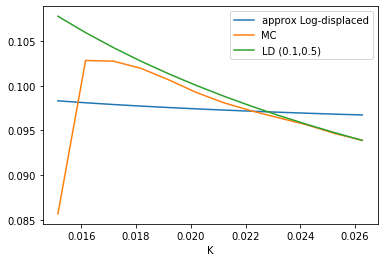

Diff ATM (MC - approx Log-displaced) 0.0031021877771308937
Diff ATM (MC - LD(l,b)) = -0.0006697319895465625
Diff. max |MC - approx Log-displaced| 0.012638129942388332
Diff. max |MC- LD(l,b)| = 0.022090858253704937
Test for (l,b)= 0.5 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 108
lambda_Chey, b_Chey = 3.643591522457923 0.07171652184471368
slope ATM: 6.561338904180499
Param_LD =  [[0.49859155 0.4837976 ]]


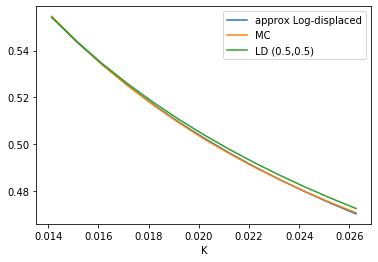

Diff ATM (MC - approx Log-displaced) -0.00020444136225705734
Diff ATM (MC - LD(l,b)) = -0.0014615201234846609
Diff. max |MC - approx Log-displaced| 0.0005011361395190761
Diff. max |MC- LD(l,b)| = 0.001931266288011102


In [38]:
#Essai de la derniere version des tests (retrait des points où la vol impli MC est nulle)

test(0.1,0.5)
test(0.5,0.5)

### Tests sur sur $\bar{b}$

Test for (l,b)= 0.1 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 60
         Function evaluations: 108
lambda_Chey, b_Chey = 1.2039459330762525 0.004230643031206894
Param_LD =  [[2.28564409]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 64
         Function evaluations: 116


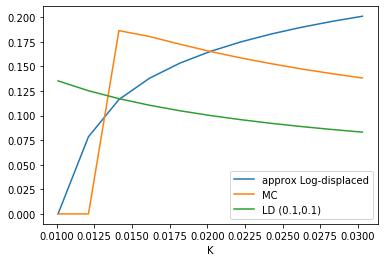

Diff ATM (MC - approx Log-displaced) 0.0
Diff ATM (MC - LD(l,b)) = 0.06510474107471964
Diff. max |MC - approx Log-displaced| 0.07844800129532814
Diff. max |MC- LD(l,b)| = 0.13523608606192283
Test for (l,b)= 0.5 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 105
lambda_Chey, b_Chey = 1.2039633163154777 0.004230642345220155
Param_LD =  [[2.42198098e-06]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 50
         Function evaluations: 93


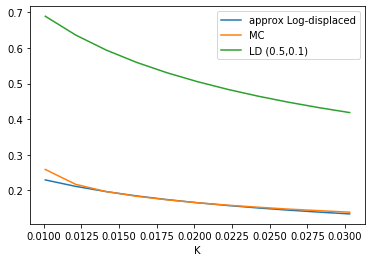

Diff ATM (MC - approx Log-displaced) 5.4569682106375694e-11
Diff ATM (MC - LD(l,b)) = -0.3399032066727159
Diff. max |MC - approx Log-displaced| 0.029344354086333624
Diff. max |MC- LD(l,b)| = 0.43009992168890676
Test for (l,b)= 0.9 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 105
lambda_Chey, b_Chey = 1.2039633163154777 0.004230642345220155
Param_LD =  [[1.65235518]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 63
         Function evaluations: 116


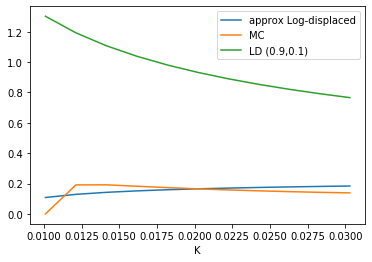

Diff ATM (MC - approx Log-displaced) 0.0
Diff ATM (MC - LD(l,b)) = -0.7672679416737083
Diff. max |MC - approx Log-displaced| 0.1080283522605896
Diff. max |MC- LD(l,b)| = 1.3018482918539576
Test for (l,b)= 0.1 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 41
         Function evaluations: 78
lambda_Chey, b_Chey = 1.1250568707075428 0.021164761268692697
Param_LD =  [[5.16851803e-11]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 65
         Function evaluations: 118


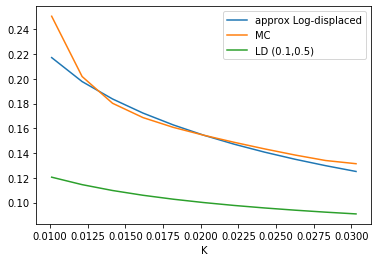

Diff ATM (MC - approx Log-displaced) -2.7754185794037767e-06
Diff ATM (MC - LD(l,b)) = 0.054356282003027445
Diff. max |MC - approx Log-displaced| 0.033388874503543775
Diff. max |MC- LD(l,b)| = 0.1299424222872858
Test for (l,b)= 0.5 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 66
         Function evaluations: 119
lambda_Chey, b_Chey = 1.169649486958161 0.07222491348782459
Param_LD =  [[2.45663563]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 49
         Function evaluations: 92


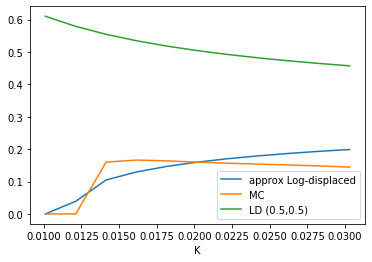

Diff ATM (MC - approx Log-displaced) 0.0
Diff ATM (MC - LD(l,b)) = -0.34412873034398217
Diff. max |MC - approx Log-displaced| 0.055135494962996745
Diff. max |MC- LD(l,b)| = 0.6100857062472187
Test for (l,b)= 0.9 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 121
lambda_Chey, b_Chey = 1.1696636820645097 0.0722249120532485
Param_LD =  [[1.80823256]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 62
         Function evaluations: 112


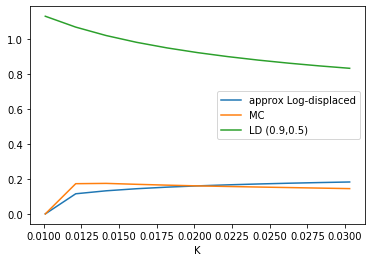

Diff ATM (MC - approx Log-displaced) 0.0
Diff ATM (MC - LD(l,b)) = -0.763701020462122
Diff. max |MC - approx Log-displaced| 0.057787993397369064
Diff. max |MC- LD(l,b)| = 1.1326947146505972
Test for (l,b)= 0.1 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 120
lambda_Chey, b_Chey = 1.1773362348728473 0.061200011795649385
Param_LD =  [[1.40621354e-10]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 69
         Function evaluations: 124


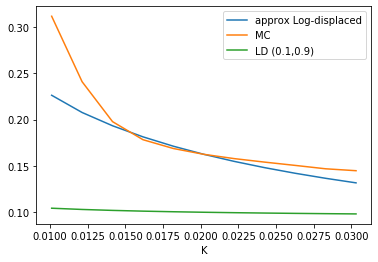

Diff ATM (MC - approx Log-displaced) -1.2525492820714135e-06
Diff ATM (MC - LD(l,b)) = 0.062464798068049276
Diff. max |MC - approx Log-displaced| 0.08521369531763412
Diff. max |MC- LD(l,b)| = 0.20699718137734635
Test for (l,b)= 0.5 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 81
lambda_Chey, b_Chey = 1.1696258886616353 0.14103541940320385
Param_LD =  [[2.49999038]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 60
         Function evaluations: 109


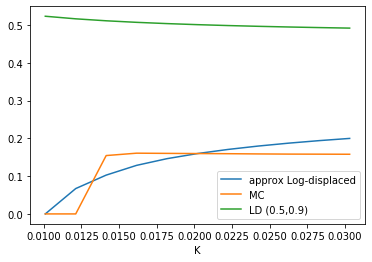

Diff ATM (MC - approx Log-displaced) 0.0
Diff ATM (MC - LD(l,b)) = -0.34121755945761834
Diff. max |MC - approx Log-displaced| 0.067138671875
Diff. max |MC- LD(l,b)| = 0.5232710297843823
Test for (l,b)= 0.9 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 81
lambda_Chey, b_Chey = 1.1696258886616353 0.14103541940320385
Param_LD =  [[2.4880707]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 105


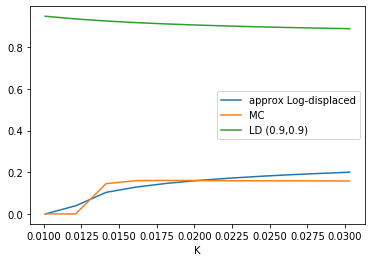

Diff ATM (MC - approx Log-displaced) 0.0
Diff ATM (MC - LD(l,b)) = -0.7458866915976614
Diff. max |MC - approx Log-displaced| 0.04220905344482162
Diff. max |MC- LD(l,b)| = 0.9483966261643673


In [103]:
b_vals = [0.1,0.5,0.9]
l_vals = [0.1,0.5,0.9]
for b in b_vals:
    for l in l_vals:
        test(l,b,2)

| $\lambda$    |  $b$   | $max |MC - LD(\lambda,b)    | $  | $max |MC - Approx_{LD}    | $ |  
|-------------|-----------|---------------|----------------------------------------------|
|     0.1        | 0.1      | 0.13523   | 0.07844  |
|     0.1        | 0.5      | 0.12994  |  0.03338 |
|     0.1        | 0.9      | 0.20699   | 0.08521  |
|     0.5        | 0.1      | 0.43009   | 0.02934 |
|     0.5        | 0.5      | 0.61008   | 0.05513  |
|     0.5        | 0.9      | 0.52327   | 0.06713  |
|     0.9        | 0.1       | 1.30184    | 0.10802  |
|     0.9        | 0.5      |  1.13269  | 0.05778  |
|     0.9        | 0.9          | 0.94839     | 0.04220  |

Tableau pour : $max |MC - LD(\lambda,b)| $

|$\lambda \backslash b$| 0.1 | 0.5 | 0.9 |
|---|----------|----------|----------|
|0.1| 0.13523 | 0.12994 | 0.20699 |
|0.5| 0.43009 | 0.61008| 0.52327|
|0.9| 1.30184| 1.13269| 0.94839|

Tableau pour : $MC - LD(\lambda,b)$ ATM

|$\lambda \backslash b$| 0.1 | 0.5 | 0.9 |
|---|----------|----------|----------|
|0.1| 0.065104| 0.054356 | 0.062465 |
|0.5| -0.339903| -0.344129| -0.341218|
|0.9|-0.767268| -0.763701| -0.745887|

### Tests sur volatilité implicite normale

Test for (l,b)= 0.1 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 49
         Function evaluations: 96
lambda_Chey, b_Chey = 0.728227242867401 0.004231859564249929
slope ATM: 0.010645365467191331
Param_LD =  [[0.08829944 2.9512724 ]]


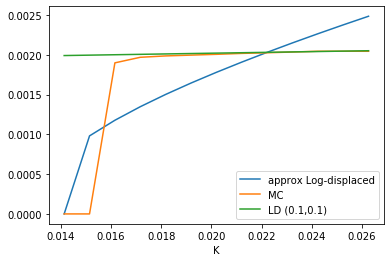

Diff ATM (MC - approx Log-displaced) 0.0004840340892542372
Diff ATM (MC - LD(l,b)) = -1.992575846543332e-05
Diff. max |MC - approx Log-displaced| 0.0009803678835851315
Diff. max |MC- LD(l,b)| = 0.001994767461610536
Test for (l,b)= 0.5 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 110
lambda_Chey, b_Chey = 3.6434689211047235 0.004222041872230529
slope ATM: 0.025603799416211267
Param_LD =  [[0.50254903 0.09984272]]


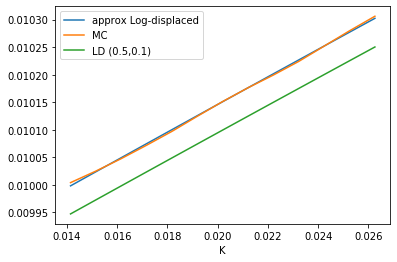

Diff ATM (MC - approx Log-displaced) -3.068771547987126e-06
Diff ATM (MC - LD(l,b)) = 5.0305445142839744e-05
Diff. max |MC - approx Log-displaced| 5.843213557454874e-06
Diff. max |MC- LD(l,b)| = 5.679009973391658e-05
Test for (l,b)= 0.9 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 60
         Function evaluations: 115
lambda_Chey, b_Chey = 6.569175334550968 0.004198163388763809
slope ATM: 0.04230780850787744
Param_LD =  [[0.901326   0.09321527]]


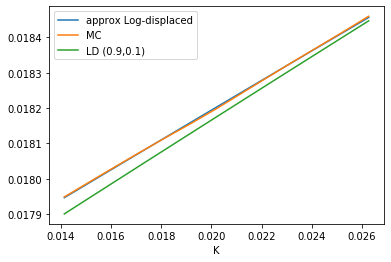

Diff ATM (MC - approx Log-displaced) -9.135959544437355e-07
Diff ATM (MC - LD(l,b)) = 2.7182264261682576e-05
Diff. max |MC - approx Log-displaced| 4.337249492891715e-06
Diff. max |MC- LD(l,b)| = 4.7921457735355943e-05
Test for (l,b)= 0.1 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 99
lambda_Chey, b_Chey = 0.7242591635502197 0.07225966242945261
slope ATM: 0.029979404173395806
Param_LD =  [[0.08869033 2.84213731]]


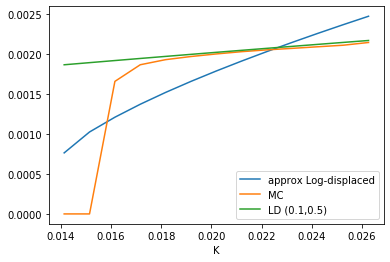

Diff ATM (MC - approx Log-displaced) 0.00040950583297671983
Diff ATM (MC - LD(l,b)) = -2.6949084031002712e-05
Diff. max |MC - approx Log-displaced| 0.0010241985890502292
Diff. max |MC- LD(l,b)| = 0.001890869611997914
Test for (l,b)= 0.5 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 108
lambda_Chey, b_Chey = 3.643591522457923 0.07171652184471368
slope ATM: 0.12614574095433617
Param_LD =  [[0.49749046 0.50949954]]


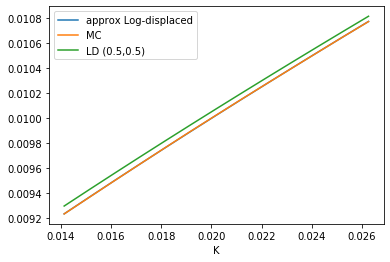

Diff ATM (MC - approx Log-displaced) 6.402785857062554e-07
Diff ATM (MC - LD(l,b)) = -5.152936637387029e-05
Diff. max |MC - approx Log-displaced| 1.5203113434836268e-06
Diff. max |MC- LD(l,b)| = 6.289270118031709e-05
Test for (l,b)= 0.9 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 59
         Function evaluations: 113
lambda_Chey, b_Chey = 6.654891929082009 0.0704238805913887
slope ATM: 0.21897534135871408
Param_LD =  [[0.90680353 0.48855121]]


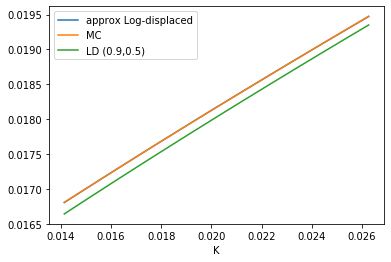

Diff ATM (MC - approx Log-displaced) -9.62805302151537e-07
Diff ATM (MC - LD(l,b)) = 0.00014380619575149467
Diff. max |MC - approx Log-displaced| 3.866196607305028e-06
Diff. max |MC- LD(l,b)| = 0.0001667596905008395
Test for (l,b)= 0.1 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 109
lambda_Chey, b_Chey = 0.7204227483264469 0.14116909350743265
slope ATM: 0.049664118184612006
Param_LD =  [[0.09060438 3.0461795 ]]


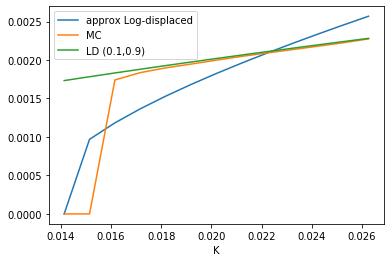

Diff ATM (MC - approx Log-displaced) 0.00036797144673528237
Diff ATM (MC - LD(l,b)) = -2.670153662620578e-05
Diff. max |MC - approx Log-displaced| 0.0009692835902797015
Diff. max |MC- LD(l,b)| = 0.0017826233488449361
Test for (l,b)= 0.5 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 117
lambda_Chey, b_Chey = 3.6437048045927316 0.13919290092682696
slope ATM: 0.22064128190310847
Param_LD =  [[0.49312643 0.90397696]]


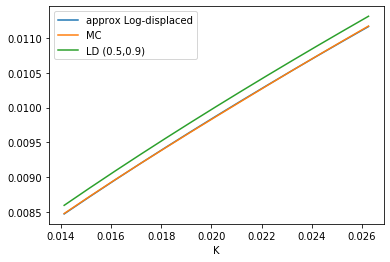

Diff ATM (MC - approx Log-displaced) -3.827125283351052e-06
Diff ATM (MC - LD(l,b)) = -0.00013911006533362524
Diff. max |MC - approx Log-displaced| 7.311416538868798e-06
Diff. max |MC- LD(l,b)| = 0.00014418517650938156
Test for (l,b)= 0.9 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 62
         Function evaluations: 120
lambda_Chey, b_Chey = 6.746789779723514 0.13444224793926435
slope ATM: 0.3741147716184553
Param_LD =  [[0.90782636 0.84006187]]


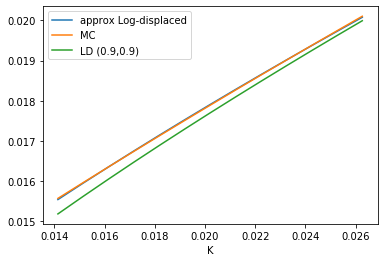

Diff ATM (MC - approx Log-displaced) -1.4205190268512524e-05
Diff ATM (MC - LD(l,b)) = 0.00021363800044582604
Diff. max |MC - approx Log-displaced| 2.9187617656134535e-05
Diff. max |MC- LD(l,b)| = 0.0003862782847363633


In [34]:
# Tests sur -30% +30% sur strikes ATM
b_vals = [0.1,0.5,0.9]
l_vals = [0.1,0.5,0.9]
for b in b_vals:
    for l in l_vals:
        test(l,b,1,"normal")

| $\lambda$    |  $b$   | $max |MC - LD(\lambda,b)    | $  | $max |MC - Approx_{LD}    | $ |  
|-------------|-----------|---------------|----------------------------------------------|
|     0.1        | 0.1      | 0.00197   | 0.00181  |
|     0.1        | 0.5      | 0.00186  | 0.00194 |  
|     0.1        | 0.9      | 0.00173   |0.00199 |
|     0.5        | 0.1      | 0.000076   | 0.0000049|
|     0.5        | 0.5      |  0.00018  |0.000030  |
|     0.5        | 0.9      | 0.000082   | 0.000031 |
|     0.9        | 0.1       | 0.000056    | 0.01752 |
|     0.9        | 0.5      | 0.00012   | 0.000020 |
|     0.9        | 0.9          |  0.00033   | 0.000041 |


Tableau pour : $max |MC - LD(\lambda,b)| $

|$\lambda \backslash b$| 0.1 | 0.5 | 0.9 |
|---|----------|----------|----------|
|0.1| 0.00197 (OK)| 0.00186 | 0.00173 |
|0.5| 0.000076 (OK)| 0.00018 (OK)| 0.000082 (OK)|
|0.9| 0.000056 (OK)| 0.00012 (OK)| 0.00033 (OK)|

Tableau pour : $MC - LD(\lambda,b)$ ATM

|$\lambda \backslash b$| 0.1 | 0.5 | 0.9 |
|---|----------|----------|----------|
|0.1| 6.066216 e-7| -8.111555 e-6 | -4.038159 e-5 |
|0.5| 5.078142 e-5| 5.852974 e-5| -4.156753 e-5|
|0.9|7.285530 e-6| 4.049860 e-5| 7.859990 e-5|

Test for (l,b)= 0.1 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 109
lambda_Chey, b_Chey = 0.7204227483264469 0.14116909350743265
slope ATM: 0.04658764127163065
Param_LD =  [[0.10300505 0.32926924]]


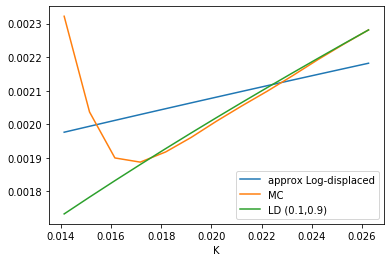

Diff ATM (MC - approx Log-displaced) -0.00012902125376967888
Diff ATM (MC - LD(l,b)) = -1.33369809418582e-05
Diff. max |MC - approx Log-displaced| 0.0003458122819210985
Diff. max |MC- LD(l,b)| = 0.0005894523610550095


In [32]:
test(0.1,0.9,1,"normal")

Test for (l,b)= 0.1 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 109
lambda_Chey, b_Chey = 0.7204227483264469 0.14116909350743265
slope ATM: 0.04406414941756059
Param_LD =  [[0.10120186 0.46773992]]


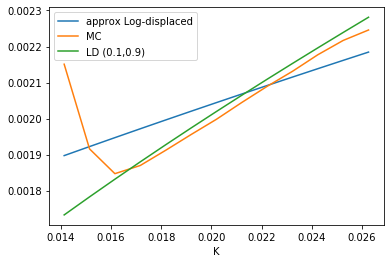

Diff ATM (MC - approx Log-displaced) -8.419888217758853e-05
Diff ATM (MC - LD(l,b)) = -1.8193605910710176e-05
Diff. max |MC - approx Log-displaced| 0.00025368291858285374
Diff. max |MC- LD(l,b)| = 0.00041831713701867557


In [33]:
test(0.1,0.9,1,"normal")

Text(0.5, 1.0, 'Diff. 2 MC')

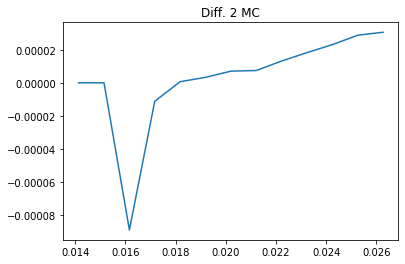

In [42]:
#Différence entre deux courbes MC successives sur les memes parametres 
lambda_Chey = 0.7204227483264469
b_Chey = 0.14116909350743265

N,M = 250, 100000
maturities = np.arange(1,7,1)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
A0 = A(0,0,0,maturities,bonds,1,chi)
strikes = [0.05*k*S0 for k in range(14,27)]

sim1 = simul(lambda_Chey,S0,b_Chey,chi,T0,N,M,scheme = "Euler")
Prices1 = [swaption_MC(M,sim1,k,chi,bonds,maturities) for k in strikes]
MC1 = [biss_python(Prices1[m], bonds, strikes[m], maturities,"normal") for m in range(len(strikes))]

sim2 = simul(lambda_Chey,S0,b_Chey,chi,T0,N,M,scheme = "Euler")
Prices2 = [swaption_MC(M,sim2,k,chi,bonds,maturities) for k in strikes]
MC2 = [biss_python(Prices2[m], bonds, strikes[m], maturities,"normal") for m in range(len(strikes))]

plt.plot(strikes,np.array(MC1) - np.array(MC2))
plt.title("Diff. 2 MC")

### Intervalles de confiance pour l'estimateur Monte Carlo

On va donner l'écart maximum en valeur absolue entre l'estimateur et la vraie valeur avec un seuil de confiance 95%.

L'intervalle de confiance est de: 
$$\big[ \bar{X}_n - \Phi^{-1}(1-\frac{\alpha}{2}) \sqrt{\frac{\hat{\sigma}_n^2}{n}} \ ; \ \bar{X}_n + \Phi^{-1}(1-\frac{\alpha}{2}) \sqrt{\frac{\hat{\sigma}_n^2}{n}} \big]$$

On va afficher le rayon de l'intervalle pour différents nombres de simulations

In [43]:
# Confiance interval of the Monte Carlo estimator
for m in [100,1000,10000,100000]:
    print("M = ",m)
    sim = simul(lambda_Chey,0.5*S0,b_Chey,chi,T0,N,m,scheme = "Euler")
    print(swaption_MC(m,sim,0.5*S0,chi,bonds,maturities,True,True))
    print()

M =  100
Variance: 1.7562014424895786e-05
IC (95%) radius: 0.0008213783209622691
0.04613454959268595

M =  1000
Variance: 1.9105708059275004e-05
IC (95%) radius: 0.0002709178622396664
0.04653397877910416

M =  10000
Variance: 1.8621609880841924e-05
IC (95%) radius: 8.45794162419216e-05
0.04665410549862242

M =  100000
Variance: 1.8610661031666538e-05
IC (95%) radius: 2.6738495735409307e-05
0.04664210459874615



Deux appels successifs sur les mêmes paramètres ne fournissent pas les mêmes courbes Monte Carlo. 

**Limite de la calibration sur les parametres LD: le modèle LD est monotone (décroissant pour la vol. implicite log-normale et croissant pour la vol. normale) et rigide -> certaines courbe de volatilité implicite observées ne pourront pas être calibrées correctement. L'approximation LD est donc juste un moyen de faciliter la calibration, ensuite on utilise les courbes MC**

### n Maturités

In [20]:
# Simulation d'Euler pour des paramètres constants par morceaux (Piecewise Constant)

def simul_pc(lmbdas,a,b_vals,chi,maturity_grid,N,M):
    nb_mat = len(maturity_grid)-1
    resu = []
    for m in range(M):
        (x,y,I) =(0,0,0)
        Z = np.random.standard_normal(N*(nb_mat-1)) # N pas entre 0 et T1; entre T1 et T2 etc...
        for i in range(1,nb_mat): #pour chaque maturités Ti
            T0 = maturity_grid[i]
            delta = (T0 - maturity_grid[i-1]) / N
            lmbda = lmbdas[i-1]
            b = b_vals[i-1]
            for j in range(N):
                sigma_j = lmbda*(a+b*x)
                I = I - x*delta
                if(x + (y-chi*x)*delta + sigma_j*math.sqrt(delta)*Z[(i-1)*N + j] > 1e10):
                    x = 1e10
                else:
                    x = x +(y-chi*x)*delta + sigma_j*math.sqrt(delta)*Z[(i-1)*N + j]
                y = y + (sigma_j**2 -2*chi*y)*delta
        resu.append((x,y,I))
    return resu

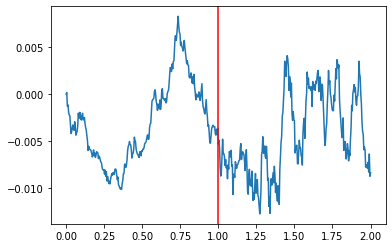

In [93]:
#Test
N,M = 250,100000
maturity_grid = [0,1,2,6]
mat = np.arange(1,7,1)
bonds = [np.exp(-r*m) for m in mat]
S0 = S(0,0,0,maturities,bonds,1,chi)
lmbdas = [0.5,1]
b_vals = [0.8,0]
X = np.linspace(0,2,N*2+1)

Curve = [0]
nb_mat = len(maturity_grid)-1
(x,y,I) =(0,0,0)
Z = np.random.standard_normal(N*(nb_mat-1)) # N pas entre 0 et T1; entre T1 et T2 etc...
for i in range(1,nb_mat): #pour chaque maturités Ti
    T0 = maturity_grid[i]
    delta = (T0 - maturity_grid[i-1]) / N
    lmbda = lmbdas[i-1]
    b = b_vals[i-1]
    for j in range(N):
        sigma_j = lmbda*(S0+b*x)
        I = I - x*delta
        if(x + (y-chi*x)*delta + sigma_j*math.sqrt(delta)*Z[(i-1)*N + j] > 1e10):
            x = 1e10
        else:
            x = x +(y-chi*x)*delta + sigma_j*math.sqrt(delta)*Z[(i-1)*N + j]
        y = y + (sigma_j**2 -2*chi*y)*delta
        Curve.append(x)

plt.plot(X,Curve)
plt.axvline(1, 0, 1,color='r')

In [94]:
s = simul(0.5,S0,0.8,chi,1,N,M,scheme = "Euler")
print("Price1:",swaption_MC(M,s,S0,chi,bonds,maturities))
s2 = simul_pc([0.5],S0,[0.8],chi,[0,1,6],N,M)
print("Price2:",swaption_MC(M,s2,S0,chi,bonds,maturities))

Price1: 0.0025474280690173873
Price2: 0.002536165744337329


In [21]:
#tests sur plusieurs maturités

def test2(l,b, nb_mat, iv_model= "log-normal"):
    print("Test for (l,b)=",l,b)
    N,M = 250,100000
    term_date = 6
    maturity_grid = [t for t in range(0,nb_mat+1)] + [term_date] # [0,1,..., nb_mat, term_date]
    delta = 1
    
    IV_LD = np.zeros((nb_mat,11))
    IV = np.zeros((nb_mat,11))
    IV_approxLD = np.zeros((nb_mat,11))
    prix_LD = np.zeros((nb_mat,11)) #prix LD
    Prices = np.zeros((nb_mat,11)) #prix MC
    slope_atm = np.zeros(nb_mat)
    maturities = []
    bonds = []
    
    for i in range(0,nb_mat):
        T0 = maturity_grid[i+1]
        mat = np.arange(T0,term_date + delta,delta)
        maturities += [mat]
        ZC_b = [np.exp(-r*m) for m in mat]
        bonds += [ZC_b]
        S0 = S(0,0,0,mat,ZC_b,1,chi)
        A0 = A(0,0,0,mat,ZC_b,1,chi)
        strikes = [0.1*k*S0 for k in range(5,16)] # 50% to 150% of the strike ATM
    
        #IV log_displaced (l,b)
        prix_LD[i] = [log_displaced(S0,A0,T0,strikes[m],l[i],b[i])  for m in range(len(strikes))]
        IV_LD[i] = [biss_python(prix_LD[i][m], ZC_b, strikes[m], mat,iv_model) for m in range(len(strikes))]
        slope_atm[i] = abs((biss_python(log_displaced(S0,A0,T0,0.95*S0,l[i],b[i]), ZC_b, 0.95*S0, mat,iv_model) - biss_python(log_displaced(S0,A0,T0,1.05*S0,l[i],b[i]), ZC_b, 1.05*S0, mat,iv_model))/(0.1*S0))
        if slope_atm[i] > 5:
            slope_atm[i] = 1
            
    #Extract LD parameters & Calibration
    data = data_set_bis(maturity_grid,strikes,IV_LD,chi,delta,IV_LD[:,5],slope_atm,iv_model)
    print("((lambda_obs,b_obs))=",data)
    calib_param = calib2(data,maturity_grid,delta,True)
    lambda_Chey, b_Chey = calib_param
    print("lambda_Chey, b_Chey =",lambda_Chey,b_Chey)
        
    #IV Monte Carlo
    for i in range(nb_mat):
        T0 = maturity_grid[i+1]
        sim = simul_pc(lambda_Chey[:(i+1)],S0,b_Chey[:(i+1)],chi,maturity_grid[:(i+2)] + [term_date],N,M)
        Prices[i] = [swaption_MC(M,sim,k,chi,bonds[i],maturities[i]) for k in strikes]
        IV[i] = [biss_python(Prices[i][m], bonds[i], strikes[m], maturities[i],iv_model) for m in range(len(strikes))]
        slope_atm[i] = abs((biss_python(swaption_MC(M,sim,0.95*S0,chi,bonds[i],maturities[i]),bonds[i], 0.95*S0, maturities[i],iv_model) - biss_python(swaption_MC(M,sim,1.05*S0,chi,bonds[i],maturities[i]),bonds[i], 1.05*S0, maturities[i],iv_model))/(0.1*S0))
        if slope_atm[i] > 5:
            slope_atm[i] = 1

    # Fitted log displaced curve
    data = data_set_bis(maturity_grid,strikes,IV,chi,delta,IV[:,5],slope_atm,iv_model)
    print("Param_LD = ",data)
        
    for i in range(nb_mat):
        A0 = A(0,0,0,maturities[i],bonds[i],1,chi)
        T0 = maturity_grid[i+1]
        #prix_approxLD = [log_displaced(S0,A0,T0,strikes[m],data[i][0],data[i][1])  for m in range(len(strikes))]
        #IV_approxLD[i] = [biss_python(prix_approxLD[m], bonds[i], strikes[m], maturities[i],iv_model) for m in range(len(strikes))]
        lbar = lambda_bar(maturities[i], bonds[i], maturity_grid,lambda_Chey, b_Chey, lambda_Chey[i], b_Chey[i], chi)
        bbar = b_bar(maturities[i], bonds[i], maturity_grid,lambda_Chey,b_Chey , lambda_Chey[i], b_Chey[i], chi)
        IV_ld = [biss_python(log_displaced(S0,A0,T0,strikes[m],lbar,bbar), bonds[i], strikes[m], maturities[i],iv_model) for m in range(len(strikes))]
        print("Lambda_bar, b_bar = ",lbar,bbar)
        
        # Plot IV curves
        #plt.plot(strikes,IV_approxLD[i],label='approx Log-displaced')
        plt.plot(strikes,IV_ld,label='LD (lbar,bbar)')
        plt.plot(strikes,IV[i],label='MC')
        plt.plot(strikes,IV_LD[i],label='LD (' + str(l[i]) + ',' + str(b[i]) + ')')
        plt.xlabel("K")
        plt.ylabel("IV")
        plt.title("Mat. =" + str(maturity_grid[i+1]))
        plt.legend()
        plt.show()

        #Plot Price curves
        plt.plot(strikes,prix_LD[i],label='Prix LD')
        plt.plot(strikes,Prices[i],label='Prix MC')
        plt.xlabel("K")
        plt.ylabel("Price")
        plt.title("Mat. =" + str(maturity_grid[i+1]))
        plt.legend()
        plt.show()
        
        #print diff ATM
        print("Diff ATM (LD(l,b) - LD(lbar,bbar))",IV_ld[5] - IV_LD[i][5])
        #print("Diff ATM (MC - approx Log-displaced)",IV[i][5] - IV_approxLD[i][5])
        print("Diff ATM (MC - LD(l,b)) =",IV[i][5] - IV_LD[i][5])

        #print diff max
        print("Diff. max |LD(l,b) -LD(lbar,bbar)|",max(np.absolute(np.array(IV_ld)-np.array(IV_LD[i]))))
        #print("Diff. max |MC - approx Log-displaced|",max(np.absolute(np.array(IV[i])-np.array(IV_approxLD[i]))))
        print("Diff. max |MC- LD(l,b)| =",max(np.absolute(np.array(IV[i])-np.array(IV_LD[i]))))
        
    return IV,IV_LD

## 2 maturités

Test for (l,b)= [0.9, 0.9] [0.5, 0.5]
((lambda_obs,b_obs))= [[0.9        0.50000001]
 [0.9        0.5       ]]
Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 109
398.49615454673767 sec
Step 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 68
         Function evaluations: 128
1513.8026323318481 sec
Exec. time: 1912.2987868785858 sec
lambda_Chey, b_Chey = [6.60321634 7.34558145] [0.07121422 0.08547272]
Param_LD =  [[0.89312588 0.49962249]
 [0.90356444 0.46590168]]
Lambda_bar, b_bar =  0.8931622995890657 0.504670137145032


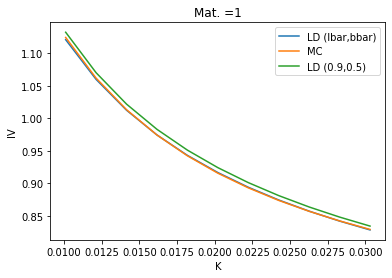

Diif ATM (LD - LD(lbar,bbar)) 0.9167766906864472
Diff ATM (MC - LD(l,b)) = -0.008540556023035606
Diff. max |MC -LD| 1.1212385336818897
Diff. max |MC- LD(l,b)| = 0.008745886120777868
Lambda_bar, b_bar =  0.8999967336413415 0.5000047976970279


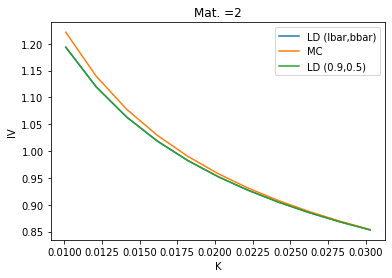

Diif ATM (LD - LD(lbar,bbar)) 0.952379254782727
Diff ATM (MC - LD(l,b)) = 0.005627306459246029
Diff. max |MC -LD| 1.1935103234384314
Diff. max |MC- LD(l,b)| = 0.027831140396301635


In [33]:
#Essai sur des parametres constants 
test2([0.9,0.9],[0.5,0.5],2)

Test for (l,b)= [0.9, 0.9] [0.5, 0.5]
((lambda_obs,b_obs))= [[0.9        0.50000001]
 [0.9        0.5       ]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 68
         Function evaluations: 128
lambda_Chey, b_Chey = [6.60321634 7.34558145] [0.07121422 0.08547272]
Param_LD =  [[0.89606768 0.49140037]
 [0.89750855 0.47936854]]


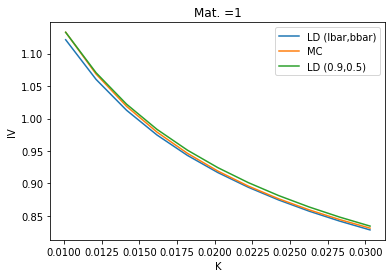

Diff ATM (MC - approx Log-displaced) 0.91907249126848
Diff ATM (MC - LD(l,b)) = -0.00526992543882443
Diff. max |MC - approx Log-displaced| 1.1327829457297867
Diff. max |MC- LD(l,b)| = 0.005349329869659414


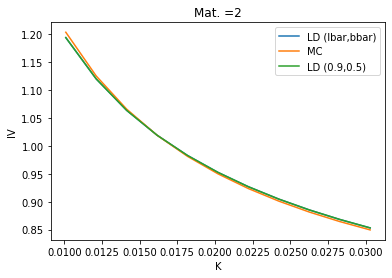

Diff ATM (MC - approx Log-displaced) 0.9497841358995629
Diff ATM (MC - LD(l,b)) = -0.0025993690655923274
Diff. max |MC - approx Log-displaced| 1.203102227383397
Diff. max |MC- LD(l,b)| = 0.009583770479366649


In [34]:
test2([0.9,0.9],[0.5,0.5],2)

## 3 maturités

Test for (l,b)= [0.6, 0.7, 0.8] [0.5, 0.5, 0.5]
((lambda_obs,b_obs))= [[0.6        0.49999999]
 [0.7        0.50000001]
 [0.8        0.5       ]]
Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 111
406.63233757019043 sec
Step 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 62
         Function evaluations: 121
1370.3554847240448 sec
Step 2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 69
         Function evaluations: 130
3022.2723846435547 sec
Exec. time: 4799.26020693779 sec
lambda_Chey, b_Chey = [4.36985664 5.66054417 6.10186846] [0.07181203 0.08903293 0.11416881]
Param_LD =  [[0.60154858 0.48020385]
 [0.69058143 0.49025443]
 [0.78722354 0.48793637]]
Lambda_bar, b_bar =  0.597996689925853 0.5020411260056895


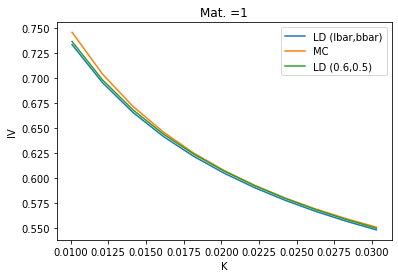

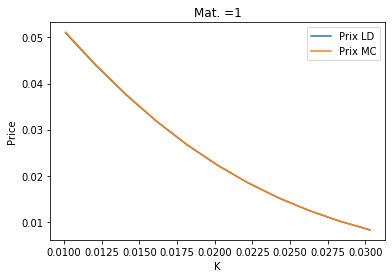

Diff ATM (LD(l,b) - LD(lbar,bbar)) -0.002092948907375103
Diff ATM (MC - LD(l,b)) = 0.0005863820570084499
Diff. max |LD(l,b) -LD(lbar,bbar)| 0.0030731546166862245
Diff. max |MC- LD(l,b)| = 0.009239746214007027
Lambda_bar, b_bar =  0.6959247985916222 0.5039493453460864


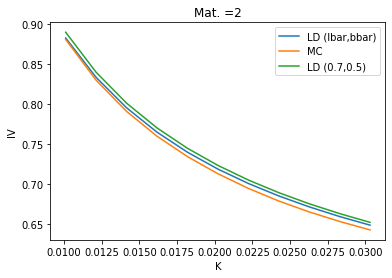

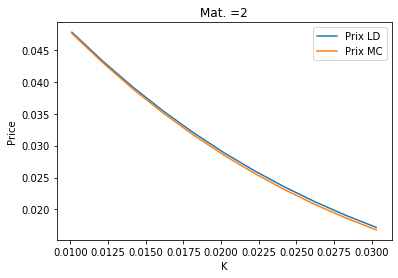

Diff ATM (LD(l,b) - LD(lbar,bbar)) -0.004626015559097141
Diff ATM (MC - LD(l,b)) = -0.010471155219420325
Diff. max |LD(l,b) -LD(lbar,bbar)| 0.007216882281682047
Diff. max |MC- LD(l,b)| = 0.010480389335043583
Lambda_bar, b_bar =  0.8000049876500832 0.5000035523159124


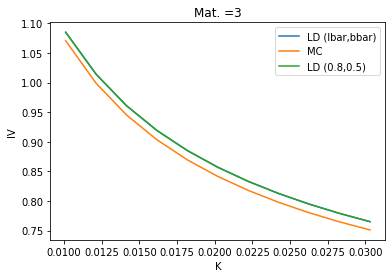

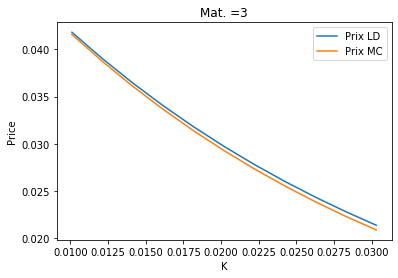

Diff ATM (LD(l,b) - LD(lbar,bbar)) 5.89703176956391e-06
Diff ATM (MC - LD(l,b)) = -0.01552072162667173
Diff. max |LD(l,b) -LD(lbar,bbar)| 6.720658802805701e-06
Diff. max |MC- LD(l,b)| = 0.015703153139838832


In [20]:
#lambda croissant
l = [0.6,0.7,0.8]
b = [0.5,0.5,0.5]
test2(l,b,3)

In [25]:
maturity_grid = [0,1,2,3]
l = [0.6,0.7,0.8]
b = [0.5,0.5,0.5]
term_date = 6

for i in range(0,3):
    T0 = maturity_grid[i+1]
    mat = np.arange(T0,term_date + 1,1)
    ZC_b = [np.exp(-r*m) for m in mat]
    S0 = S(0,0,0,mat,ZC_b,1,chi)
    A0 = A(0,0,0,mat,ZC_b,1,chi)
    prix_LD = log_displaced(S0,A0,T0,S0,l[i],b[i])
    IV_LD = biss_python(prix_LD, ZC_b, S0, mat,"log-normal")
    print(T0,IV_LD)

1 0.6069464993277052
2 0.723246734961549
3 0.856822784154474


**Remarque:** Comme une amplification de l'erreur à chaque étape, cela provient il du code ou de la calibration? 



Test for (l,b)= [0.8, 0.7, 0.6] [0.5, 0.5, 0.5]
((lambda_obs,b_obs))= [[0.8        0.50000001]
 [0.7        0.50000001]
 [0.6        0.5       ]]
Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 117
410.6294047832489 sec
Step 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 126
1406.386463880539 sec
Step 2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 63
         Function evaluations: 119
2597.8222024440765 sec
Exec. time: 4414.838071107864 sec
lambda_Chey, b_Chey = [5.85313611 5.49187266 4.27391971] [0.07144108 0.08564497 0.10780142]
Param_LD =  [[0.79551885 0.50697219]
 [0.68903675 0.49852186]
 [0.58390012 0.49555906]]
Lambda_bar, b_bar =  0.7952203901928278 0.5036662808505252


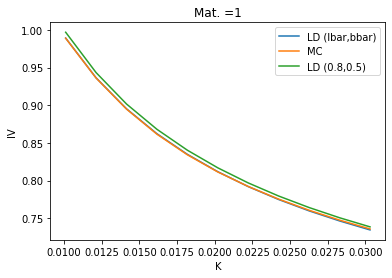

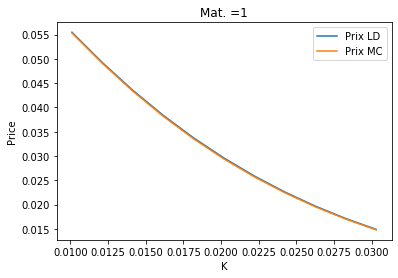

Diif ATM (LD - LD(lbar,bbar)) -0.005173173062757996
Diff ATM (MC - LD(l,b)) = -0.00549691072819769
Diff. max |MC -LD| 0.007738551778402325
Diff. max |MC- LD(l,b)| = 0.00798242168912111
Lambda_bar, b_bar =  0.6965233501659943 0.5036675210131036


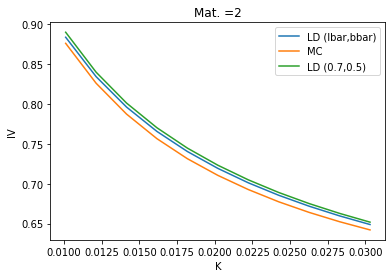

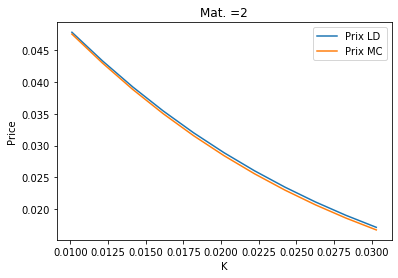

Diif ATM (LD - LD(lbar,bbar)) -0.0039566061263940355
Diff ATM (MC - LD(l,b)) = -0.012714730389689066
Diff. max |MC -LD| 0.006267028270485753
Diff. max |MC- LD(l,b)| = 0.013894260077904619
Lambda_bar, b_bar =  0.5999980958893313 0.4999967414724202


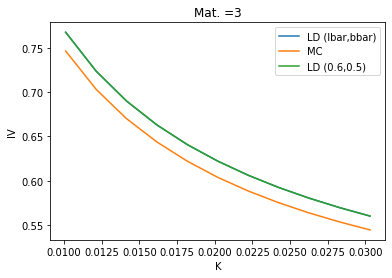

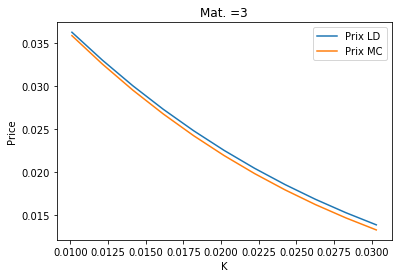

Diif ATM (LD - LD(lbar,bbar)) -2.0288121049816255e-06
Diff ATM (MC - LD(l,b)) = -0.01827724853910695
Diff. max |MC -LD| 2.202937139372807e-06
Diff. max |MC- LD(l,b)| = 0.021160862402211933


In [45]:
#lambda décroissant
l = [0.8,0.7,0.6]
b = [0.5,0.5,0.5]
test2(l,b,3)

Test for (l,b)= [0.9, 0.6, 0.3] [0.5, 0.5, 0.5]
((lambda_obs,b_obs))= [[0.9        0.5       ]
 [0.6        0.5       ]
 [0.3        0.49999999]]
Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 109
394.84475326538086 sec
Step 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 84
         Function evaluations: 164
1974.9228494167328 sec
Step 2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 52
         Function evaluations: 99
2275.6680805683136 sec
Exec. time: 4645.435683250427 sec
lambda_Chey, b_Chey = [6.60321634 4.42132903 1.49392806] [0.07121422 0.07753535 0.00753554]
Param_LD =  [[0.89694229 0.49896554]
 [0.58690136 0.4916536 ]
 [0.29390466 0.35649786]]
Lambda_bar, b_bar =  0.8931622995890657 0.504670137145032


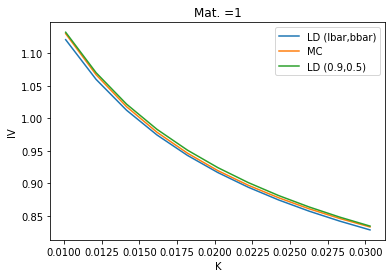

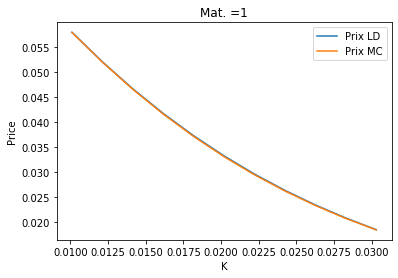

Diif ATM (LD - LD(lbar,bbar)) -0.007565726020857255
Diff ATM (MC - LD(l,b)) = -0.0046165603316694614
Diff. max |MC -LD| 0.011456180968707486
Diff. max |MC- LD(l,b)| = 0.004631865108422062
Lambda_bar, b_bar =  0.5984333644726596 0.5023084222433585


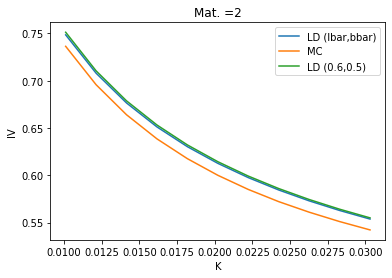

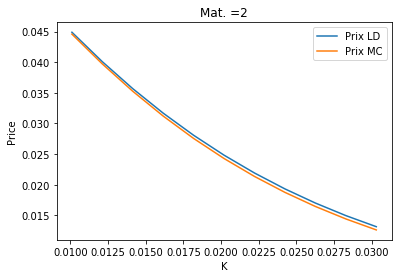

Diif ATM (LD - LD(lbar,bbar)) -0.001727776868847286
Diff ATM (MC - LD(l,b)) = -0.01435559572200873
Diff. max |MC -LD| 0.0027823918435387895
Diff. max |MC- LD(l,b)| = 0.014888132673149812
Lambda_bar, b_bar =  0.30000332560483084 0.4999981897923571


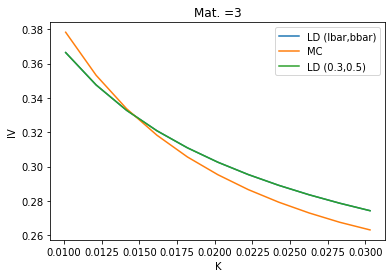

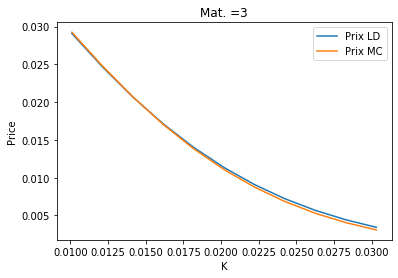

Diif ATM (LD - LD(lbar,bbar)) 3.4191452868981287e-06
Diff ATM (MC - LD(l,b)) = -0.0072716918657533824
Diff. max |MC -LD| 4.402475042297738e-06
Diff. max |MC- LD(l,b)| = 0.011832511788725242


In [21]:
#lambda décroissant 2
l = [0.9,0.6,0.3]
b = [0.5,0.5,0.5]
test2(l,b,3)

Test for (l,b)= [0.5, 0.5, 0.5] [0.5, 0.7, 0.9]
((lambda_obs,b_obs))= [[0.5        0.5       ]
 [0.5        0.70000002]
 [0.5        0.9       ]]
Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 109
405.4472177028656 sec
Step 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 59
         Function evaluations: 113
1341.987672328949 sec
Step 2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 54
         Function evaluations: 103
2401.461655855179 sec
Exec. time: 4148.896545886993 sec
lambda_Chey, b_Chey = [3.63510878 3.938434   3.60436263] [0.0719562  0.12954883 0.21775818]
Param_LD =  [[0.49418597 0.52013455]
 [0.48702906 0.7144404 ]
 [0.47810017 0.86052998]]
Lambda_bar, b_bar =  0.49884715327047857 0.5014082449593673


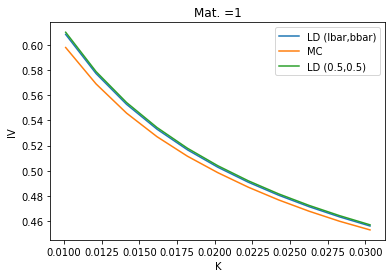

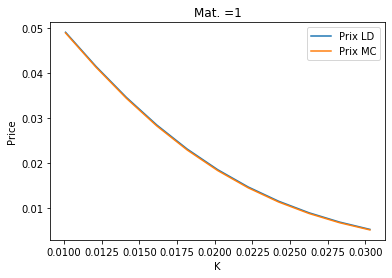

Diif ATM (LD - LD(lbar,bbar)) -0.0011882027820320218
Diff ATM (MC - LD(l,b)) = -0.005516473888746987
Diff. max |MC -LD| 0.001733004346533562
Diff. max |MC- LD(l,b)| = 0.012131172268254886
Lambda_bar, b_bar =  0.49810249363979203 0.7037875150601838


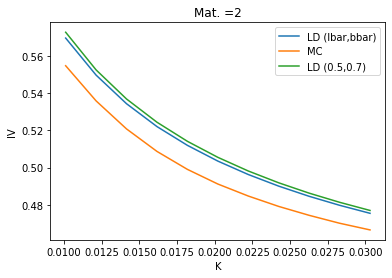

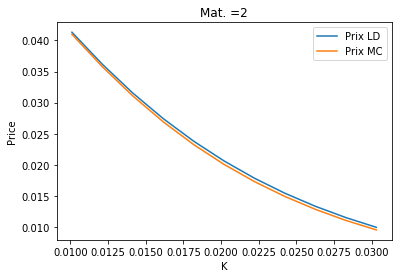

Diif ATM (LD - LD(lbar,bbar)) -0.002018698464780755
Diff ATM (MC - LD(l,b)) = -0.014334361269447982
Diff. max |MC -LD| 0.003129017409264634
Diff. max |MC- LD(l,b)| = 0.017988038409839646
Lambda_bar, b_bar =  0.4999995182239237 0.9000071213860587


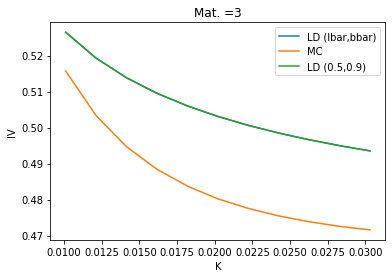

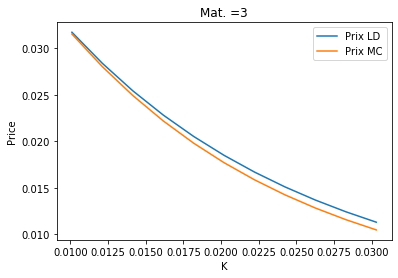

Diif ATM (LD - LD(lbar,bbar)) -7.014727998466697e-07
Diff ATM (MC - LD(l,b)) = -0.02288905177920242
Diff. max |MC -LD| 2.382835191383492e-06
Diff. max |MC- LD(l,b)| = 0.023064930194323097


In [21]:
#lambda constant, b croissant
l = [0.5,0.5,0.5]
b = [0.5,0.7,0.9]
test2(l,b,3)

Test for (l,b)= 0.5 0.9
Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 107
lambda_Chey, b_Chey = 3.6320604685649966 0.21499395739980645
slope ATM: 1.467407489103624
Param_LD =  [[0.47496643 0.86940274]]


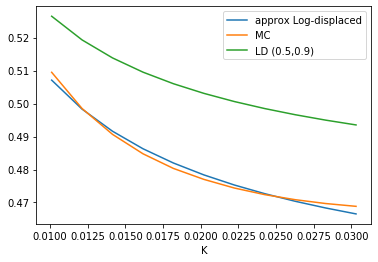

Diff ATM (MC - approx Log-displaced) -0.0016450969928882841
Diff ATM (MC - LD(l,b)) = -0.026088622939823836
Diff. max |MC - approx Log-displaced| 0.0023735058994134306
Diff. max |MC- LD(l,b)| = 0.026229496199903224


In [24]:
test(0.5,0.9)

Test for (l,b)= [0.5, 0.5, 0.5] [0.9, 0.7, 0.5]
((lambda_obs,b_obs))= [[0.5        0.9       ]
 [0.5        0.70000002]
 [0.5        0.5       ]]
Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 62
         Function evaluations: 118
438.6697459220886 sec
Step 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 78
         Function evaluations: 148
1772.337252855301 sec
Step 2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 109
2522.2222740650177 sec
Exec. time: 4733.229272842407 sec
lambda_Chey, b_Chey = [3.62829101 3.93737906 3.65005382] [0.14002109 0.1275656  0.11103515]
Param_LD =  [[0.4974945  0.86358601]
 [0.48926658 0.70522474]
 [0.48813544 0.48635083]]
Lambda_bar, b_bar =  0.49793022347942023 0.9048134804267323


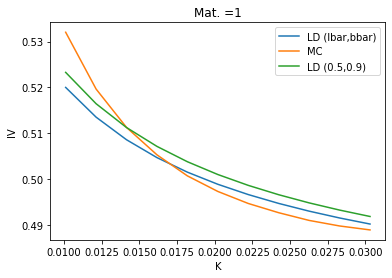

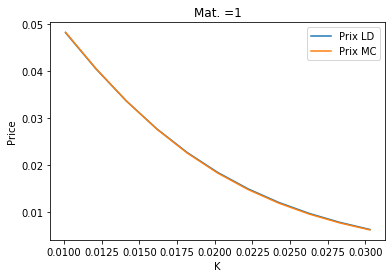

Diif ATM (LD - LD(lbar,bbar)) -0.0021277184873724764
Diff ATM (MC - LD(l,b)) = -0.0036909761365677696
Diff. max |MC -LD| 0.0032774118290035403
Diff. max |MC- LD(l,b)| = 0.008750577371756663
Lambda_bar, b_bar =  0.498131679086522 0.7038120585312433


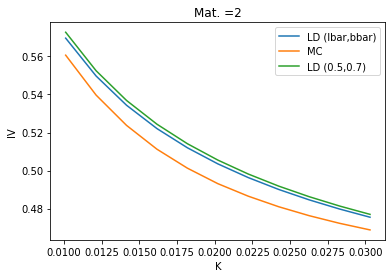

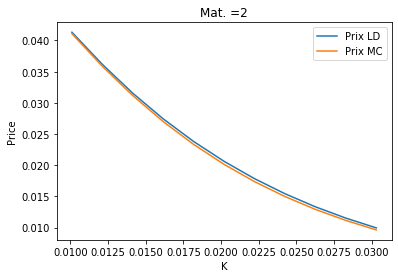

Diif ATM (LD - LD(lbar,bbar)) -0.0019889165014319587
Diff ATM (MC - LD(l,b)) = -0.012389614673793403
Diff. max |MC -LD| 0.0031002096625343256
Diff. max |MC- LD(l,b)| = 0.01314059647029353
Lambda_bar, b_bar =  0.500001525214589 0.5000029338111748


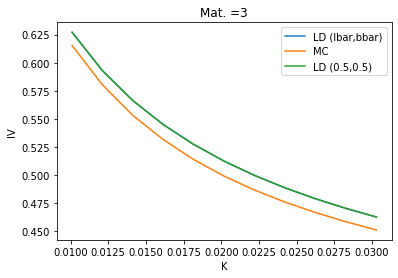

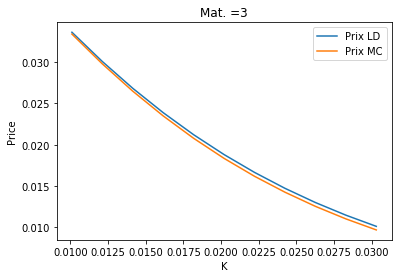

Diif ATM (LD - LD(lbar,bbar)) 1.5941941455821507e-06
Diff ATM (MC - LD(l,b)) = -0.013345973973173386
Diff. max |MC -LD| 1.7194315660162829e-06
Diff. max |MC- LD(l,b)| = 0.013420462557860446


In [22]:
#lambda constant, b décroissant
l = [0.5,0.5,0.5]
b = [0.9,0.7,0.5]
test2(l,b,3)

In [29]:
0.0077 /0.8568

0.008986928104575164

$Max | MC-LD(l,b)|$

|   | $T_1$ | $T_2$ | $T_3$ |
|---|----------|----------|----------|
|$\lambda$ croissant| 0.0079 (1.3%)| 0.0123 (1.7%) | 0.0219 (2.6%) |
|$\lambda$ décroissant| 0.0080 (0.9%)| 0.0139 (1.9%)|  0.0212 (3.5%) |
|$b$ croissant|0.0121 (2.4%)|  0.0180 (3.6%) |0.0231 (4.6%) |
|$b$ décroissant |  0.0088  (1.7%)   |  0.0131 (2.6%)  | 0.0134 (2.7%) |

$Max | LD(\bar{\lambda},\bar{b})-LD(\lambda,b)|$

|   | $T_1$ | $T_2$ | $T_3$ |
|---|----------|----------|----------|
|$\lambda$ croissant| 0.0031 (0.5%) | 0.0072 (%)| 6.72e-6  (0%)  |
|$\lambda$ décroissant|0.0077 (0.9%)| 0.0063  (0.9%)      | 2.2e-6 (0%) |
|$b$ croissant| 0.0017 (0.3%)|  0.0031 (0.6%) | 2.38e-6 (0%)|
|$b$ décroissant |  0.0033  (0.66%)      |  0.0031   (0.6%)         | 1.71e-6 (0%) |

### tests sur l'effet de la maturité

Test for (l,b)= 0.3 0.5
Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 102
lambda_Chey, b_Chey = 2.1919990421803237 0.11480900866038385
slope ATM: 3.853037842345058
Param_LD =  [[0.29252164 0.47703585]]


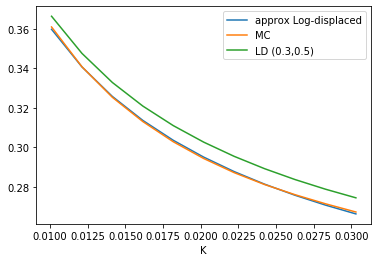

Diff ATM (MC - approx Log-displaced) -0.0007391350845864508
Diff ATM (MC - LD(l,b)) = -0.008301453190142638
Diff. max |MC - approx Log-displaced| 0.0011798905143223237
Diff. max |MC- LD(l,b)| = 0.008301453190142638


In [23]:
# test with a one maturity swaption strip at 3Y
test(0.3,0.5)

On déduit de cela que le fait de fixer les paramètres sur les intervalles de temps précédent aurait un effet négligeable sur la calibration, mais que la courbe MC peut changer de manière conséquente suivant les paramètres calibrés. 

La différence observée sur certaines courbes ne semble pas être due à un changement dans les paramètres LD qui contraignent la calibration à l'étape suivante. Cela pourrait simplement provenir du changement de maturité

Test for (l,b)= [0.5, 0.5, 0.5] [0.5, 0.7, 0.9]
((lambda_obs,b_obs))= [[0.5        0.5       ]
 [0.5        0.70000002]
 [0.5        0.9       ]]
Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 109
411.6168007850647 sec
Step 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 59
         Function evaluations: 113
1361.654536485672 sec
Step 2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 54
         Function evaluations: 103
2355.6834032535553 sec
Exec. time: 4128.970330715179 sec
lambda_Chey, b_Chey = [3.63510878 3.938434   3.60436263] [0.0719562  0.12954883 0.21775818]
Param_LD =  [[0.49772144 0.50107668]
 [0.48887608 0.72245269]
 [0.47630825 0.88540764]]
Lambda_bar, b_bar =  0.49884715327047857 0.5014082449593673


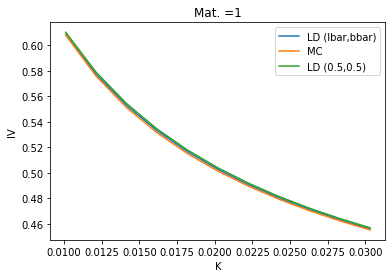

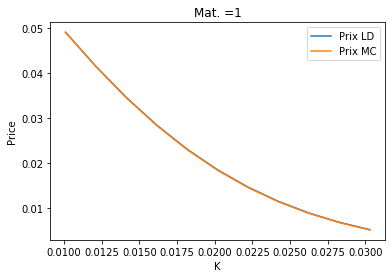

Diff ATM (LD(l,b) - LD(lbar,bbar)) -0.0011882027820320218
Diff ATM (MC - LD(l,b)) = -0.0026170238265876833
Diff. max |LD(l,b) -LD(lbar,bbar)| 0.001733004346533562
Diff. max |MC- LD(l,b)| = 0.003111656931196194
Lambda_bar, b_bar =  0.49810249363979203 0.7037875150601838


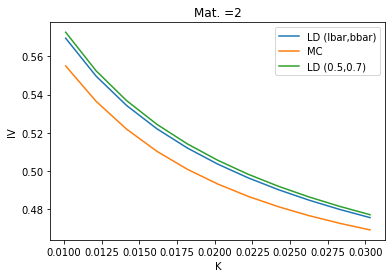

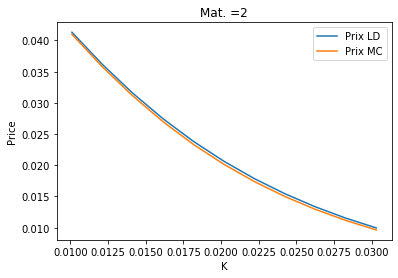

Diff ATM (LD(l,b) - LD(lbar,bbar)) -0.002018698464780755
Diff ATM (MC - LD(l,b)) = -0.012451810034690425
Diff. max |LD(l,b) -LD(lbar,bbar)| 0.003129017409264634
Diff. max |MC- LD(l,b)| = 0.017679264840353426
Lambda_bar, b_bar =  0.4999995182239237 0.9000071213860587


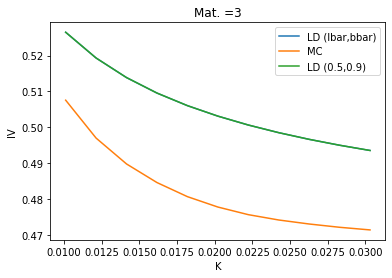

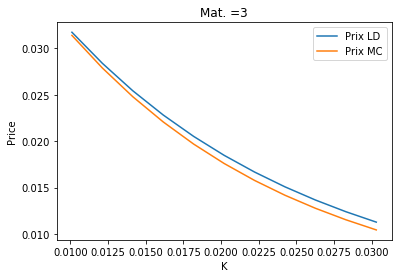

Diff ATM (LD(l,b) - LD(lbar,bbar)) -7.014727998466697e-07
Diff ATM (MC - LD(l,b)) = -0.025346816862565902
Diff. max |LD(l,b) -LD(lbar,bbar)| 2.382835191383492e-06
Diff. max |MC- LD(l,b)| = 0.025373439273153053
Test for (l,b)= 0.5 0.9
Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 107
lambda_Chey, b_Chey = 3.6320604685649966 0.21499395739980645
slope ATM: 1.1179047466411618
Param_LD =  [[0.47343988 0.90060889]]


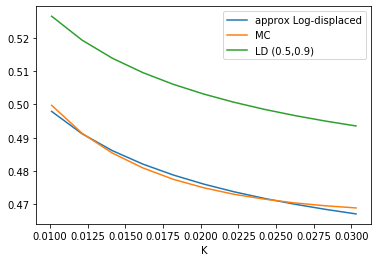

Diff ATM (MC - approx Log-displaced) -0.0012958766615156492
Diff ATM (MC - LD(l,b)) = -0.02815898426433705
Diff. max |MC - approx Log-displaced| 0.0018327330553802312
Diff. max |MC- LD(l,b)| = 0.028629187861497485


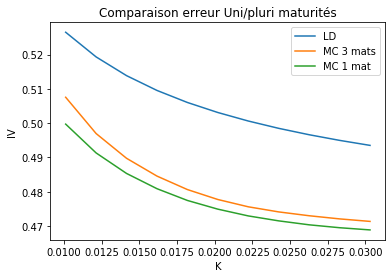

In [38]:
#Graphe avec les 3 courbes MC 1 mat, LD(l,b) et MC 3 mats
l = [0.5,0.5,0.5]
b = [0.5,0.7,0.9]
IV1,IV_LD = test2(l,b,3) 

maturities = np.arange(3,7,1)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
strikes = [0.1*k*S0 for k in range(5,16)] # 70% to 130% of the strike ATM
IV2 = test(l[2],b[2])

plt.plot(strikes,IV_LD[2],label="LD")
plt.plot(strikes,IV1[2],label="MC 3 mats")
plt.plot(strikes,IV2[0],label="MC 1 mat")
plt.legend()
plt.title("Comparaison erreur Uni/pluri maturités")
plt.xlabel('K')
plt.ylabel('IV')
plt.show()

**Observation:** L'erreur entre la courbe MC et LD est quasiment la même pour ce test que pour la calibration à 3 maturités. On peut donc en conclure que le shift observé entre ces deux courbes semble s'accroître entre chaque maturité et qu'il provient essentiellement du changement de tenor dans le swap sous jacent 

### Surface de différence de vol entre MC et l'approximation LD

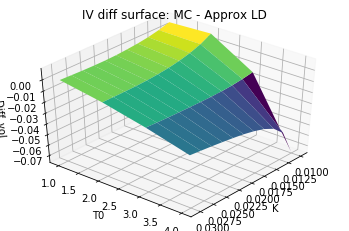

In [43]:
#Surface de la différence de Vol. impli entre MC et Aprrox_LD
N,M = 250,100000
maturités = [1,2,3,4]
lambda_Chey = 6 #On reprend les parametre Pit calibrés pour une entrée LD(0.8,0.5)
b_Chey = 0.11
Diff_vol = np.zeros((4,11))

for i in range(4):
    T0 = maturités[i]
    maturities = np.arange(T0,7,1)
    bonds = [np.exp(-r*m) for m in maturities]
    S0 = S(0,0,0,maturities,bonds,1,chi)
    A0 = A(0,0,0,maturities,bonds,1,chi)
    strikes = [0.1*k*S0 for k in range(5,16)] # 50% to 150% of the strike ATM
    maturity_grid = [0,T0,6]
    
    sim = simul_pc([lambda_Chey],S0,[b_Chey],chi,maturity_grid,N,M)
    prix_MC = [swaption_MC(M,sim,k,chi,bonds,maturities) for k in strikes]
    
    lbar = lambda_bar(maturities, bonds, maturity_grid,lambda_Chey, b_Chey, lambda_Chey, b_Chey, chi)
    bbar = b_bar(maturities, bonds, maturity_grid,lambda_Chey,b_Chey , lambda_Chey, b_Chey, chi)
    prix_LD = [log_displaced(S0,A0,T0,k,lbar,bbar) for k in strikes]
    
    Diff_vol[i] = np.array([biss_python(prix_MC[m], bonds, strikes[m], maturities,"log-normal") for m in range(len(strikes))]) - np.array([biss_python(prix_LD[m], bonds, strikes[m], maturities,"log-normal") for m in range(len(strikes))])
    
X,Y = np.meshgrid(strikes, maturités)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Diff_vol, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('K')
ax.set_ylabel('T0')
ax.set_zlabel('Diff_vol')
plt.title("IV diff surface: MC - Approx LD")
ax.view_init(40,40)
plt.show()

In [22]:
#Plot la surface de la diff de vol impli entre MC et l'approx LD pour toutes les maturités jusqu'a tenor -1Y

# Reprendre les parametres Piterbarg constants par morceaux 

def surf_diff(tenor,lambda_Chey,b_Chey):
    N,M = 250,100000
    maturités = range(1,tenor)
    Diff_vol = np.zeros((len(maturités),11))

    #for i in range(0,tenor-1):
    for i in range(0,len(maturités)):
        T0 = maturités[i]
        maturities = np.arange(T0,tenor+2,1)
        bonds = [np.exp(-r*m) for m in maturities]
        S0 = S(0,0,0,maturities,bonds,1,chi)
        A0 = A(0,0,0,maturities,bonds,1,chi)
        strikes = [0.1*k*S0 for k in range(5,16)] # 50% to 150% of the strike ATM
        maturity_grid = [0,T0,1+tenor]

        sim = simul_pc([lambda_Chey],S0,[b_Chey],chi,maturity_grid,N,M)
        prix_MC = [swaption_MC(M,sim,k,chi,bonds,maturities) for k in strikes]

        lbar = lambda_bar(maturities, bonds, maturity_grid,lambda_Chey, b_Chey, lambda_Chey, b_Chey, chi)
        bbar = b_bar(maturities, bonds, maturity_grid,lambda_Chey,b_Chey , lambda_Chey, b_Chey, chi)
        prix_LD = [log_displaced(S0,A0,T0,k,lbar,bbar) for k in strikes]

        Diff_vol[i] = np.absolute(np.array([biss_python(prix_MC[m], bonds, strikes[m], maturities,"log-normal") for m in range(len(strikes))]) - np.array([biss_python(prix_LD[m], bonds, strikes[m], maturities,"log-normal") for m in range(len(strikes))]))
        print("T0 = " + str(T0) + ": Diff ATM=",Diff_vol[i][5])
        
    X,Y = np.meshgrid(strikes, maturités)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Diff_vol, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('K')
    ax.set_ylabel('T0')
    ax.set_zlabel('Diff_vol')
    plt.title("IV diff surface: MC - Approx LD")
    ax.view_init(40,40)
    plt.show()

T0 = 1: Diff ATM= -0.001490728077442327
T0 = 2: Diff ATM= -0.009734620023209573
T0 = 3: Diff ATM= -0.018552340764017572
T0 = 4: Diff ATM= -0.02848111717867141
T0 = 5: Diff ATM= -0.032820539395288506
T0 = 6: Diff ATM= -0.03814506887465541
T0 = 7: Diff ATM= -0.04920378354654531
T0 = 8: Diff ATM= -0.05443958629257395
T0 = 9: Diff ATM= -0.07277884830727999


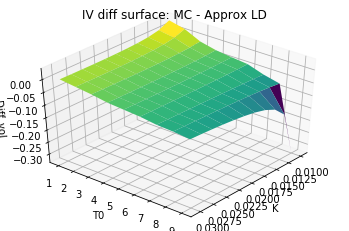

In [30]:
#Tenor 10Y (terminal date =11Y)
surf_diff(10,6,0.11)

T0 = 1: Diff ATM= 0.008521320553427358
T0 = 2: Diff ATM= 0.02199149314492388
T0 = 3: Diff ATM= 0.034849955000026966
T0 = 4: Diff ATM= 0.04920719615938651
T0 = 5: Diff ATM= 0.05378912444712114
T0 = 6: Diff ATM= 0.06748505486939393
T0 = 7: Diff ATM= 0.08343173237562951
T0 = 8: Diff ATM= 0.09945623615294608
T0 = 9: Diff ATM= 0.13598669532484564


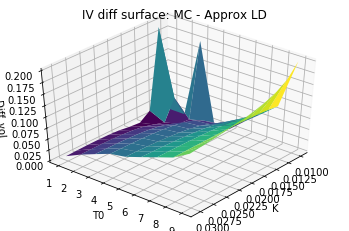

In [33]:
# calibration sur (l,b) = (0.8,0.9)
l_Chey = 6.069
b_Chey = 0.206
surf_diff(10,l_Chey,b_Chey)

T0 = 1: Diff ATM= 0.005979998366001382
T0 = 2: Diff ATM= 0.01321374859799107
T0 = 3: Diff ATM= 0.0205459232006433
T0 = 4: Diff ATM= 0.02853872322702955
T0 = 5: Diff ATM= 0.03532949542886854
T0 = 6: Diff ATM= 0.04043399003194281
T0 = 7: Diff ATM= 0.04698828424352541
T0 = 8: Diff ATM= 0.053195395410057245
T0 = 9: Diff ATM= 0.0586275511977874
T0 = 10: Diff ATM= 0.06554209327987337
T0 = 11: Diff ATM= 0.07129748970100991
T0 = 12: Diff ATM= 0.08795524525794463
T0 = 13: Diff ATM= 0.1097043588060842


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if __name__ == '__main__':


Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars


Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if __name__ == '__main__':


Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche racine non convergente
Recherche 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


T0 = 14: Diff ATM= 0.5959629847302494


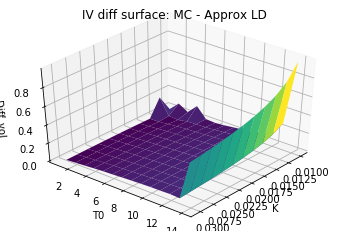

In [26]:
surf_diff(15,6,0.11)

Ce graphe explique le shift entre la courbe MC et LD que l'on peut observer sur le test (0.8,0.5) par exemple.

Test for (l,b)= [0.8, 0.8, 0.8, 0.8] [0.5, 0.5, 0.5, 0.5]
((lambda_obs,b_obs))= [[0.8        0.50000001]
 [0.8        0.5       ]
 [0.8        0.5       ]
 [0.8        0.5       ]]
Step 0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 117
425.4392397403717 sec
Step 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 65
         Function evaluations: 121
1346.6771473884583 sec
Step 2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 68
         Function evaluations: 130
2863.5803401470184 sec
Step 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 60
         Function evaluations: 110
3776.6217262744904 sec
Exec. time: 8412.319419145584 sec
lambda_Chey, b_Chey = [5.85313611 6.41780784 5.93766474 4.90169994] [0.07144108 0.08718194 0.11254478 0.152631

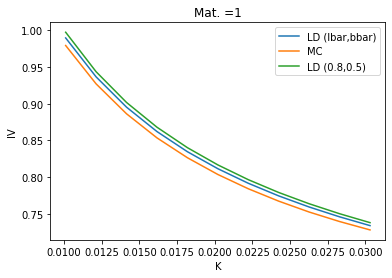

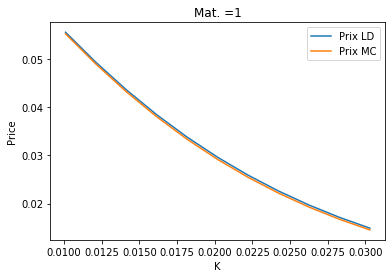

Diff ATM (LD(l,b) - LD(lbar,bbar)) -0.005173173062757996
Diff ATM (MC - LD(l,b)) = -0.013011923579142604
Diff. max |LD(l,b) -LD(lbar,bbar)| 0.007738551778402325
Diff. max |MC- LD(l,b)| = 0.018009517000336928
Lambda_bar, b_bar =  0.7942638093652188 0.505053169521053


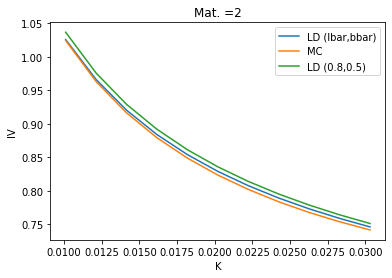

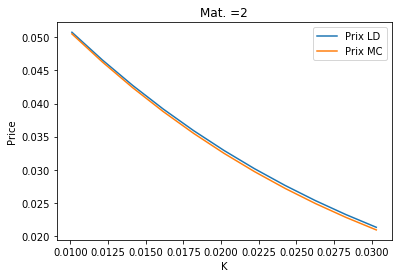

Diff ATM (LD(l,b) - LD(lbar,bbar)) -0.0068012853216714575
Diff ATM (MC - LD(l,b)) = -0.012288795712720457
Diff. max |LD(l,b) -LD(lbar,bbar)| 0.010953441892525007
Diff. max |MC- LD(l,b)| = 0.01275880583534672
Lambda_bar, b_bar =  0.7946550051185043 0.5051675374421377


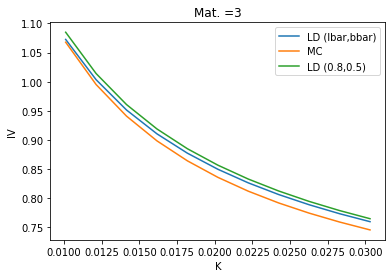

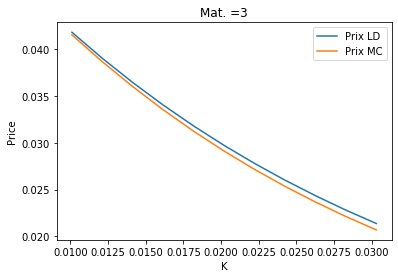

Diff ATM (LD(l,b) - LD(lbar,bbar)) -0.007029864420928789
Diff ATM (MC - LD(l,b)) = -0.020893948315006128
Diff. max |LD(l,b) -LD(lbar,bbar)| 0.01233224123097898
Diff. max |MC- LD(l,b)| = 0.020893948315006128
Lambda_bar, b_bar =  0.8000026208333354 0.4999977447449665


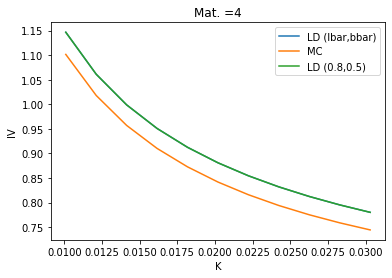

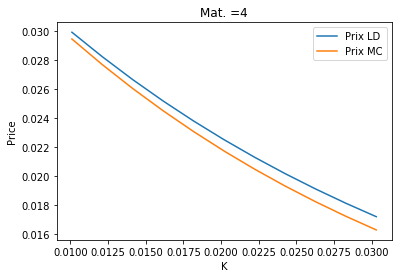

Diff ATM (LD(l,b) - LD(lbar,bbar)) 3.836958057945594e-06
Diff ATM (MC - LD(l,b)) = -0.03915425188552035
Diff. max |LD(l,b) -LD(lbar,bbar)| 7.327846560656326e-06
Diff. max |MC- LD(l,b)| = 0.04510651216378392


(array([[0.97902667, 0.92691191, 0.88627017, 0.85355632, 0.82659726,
         0.80383949, 0.78445074, 0.76761789, 0.75283979, 0.73992134,
         0.72854555],
        [1.02417405, 0.96289427, 0.91622252, 0.87903722, 0.84865372,
         0.82335439, 0.80194149, 0.78345382, 0.76752013, 0.75365495,
         0.74147635],
        [1.06778122, 0.99516559, 0.94091423, 0.89848089, 0.86422723,
         0.83592884, 0.81215771, 0.79193787, 0.77450381, 0.7592387 ,
         0.7457061 ],
        [1.10143553, 1.0179024 , 0.95699257, 0.9102146 , 0.87275043,
         0.84185459, 0.81605591, 0.79411789, 0.77527687, 0.75888823,
         0.74448422]]),
 array([[0.99703619, 0.94340057, 0.90165397, 0.86803703, 0.84026327,
         0.81685142, 0.79679433, 0.77938047, 0.76409126, 0.7505388 ,
         0.73842655],
        [1.03655122, 0.97565307, 0.92893034, 0.89170218, 0.86119411,
         0.83564319, 0.81386874, 0.79504673, 0.77858253, 0.76403509,
         0.75106962],
        [1.08488037, 1.01402987, 0.960

In [22]:
#Tests avec parametres Pit. picewise constant
l = [0.8,0.8,0.8,0.8]
b = [0.5,0.5,0.5,0.5]
test2(l,b,4)

---

Pente Approx: 1181.54


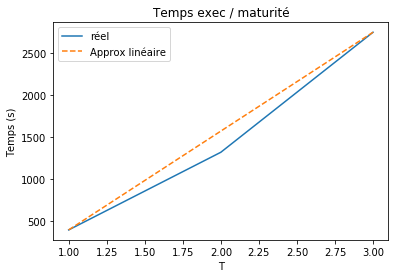

In [41]:
temps_exec = [390.65,1319.12,2753.73]
coef = (temps_exec[2]-temps_exec[0])/2
droite = [coef * x + (390.65 -coef) for x in range(1,4)]
plt.plot([1,2,3],temps_exec,label="réel")
plt.plot([1,2,3],droite,'--',label="Approx linéaire")
print("Pente Approx:", coef)
plt.title("Temps exec / maturité")
plt.xlabel("T")
plt.ylabel("Temps (s)")
plt.legend()
plt.show()

| Maturités | Temps (sec)  |  
|--------------|-----------|
|  1           | 408.517     | 
|  2           | 1912.299    | 
|  3           | 4523.910    |

Test for (l,b)= [0.5] [0.9]
((lambda_obs,b_obs))= [[0.5 0.9]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 117
lambda_Chey, b_Chey = [3.6437048] [0.1391929]
Param_LD =  [[0.49930469 0.8664569 ]]


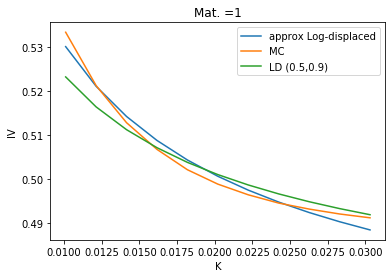

Diff ATM (MC - approx Log-displaced) -0.0017864868641481735
Diff ATM (MC - LD(l,b)) = -0.002173511077216972
Diff. max |MC - approx Log-displaced| 0.003279873949395551
Diff. max |MC- LD(l,b)| = 0.01018325749100768


In [41]:
l = [0.5]
b = [0.9]
test2(l,b,1)

Test for (l,b)= 0.5 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 117
lambda_Chey, b_Chey = 3.6437048045927316 0.13919290092682696
slope ATM: 1.3318302116601335
Param_LD =  [[0.49724479 0.89091589]]


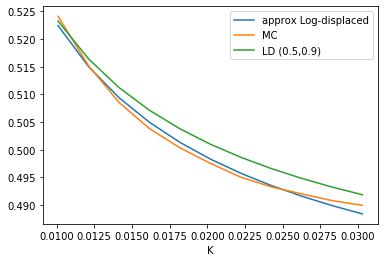

Diff ATM (MC - approx Log-displaced) -0.0009790599756343
Diff ATM (MC - LD(l,b)) = -0.0034572087702144927
Diff. max |MC - approx Log-displaced| 0.0016897746399990865
Diff. max |MC- LD(l,b)| = 0.0035969638042843144


In [40]:
test(0.5,0.9)

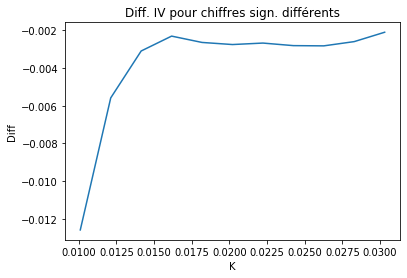

In [33]:
#tester manuellement si la différence ne provient pas des chiffres sign. dans les param. Cheyette

maturity_grid = [0,1,6]
N,M = 250,100000
maturities = np.arange(1,7,1)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
strikes = [0.1*k*S0 for k in range(5,16)] 

lmbda1,b1 = 3.6437048, 0.1391929
sim1 = simul_pc([lmbda1],S0,[b1],chi,maturity_grid,N,M)
Prices = [swaption_MC(M,sim1,k,chi,bonds,maturities) for k in strikes]
IV1 = [biss_python(Prices[m], bonds, strikes[m], maturities,"log-normal") for m in range(len(strikes))]

lmbda2,b2 = 3.6437048045927316, 0.13919290092682696
sim2 = simul_pc([lmbda2],S0,[b2],chi,maturity_grid,N,M)
Prices2 = [swaption_MC(M,sim2,k,chi,bonds,maturities) for k in strikes]
IV2 = [biss_python(Prices2[m], bonds, strikes[m], maturities,"log-normal") for m in range(len(strikes))]

plt.plot(strikes, np.array(IV1) - np.array(IV2))
plt.title("Diff. IV pour nb decimales différents")
plt.xlabel("K")
plt.ylabel("Diff")
plt.show()

In [50]:
l = [0.7]
b = [0.5]

maturity_grid = [0,1,6]
term_date = maturity_grid[-1]
delta = 1
IV = np.zeros((len(maturity_grid)-2,11))

for i in range(1,len(maturity_grid)-1):
    T0 = maturity_grid[i]
    maturities = np.arange(T0,term_date + delta,delta)
    bonds = [np.exp(-r*m) for m in maturities]
    S0 = S(0,0,0,maturities,bonds,1,chi)
    A0 = A(0,0,0,maturities,bonds,1,chi)
    strikes = [0.1*k*S0 for k in range(5,16)] # 50% to 150% of the strike ATM
    IV[i-1] = [biss_python(log_displaced(S0,A0,T0,strikes[m],l[i-1],b[i-1]), bonds, strikes[m], maturities) for m in range(len(strikes))]
    slope_atm = abs((biss_python(log_displaced(S0,A0,T0,0.95*S0,0.7,0.5), bonds, 0.95*S0, maturities,"log-normal") - biss_python(log_displaced(S0,A0,T0,1.05*S0,0.7,0.5), bonds, 1.05*S0, maturities,"log-normal"))/(0.1*S0))

print("IV_atm,slope_atm = ",IV[0][5],slope_atm)

data = data_set_bis(maturity_grid,strikes,IV,chi,delta,IV[:,5],[1])
print("Starting point 1: lambda_obs, b_obs=",data)
data = data_set_bis(maturity_grid,strikes,IV,chi,delta,IV[:,5],[9.19])
print("Starting point 9.19: lambda_obs, b_obs=",data)

IV_atm,slope_atm =  0.7111489360443102 9.195693688418013
Starting point 1: lambda_obs, b_obs= [[0.7        0.50000001]]
Starting point 9.19: lambda_obs, b_obs= [[3.50336093 4.04487537]]


-> Limite supérieure de la pente ATM fixée à 5, au delà on impose 1 pour éviter les valeurs aberrantes.

## Observation des courbes générées après une étape de calibration

On va 
- 1) Tracer les courbes LD générées pour différents paramètres $\lambda_1,b_1$ plausibles sur $[0,T_1]$

- 2) Fixer $\lambda_1 = 2 \quad b_1 = 0.15$ et tracer les courbes générées avec $\lambda_1,\lambda_2 \quad b_1,b_2$ sur $[0,T_2]$

L'objectif est de voir comment évoluent les courbes en fixant $\lambda_1,b_1$ et en faisant varier seulement les paramètres sur $[T_1,T_2]$

Text(0.5, 1.0, 'IV. sur [T1,T2] avec l1,b1 fixés')

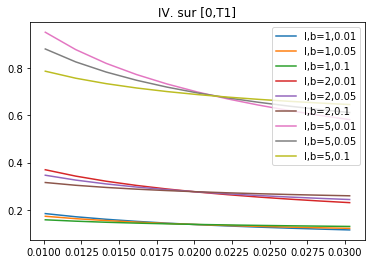

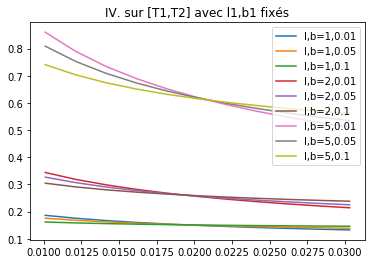

In [23]:
# 1.On va faire varier lambda et b pour voir l'évolution de la courbe de vol sur une maturité
# 2. On fixe à présent lambda1,b1 et on fait varier lambda2,b2 pour comparer leur effet sur la vol pour deux maturités

l_vals = [1,2,5]
b_vals = [0.01,0.05,0.1]

maturity_grid = [0,1,6]
maturity_grid2 = [0,1,2,6]
maturities = np.arange(1,7,1)
maturities2 = np.arange(2,7,1)
bonds = [np.exp(-r*m) for m in maturities]
bonds2 = [np.exp(-r*m) for m in maturities2]
S0 = S(0,0,0,maturities,bonds,1,chi)
A0 = A(0,0,0,maturities,bonds,1,chi)
A02 = A(0,0,0,maturities2,bonds2,1,chi)
strikes = [0.1*k*S0 for k in range(5,16)]

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

for l in l_vals:
    for b in b_vals:
        #calcul de lambda_bar , b_bar
        lbar = lambda_bar(maturities, bonds, maturity_grid,[], [], l, b, chi)
        bbar = b_bar(maturities, bonds, maturity_grid, [], [], l, b, chi)
        IV = [biss_python(log_displaced(S0,A0,1,strikes[m],lbar,bbar), bonds, strikes[m], maturities,"log-normal") for m in range(len(strikes))]
        ax.plot(strikes,IV,label="l,b="+str(l)+","+str(b))
        
        lbar2 = lambda_bar(maturities2, bonds2, maturity_grid2,[2], [0.15], l, b, chi)
        bbar2 = b_bar(maturities2, bonds2, maturity_grid2, [2], [0.15], l, b, chi)
        IV2 = [biss_python(log_displaced(S0,A02,2,strikes[m],lbar2,bbar2), bonds2, strikes[m], maturities2,"log-normal") for m in range(len(strikes))]
        ax2.plot(strikes,IV2,label="l,b="+str(l)+","+str(b))
        
ax.legend()
ax.set_title("IV. sur [0,T1]")
ax2.legend()
ax2.set_title("IV. sur [T1,T2] avec l1,b1 fixés")

Text(0.5, 1.0, 'IV. sur [T1,T2] avec l1,b1 fixés')

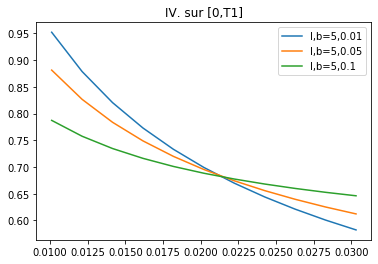

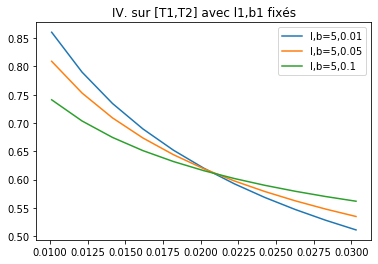

In [53]:
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
l= 5 
for b in b_vals:
    #calcul de lambda_bar , b_bar
    lbar = lambda_bar(maturities, bonds, maturity_grid,[], [], l, b, chi)
    bbar = b_bar(maturities, bonds, maturity_grid, [], [], l, b, chi)
    IV = [biss_python(log_displaced(S0,A0,1,strikes[m],lbar,bbar), bonds, strikes[m], maturities,"log-normal") for m in range(len(strikes))]
    ax.plot(strikes,IV,label="l,b="+str(l)+","+str(b))
        
    lbar2 = lambda_bar(maturities2, bonds2, maturity_grid2,[2], [0.15], l, b, chi)
    bbar2 = b_bar(maturities2, bonds2, maturity_grid2, [2], [0.15], l, b, chi)
    IV2 = [biss_python(log_displaced(S0,A02,2,strikes[m],lbar2,bbar2), bonds2, strikes[m], maturities2,"log-normal") for m in range(len(strikes))]
    ax2.plot(strikes,IV2,label="l,b="+str(l)+","+str(b))
        
ax.legend()
ax.set_title("IV. sur [0,T1]")
ax2.legend()
ax2.set_title("IV. sur [T1,T2] avec l1,b1 fixés")

**Remarque:** On voit que lorsqu'on fixe les paramètres $(\lambda_1,b_1)$, certaines valeurs fixées vont imposer une contrainte supplémentaire sur $\bar{\lambda}$ et $\bar{b}$ entre 0 et $T_2$. 

On peut écrire $\bar{\lambda}$ comme : $$\bar{\lambda}_n = \Big( \frac{1}{T_n} \Big( \psi \big( \lambda_1,..., \lambda_{n-1},b_1,...,b_{n-1}\big) + \int_{T_{n-1}}^{T_n} \lambda_{S_n}(t)^2 \ \mathrm{d}t \Big) \Big)^{\frac{1}{2}}$$
De même pour $\bar{b}_n$.

Par exemple, si la partie en $\psi$ dépasse un certain niveau $l$, alors on sera contraint d'ajouter un terme positif à $\bar{\lambda}_2$ et cela restreint le nombre de courbes possibles sur l'intervalle $[T_1,T_2]$ puisque $\bar{\lambda}_2 \ge l$ dans tous les cas.

## Observation de l'effet de la maturité sur les courbes LD générées

## Temps d'exécution

Test for (l,b)= 0.5 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 108
lambda_Chey, b_Chey = 3.643591522457923 0.07171652184471368
Param_LD =  [[0.50680497 0.40456319]]


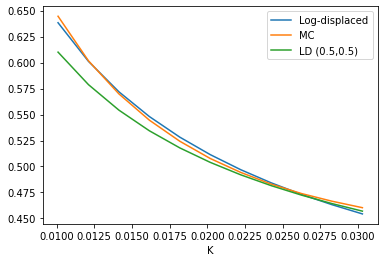

Diff ATM (MC - Log-displaced) -0.0037343454096117057
Diff ATM (MC - LD(l,b)) = 0.0037196743323875125
         87385900 function calls (87061944 primitive calls) in 408.727 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       65    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1009(_handle_fromlist)
       25    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:416(parent)
    11880    0.008    0.000    1.775    0.000 <ipython-input-10-d007a5594a0c>:20(<lambda>)
      264    0.001    0.000    1.805    0.007 <ipython-input-10-d007a5594a0c>:3(biss_python)
       21    0.000    0.000    1.614    0.077 <ipython-input-11-32715e4914c2>:12(<lambda>)
       21    0.001    0.000    1.614    0.077 <ipython-input-11-32715e4914c2>:12(<listcomp>)
        1    0.000    0.000    1.618    1.618 <ipython-input-11-32715e4914c2>:3(data_set_bis)
        1    0.000    0.000    0.000    0.000 <ipython-input-11-3271

        2    0.000    0.000    0.000    0.000 figure.py:157(__call__)
        1    0.000    0.000    0.000    0.000 figure.py:160(__contains__)
        1    0.000    0.000    0.000    0.000 figure.py:1624(clf)
        2    0.000    0.000    0.075    0.037 figure.py:1661(draw)
        4    0.000    0.000    0.000    0.000 figure.py:1675(<genexpr>)
        2    0.000    0.000    0.000    0.000 figure.py:1676(<lambda>)
        1    0.000    0.000    0.000    0.000 figure.py:168(__init__)
        1    0.000    0.000    0.000    0.000 figure.py:1882(_set_artist_props)
        5    0.000    0.000    0.012    0.002 figure.py:1888(gca)
        1    0.000    0.000    0.000    0.000 figure.py:1934(sca)
        2    0.000    0.000    0.000    0.000 figure.py:199(update)
        1    0.000    0.000    0.000    0.000 figure.py:2034(add_axobserver)
        1    0.000    0.000    0.000    0.000 figure.py:2325(get_default_bbox_extra_artists)
        1    0.000    0.000    0.000    0.000 figure.py:2326

        2    0.000    0.000    0.000    0.000 threading.py:240(__enter__)
        2    0.000    0.000    0.000    0.000 threading.py:243(__exit__)
        2    0.000    0.000    0.000    0.000 threading.py:249(_release_save)
        2    0.000    0.000    0.000    0.000 threading.py:252(_acquire_restore)
        2    0.000    0.000    0.000    0.000 threading.py:255(_is_owned)
        2    0.000    0.000    0.000    0.000 threading.py:264(wait)
        2    0.000    0.000    0.000    0.000 threading.py:499(__init__)
       43    0.000    0.000    0.000    0.000 threading.py:507(is_set)
        2    0.000    0.000    0.000    0.000 threading.py:534(wait)
       42    0.000    0.000    0.000    0.000 ticker.py:1514(raise_if_exceeds)
       14    0.000    0.000    0.000    0.000 ticker.py:1523(nonsingular)
       20    0.000    0.000    0.000    0.000 ticker.py:1648(__call__)
       20    0.000    0.000    0.000    0.000 ticker.py:1651(tick_values)
       42    0.000    0.000    0.000    

In [78]:
import cProfile
cp = cProfile.Profile()
cp.enable()

test(0.5,0.5)
    
cp.disable()
cp.print_stats()